In [807]:
# Since NIEHS' jupyterhub has different PATH values, force reticulate
# to use a specific version of Python rather than drawing on the PATH.
Sys.setenv(RETICULATE_PYTHON = "/ddn/gs1/home/laispf/usr/local/miniforge3/envs/r/bin/python3.8")

# TRIM28 analysis/figure generation

Apologies for the inefficient code, but this can always be rewritten for final publication as needed. Comments are provided at the top of each cell to explain what the code in the cell is doing.

In [808]:
# Load libraries.
library('devtools')
library('Seurat')
library('tidyverse')
library('ggplot2')
library('data.table')
library('SingleR')
library('ggthemes')

devtools::load_all("../../../rlib/dmSC")

ℹ Loading dmSC


In [828]:
# Create directories.

dir.create("Data/")
dir.create("Figures/")
dir.create("Data/MarkerGenes/")
dir.create("Data/IPA/")

Warning message in dir.create("Data/"):
“'Data' already exists”
Warning message in dir.create("Figures/"):
“'Figures' already exists”
Warning message in dir.create("Data/MarkerGenes/"):
“'Data/MarkerGenes' already exists”


In [810]:
# Set global plotting options.
options(repr.plot.width = 16, repr.plot.height = 8)

# Step 1: MCA 3.0 cell type imputation (identify mesenchymal and epithelial cells)

An object of class Seurat 
21528 features across 10313 samples within 1 assay 
Active assay: RNA (21528 features, 2000 variable features)
 2 dimensional reductions calculated: pca, umap

An object of class Seurat 
42151 features across 3739 samples within 1 assay 
Active assay: RNA (42151 features, 0 variable features)
 1 dimensional reduction calculated: all_tsne

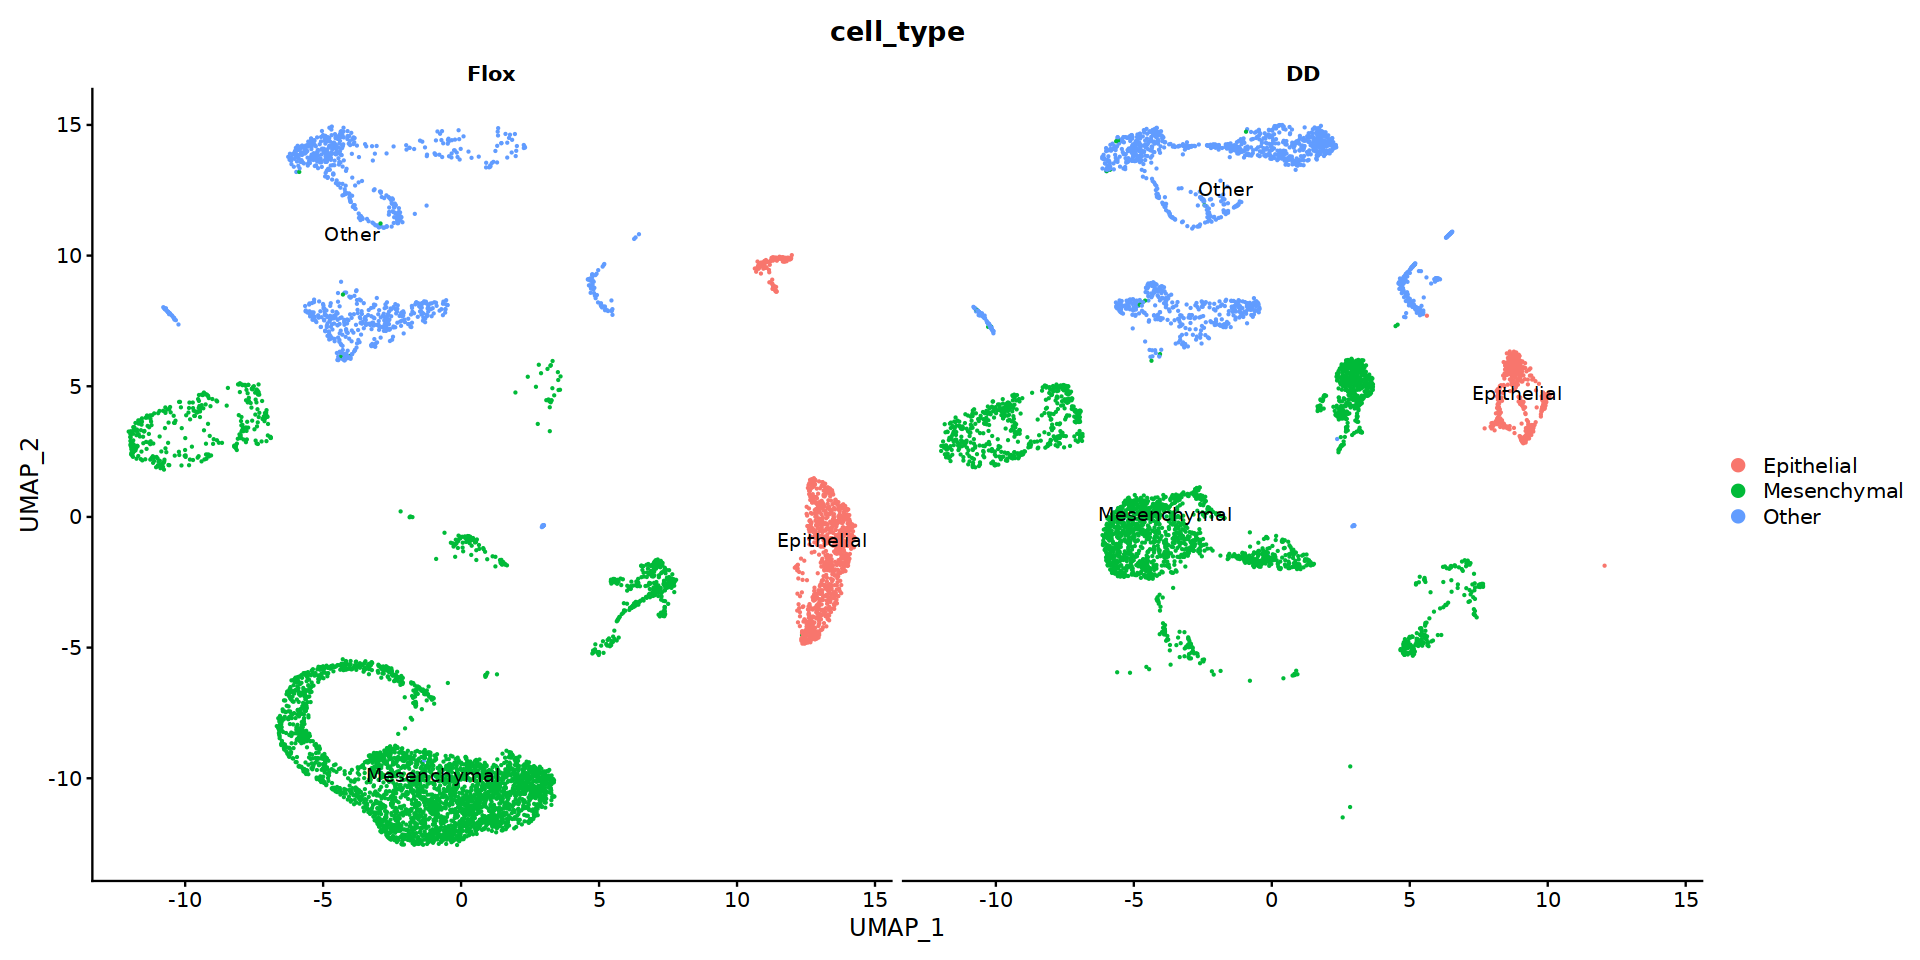

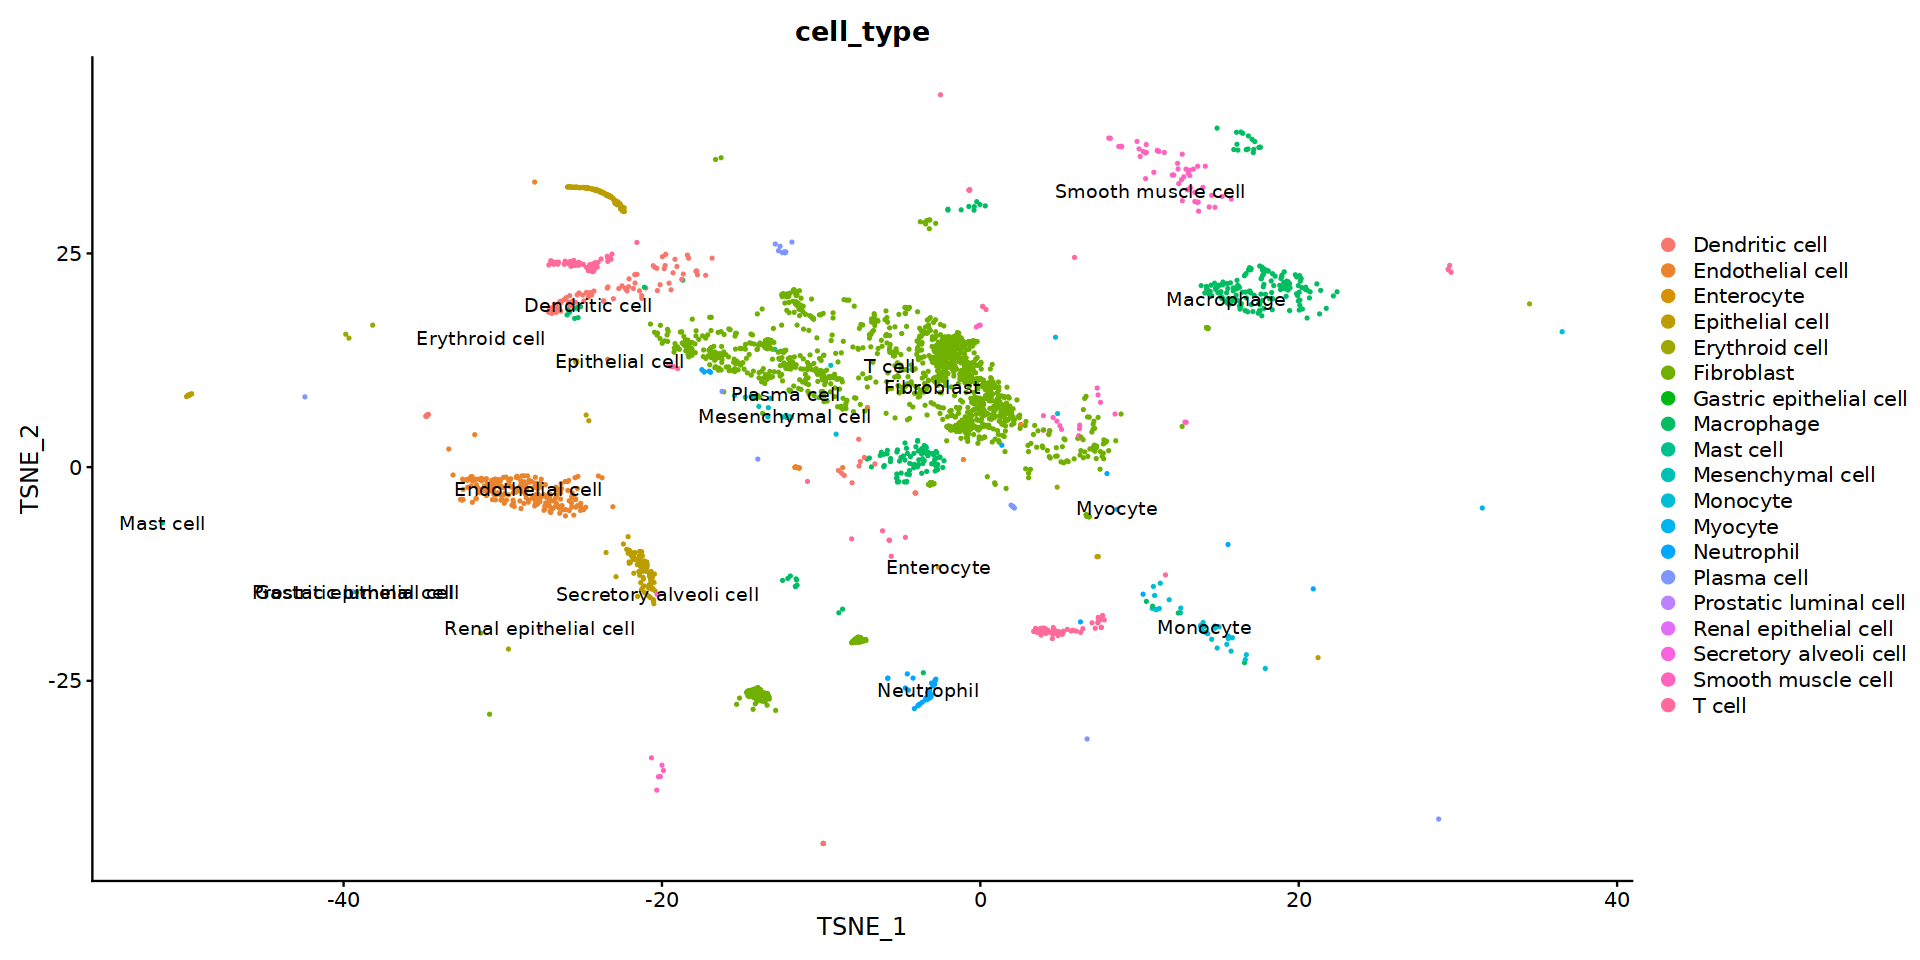

In [811]:
# Load in the processed data files.

trim28 <- readRDS("../ProcessedData/TRIM28-GSM6213387+GSM6213388.rds")
mca <- readRDS("../ProcessedData/MCA3.0-AdultUterus.rds")

trim28
mca

DimPlot(trim28, split.by="orig.ident", group.by="cell_type", label=TRUE)
DimPlot(mca, group.by="cell_type", label=TRUE)

Warning message in FUN(...):
“no within-block comparison between Gastric epithelial cell and Enterocyte”
Warning message in FUN(...):
“no within-block comparison between Prostatic luminal cell and Enterocyte”
Warning message in FUN(...):
“no within-block comparison between Prostatic luminal cell and Gastric epithelial cell”
Warning message in FUN(...):
“no within-block comparison between Renal epithelial cell and Enterocyte”
Warning message in FUN(...):
“no within-block comparison between Renal epithelial cell and Gastric epithelial cell”
Warning message in FUN(...):
“no within-block comparison between Renal epithelial cell and Prostatic luminal cell”
Warning message in FUN(...):
“no within-block comparison between Secretory alveoli cell and Enterocyte”
Warning message in FUN(...):
“no within-block comparison between Secretory alveoli cell and Gastric epithelial cell”
Warning message in FUN(...):
“no within-block comparison between Secretory alveoli cell and Prostatic luminal cell”
War

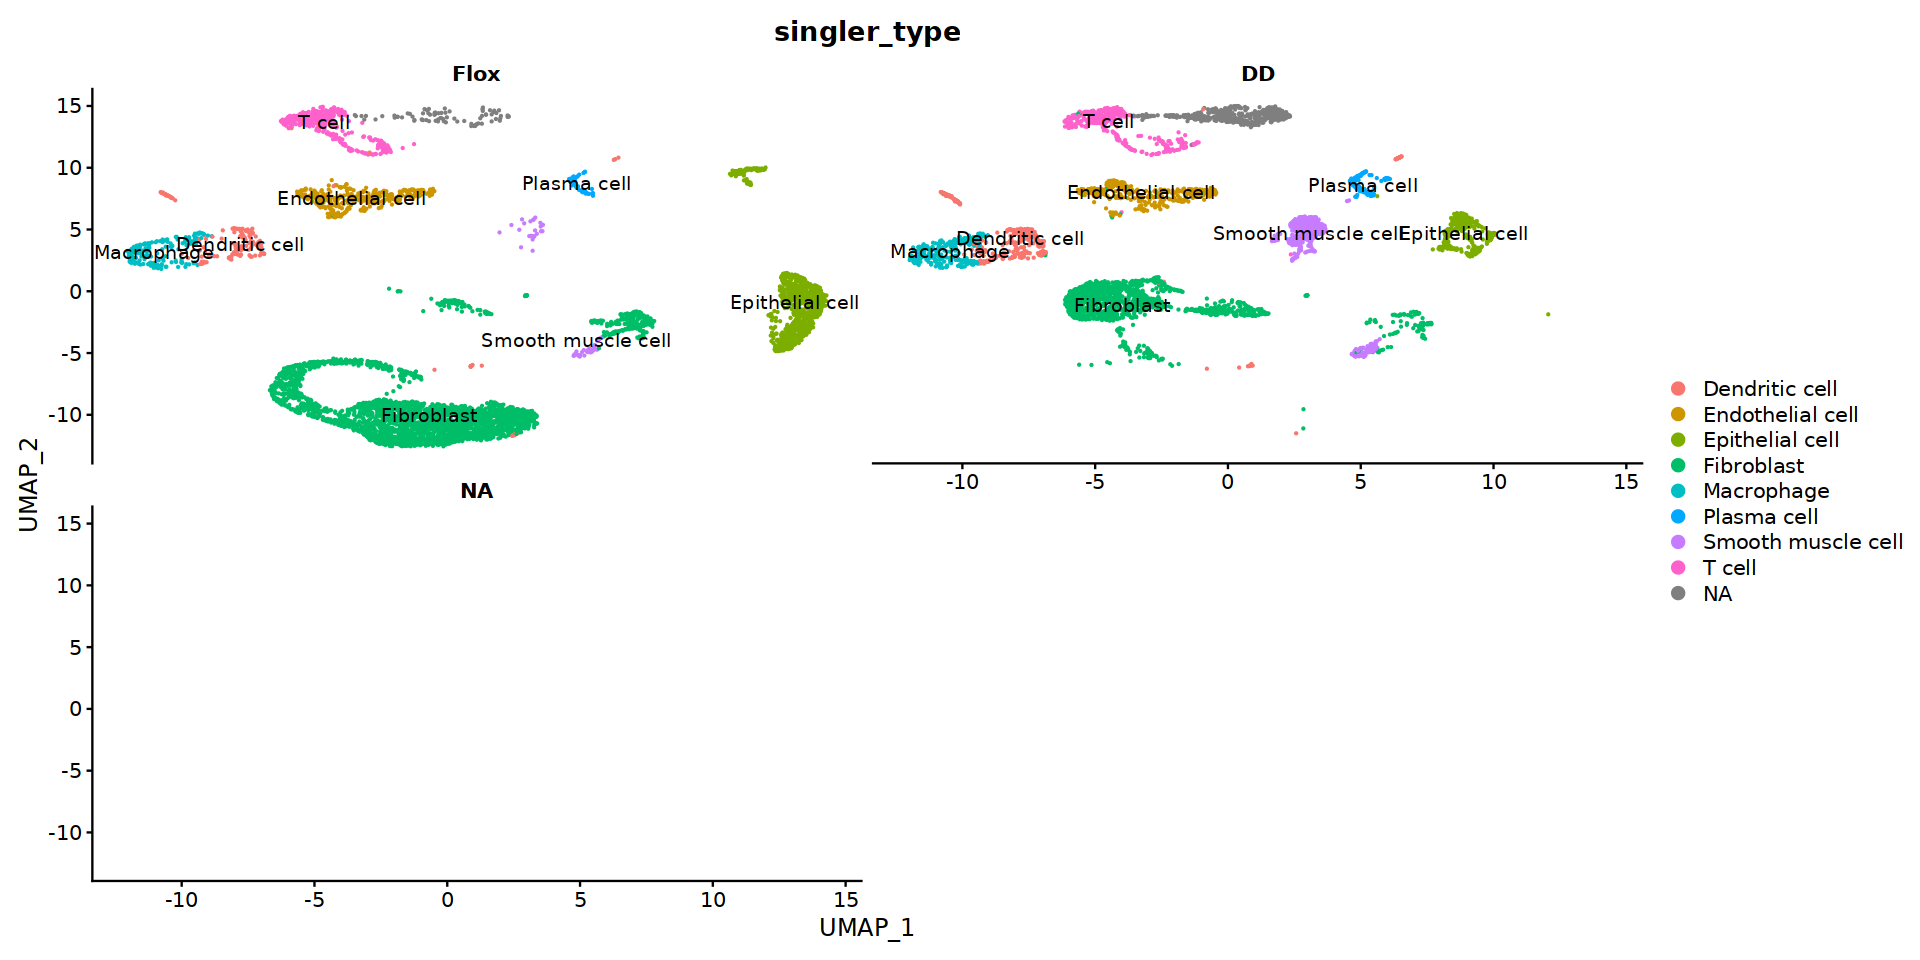

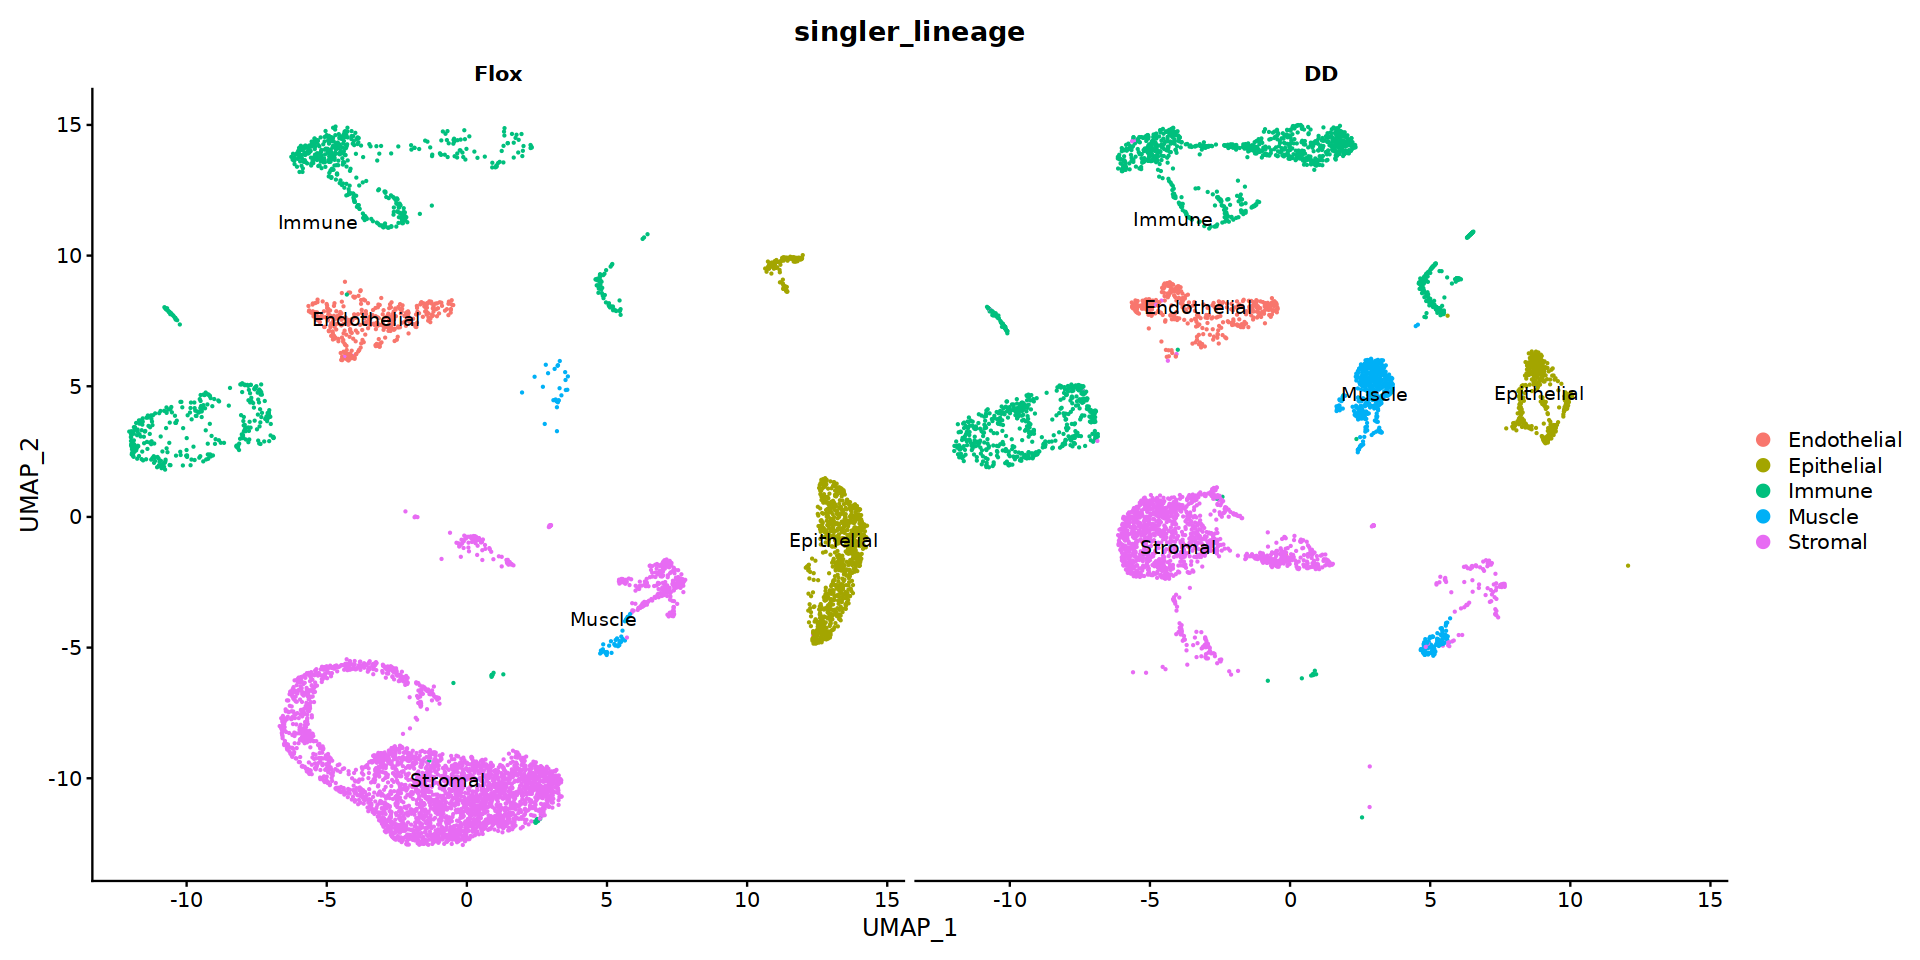

In [812]:
# Impute MCA 3.0 cell types and lineages for each TRIM28 cell using SingleR.

# Convert to single-cell experiments.
trim28_sce <- as.SingleCellExperiment(trim28)
mca_sce <- as.SingleCellExperiment(mca)

# Impute based on cell type, fine-grained.
pred_singler_type <- SingleR(test = trim28_sce,
                        ref = mca_sce,
                        assay.type.test = "logcounts",
                        assay.type.ref = "logcounts",
                        labels = mca$cell_type,
                        clusters = trim28$seurat_clusters,
                        de.method = "wilcox")
mapper_type <- data.frame(V1 = rownames(pred_singler_type), V2 = pred_singler_type$pruned.labels)

# Impute based on cell lineage, coarse.
pred_singler_lineage <- SingleR(test = trim28_sce,
                        ref = mca_sce,
                        assay.type.test = "logcounts",
                        assay.type.ref = "logcounts",
                        labels = mca$cell_lineage,
                        clusters = trim28$seurat_clusters,
                        de.method = "wilcox")
mapper_lineage <- data.frame(V1 = rownames(pred_singler_lineage), V2 = pred_singler_lineage$pruned.labels)

# Assign to type and lineage column.
trim28$singler_type <- dmSC::applyMapper(trim28$seurat_clusters, mapperTable = mapper_type)
trim28$singler_lineage <- dmSC::applyMapper(trim28$seurat_clusters, mapperTable = mapper_lineage)

# Save the trim28 file with new types.
saveRDS(trim28, file = "Data/TRIM28-GSM6213387+GSM6213388-MCA3.0ImputedCellType.rds")

# Visualize everything.
DimPlot(trim28, split.by="orig.ident", group.by="singler_type", label=TRUE)
DimPlot(trim28, split.by="orig.ident", group.by="singler_lineage", label=TRUE)

In [813]:
# Divide TRIM28 up into WT and KO cells and then identify the number of cells
# based on MCA 3.0 lineage.

trim28_wt <- subset(trim28, orig.ident == "Flox")
trim28_dd <- subset(trim28, orig.ident == "DD")

table(trim28_wt$singler_lineage)
table(trim28_dd$singler_lineage)
table(trim28_wt$singler_lineage) / length(trim28_wt$singler_lineage)
table(trim28_dd$singler_lineage) / length(trim28_dd$singler_lineage)


Endothelial  Epithelial      Immune      Muscle     Stromal 
        361        1018         865          59        3426 


Endothelial  Epithelial      Immune      Muscle     Stromal 
        364         450        1674         608        1488 


Endothelial  Epithelial      Immune      Muscle     Stromal 
 0.06301274  0.17769244  0.15098621  0.01029848  0.59801012 


Endothelial  Epithelial      Immune      Muscle     Stromal 
 0.07940663  0.09816754  0.36518325  0.13263525  0.32460733 

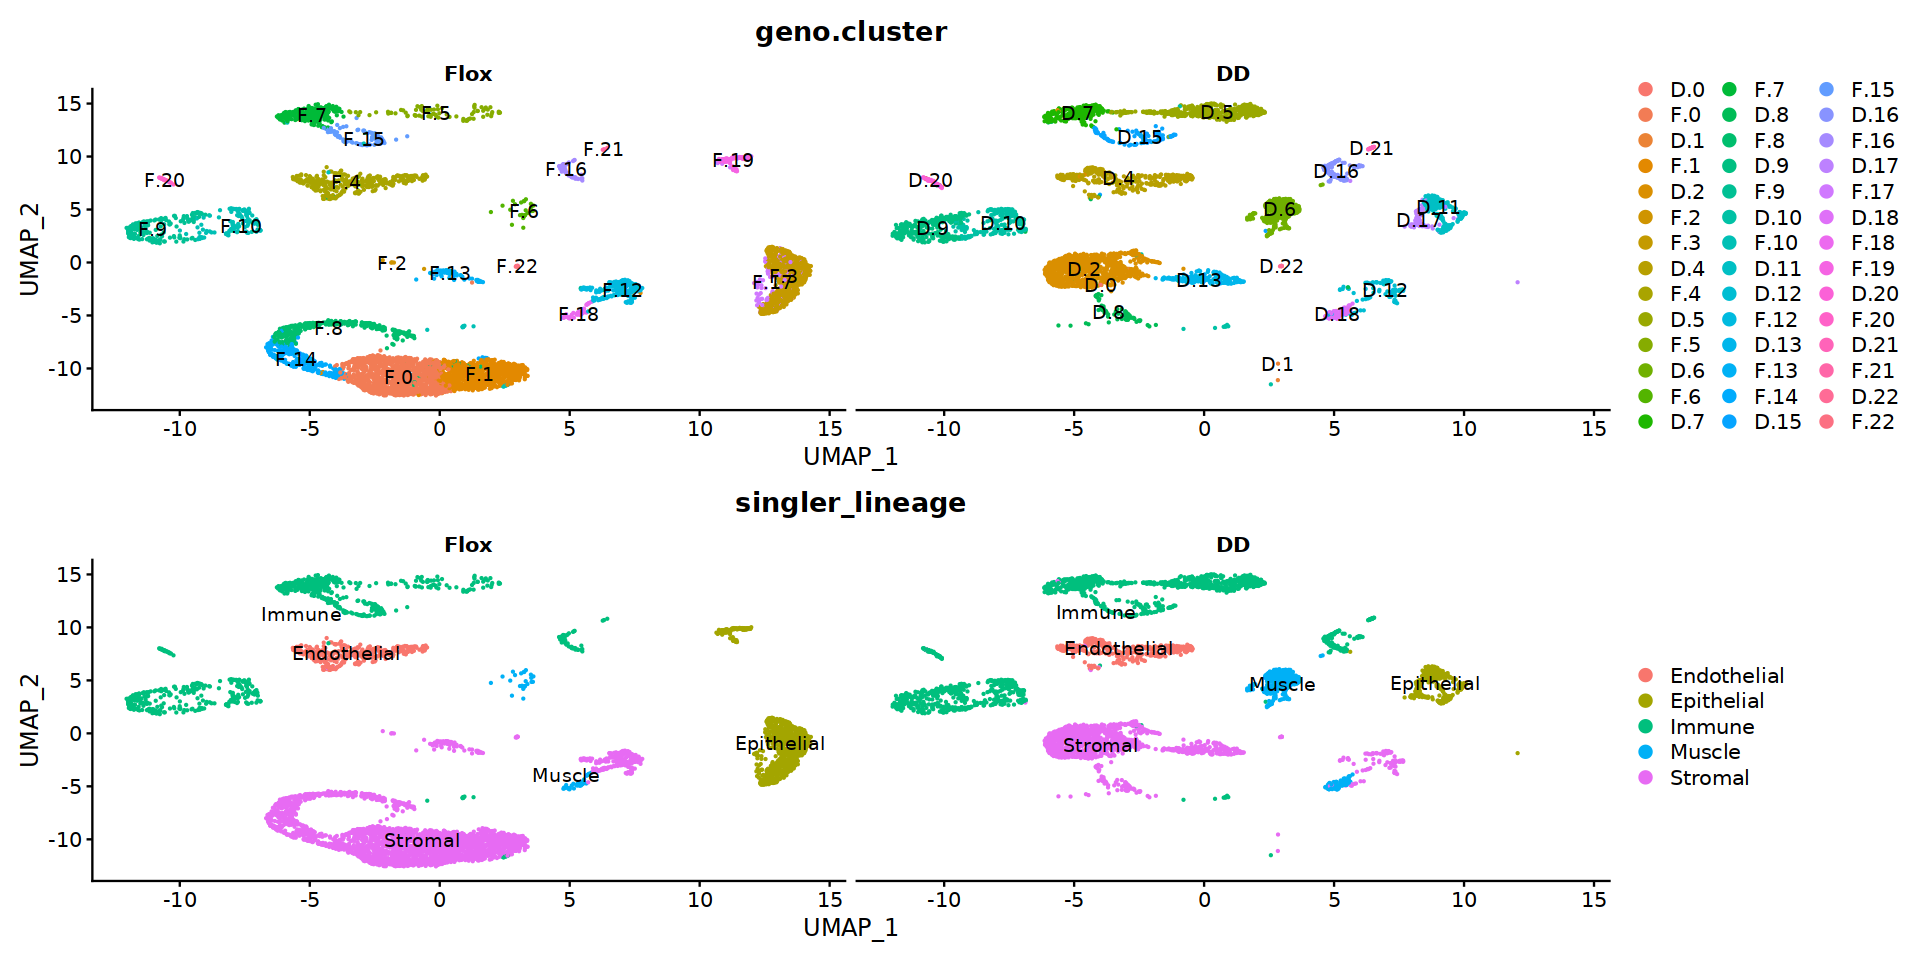

In [822]:
# Generate plots of the different TRIM28 clusters.

fig1 <- DimPlot(trim28, split.by="orig.ident", group.by="geno.cluster", label=TRUE)
fig2 <- DimPlot(trim28, split.by="orig.ident", group.by="singler_lineage", label=TRUE)
fig1 + fig2

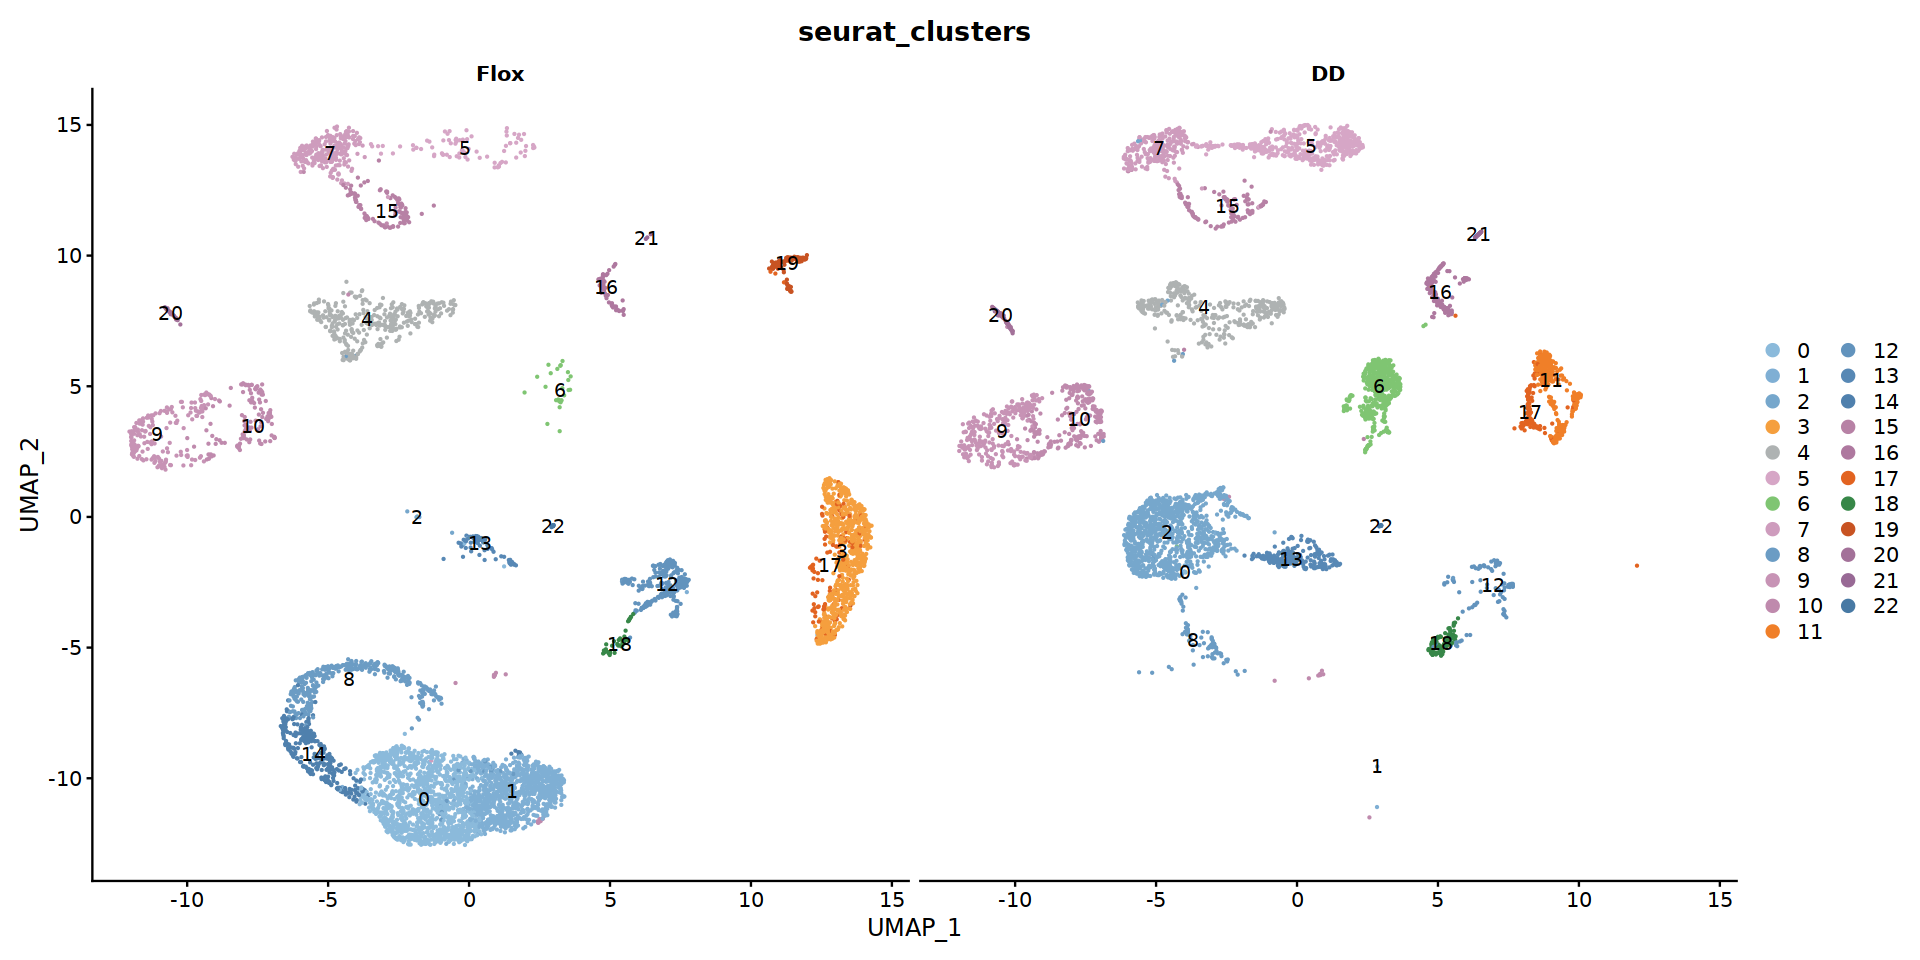

In [823]:
# Generate plots of the different TRIM28 clusters with similar color schemes
# among the same lineage.

clusters <- c(sort(c(0, 1, 2, 8, 12, 13, 14, 22)), # stromal
              sort(c(3, 11, 17, 19)), # epithelial
              sort(c(6, 18)), # muscle
              sort(c(4)), # endothelial
              sort(c(9, 10, 20, 7, 5, 15, 16, 21))) # immune
colors <- c(tableau_gradient_pal(palette = "Blue", type = "ordered-sequential")(seq(0.25, 0.75, length = 8)),
            tableau_gradient_pal(palette = "Orange", type = "ordered-sequential")(seq(0.25, 0.75, length = 4)),
            tableau_gradient_pal(palette = "Green", type = "ordered-sequential")(seq(0.25, 0.75, length = 2)),
            tableau_gradient_pal(palette = "Gray", type = "ordered-sequential")(seq(0.25, 0.75, length = 1)),
            tableau_gradient_pal(palette = "Purple", type = "ordered-sequential")(seq(0.25, 0.75, length = 8)))

mapper <- colors #c(dd_colors, flox_colors)
names(mapper) <- clusters #c(dd_clusters, flox_clusters)
mapped_levels <- dmSC::applyMapper(levels(trim28$seurat_clusters),
                                   mapperTable = data.table(V1 = names(mapper), V2 = as.vector(mapper)))


fig3 <- DimPlot(trim28, split.by="orig.ident", group.by="seurat_clusters", cols = mapped_levels, label=TRUE)
fig3

In [824]:
# Save the three above figures.

pdf("Figures/TRIM28-SingleRLineageCluster.pdf", width = 16, height = 8)
fig1
fig2
fig3
dev.off()

png 
  2

# Step 2: Test if CIBERSORTx deconvolution mirrors trends in single-cell proportions

In [815]:
# MCA 3.0 signature matrix save with NCBI Refseq naming conventions.

mca_singlecell_reference_mtx <- as.data.frame(GetAssayData(mca))
colnames(mca_singlecell_reference_mtx) <- mca$cell_lineage
rownames(mca_singlecell_reference_mtx) <- rownames(GetAssayData(mca))

fwrite(x = mca_singlecell_reference_mtx,
       file = "Data/MCA3.0-SingleCellReferenceMtx-NCBIRefSeq.tsv",
       sep = "\t",
       row.names = TRUE,
       col.names = TRUE)

Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 1.2 GiB”


In [816]:
# Generate TRIM28 pseudobulk data by adding up counts across all cells.

trim28_pseudoBulk <- data.frame(wt = rowSums(GetAssayData(trim28_wt, slot = "counts")),
                                dd = rowSums(GetAssayData(trim28_dd, slot = "counts")))
head(trim28_pseudoBulk)

fwrite(x = trim28_pseudoBulk,
       file = "Data/TRIM28-PseudoBulk.tsv",
       sep = "\t",
       row.names = TRUE,
       col.names = TRUE)

wt    dd  
Xkr4      266   83
Gm19938   468  183
Rp1        89   27
Sox17   11572 3592
Gm37587   176   69
Gm37323    14    2

In [817]:
# Pseudobulk results from above fed into CIBERSORTx and deconvolved, which
# required both the single-cell reference and pseudobulk data.
# Added t28b results to clarify where the columns come from.
# Can be used to see if these proportions line up with the actual proportions
# of cell types as seen at the end of step 1.

pb_results <- fread("Data/CIBERSORTxOutput_PseudoBulk/CIBERSORTx_Results.txt") %>% tibble::column_to_rownames("Mixture")
pb_results <- as.data.frame(t(pb_results[,1:6]))
colnames(pb_results) <- paste0(colnames(pb_results), "_pb")
pb_results

wt_pb       dd_pb     
Immune      0.034153268 0.11429141
Epithelial  0.422588190 0.22205492
Stromal     0.449844584 0.36698289
Endothelial 0.054508691 0.03306548
Erythroid   0.006681832 0.05940908
Muscle      0.032223435 0.20419622

In [818]:
# Separate TRIM28 bulk data (GSE205481) also deconvolved using CIBERSORT.
# Can be used to see if trends in cell types change as they do with the
# ground-truth single-cell proportions reported in Step 1.

trim28bulk_results <- fread("Data/CIBERSORTxOutput_TRIM28Bulk/CIBERSORTx_Results.txt") %>% tibble::column_to_rownames("Mixture")
trim28bulk_results <- as.data.frame(t(trim28bulk_results[,1:6]))
colnames(trim28bulk_results) <- paste0(colnames(trim28bulk_results), "_t28b")
trim28bulk_results

35TRff1_t28b 35TRff2_t28b 35TRff3_t28b 35TRff4_t28b 35TRdd1_t28b
Immune      0.05523634   0.03881696   0.04870753   0.05920506   0.08603857  
Epithelial  0.19216891   0.18558930   0.15495927   0.14482780   0.21871040  
Stromal     0.29543212   0.35730094   0.43968978   0.46801963   0.23890955  
Endothelial 0.03942287   0.04642212   0.03705407   0.03249035   0.00000000  
Erythroid   0.00000000   0.00000000   0.00000000   0.00000000   0.00000000  
Muscle      0.41773976   0.37187069   0.31958936   0.29545716   0.45634147  
            35TRdd2_t28b 35TRdd3_t28b 35TRdd4_t28b
Immune      0.1160736    0.06212151   0.1166134   
Epithelial  0.1821301    0.30202644   0.2721706   
Stromal     0.2969712    0.21480602   0.2859506   
Endothelial 0.0000000    0.00000000   0.0000000   
Erythroid   0.0000000    0.00000000   0.0000000   
Muscle      0.4048250    0.42104602   0.3252654

In [819]:
# Combine all of the above results in one table.

tmp <- tibble::column_to_rownames(dplyr::left_join(tibble::rownames_to_column(pb_results), tibble::rownames_to_column(trim28bulk_results), by = "rowname"), "rowname")
frac_tbl_orig <- data.frame(wt_sc = c(table(trim28_wt$singler_lineage) / length(trim28_wt$singler_lineage), 0),
                            dd_sc = c(table(trim28_dd$singler_lineage) / length(trim28_dd$singler_lineage), 0))
rownames(frac_tbl_orig)[dim(frac_tbl_orig)[1]] <- "Erythroid"
frac_tbl_orig <- dplyr::left_join(tibble::rownames_to_column(frac_tbl_orig),
                                  tibble::rownames_to_column(tmp), by = "rowname") %>% tibble::column_to_rownames("rowname")
frac_tbl_orig

wt_sc      dd_sc      wt_pb       dd_pb      35TRff1_t28b
Endothelial 0.06301274 0.07940663 0.054508691 0.03306548 0.03942287  
Epithelial  0.17769244 0.09816754 0.422588190 0.22205492 0.19216891  
Immune      0.15098621 0.36518325 0.034153268 0.11429141 0.05523634  
Muscle      0.01029848 0.13263525 0.032223435 0.20419622 0.41773976  
Stromal     0.59801012 0.32460733 0.449844584 0.36698289 0.29543212  
Erythroid   0.00000000 0.00000000 0.006681832 0.05940908 0.00000000  
            35TRff2_t28b 35TRff3_t28b 35TRff4_t28b 35TRdd1_t28b 35TRdd2_t28b
Endothelial 0.04642212   0.03705407   0.03249035   0.00000000   0.0000000   
Epithelial  0.18558930   0.15495927   0.14482780   0.21871040   0.1821301   
Immune      0.03881696   0.04870753   0.05920506   0.08603857   0.1160736   
Muscle      0.37187069   0.31958936   0.29545716   0.45634147   0.4048250   
Stromal     0.35730094   0.43968978   0.46801963   0.23890955   0.2969712   
Erythroid   0.00000000   0.00000000   0.00000000   0.00000000   0.0000000   
            35TRdd3_t28b 35TRdd4_t28b
Endothelial 0.00000000   0.0000000   
Epithelial  0.30202644   0.2721706   
Immune      0.06212151   0.1166134   
Muscle      0.42104602   0.3252654   
Stromal     0.21480602   0.2859506   
Erythroid   0.00000000   0.0000000

png 
  2

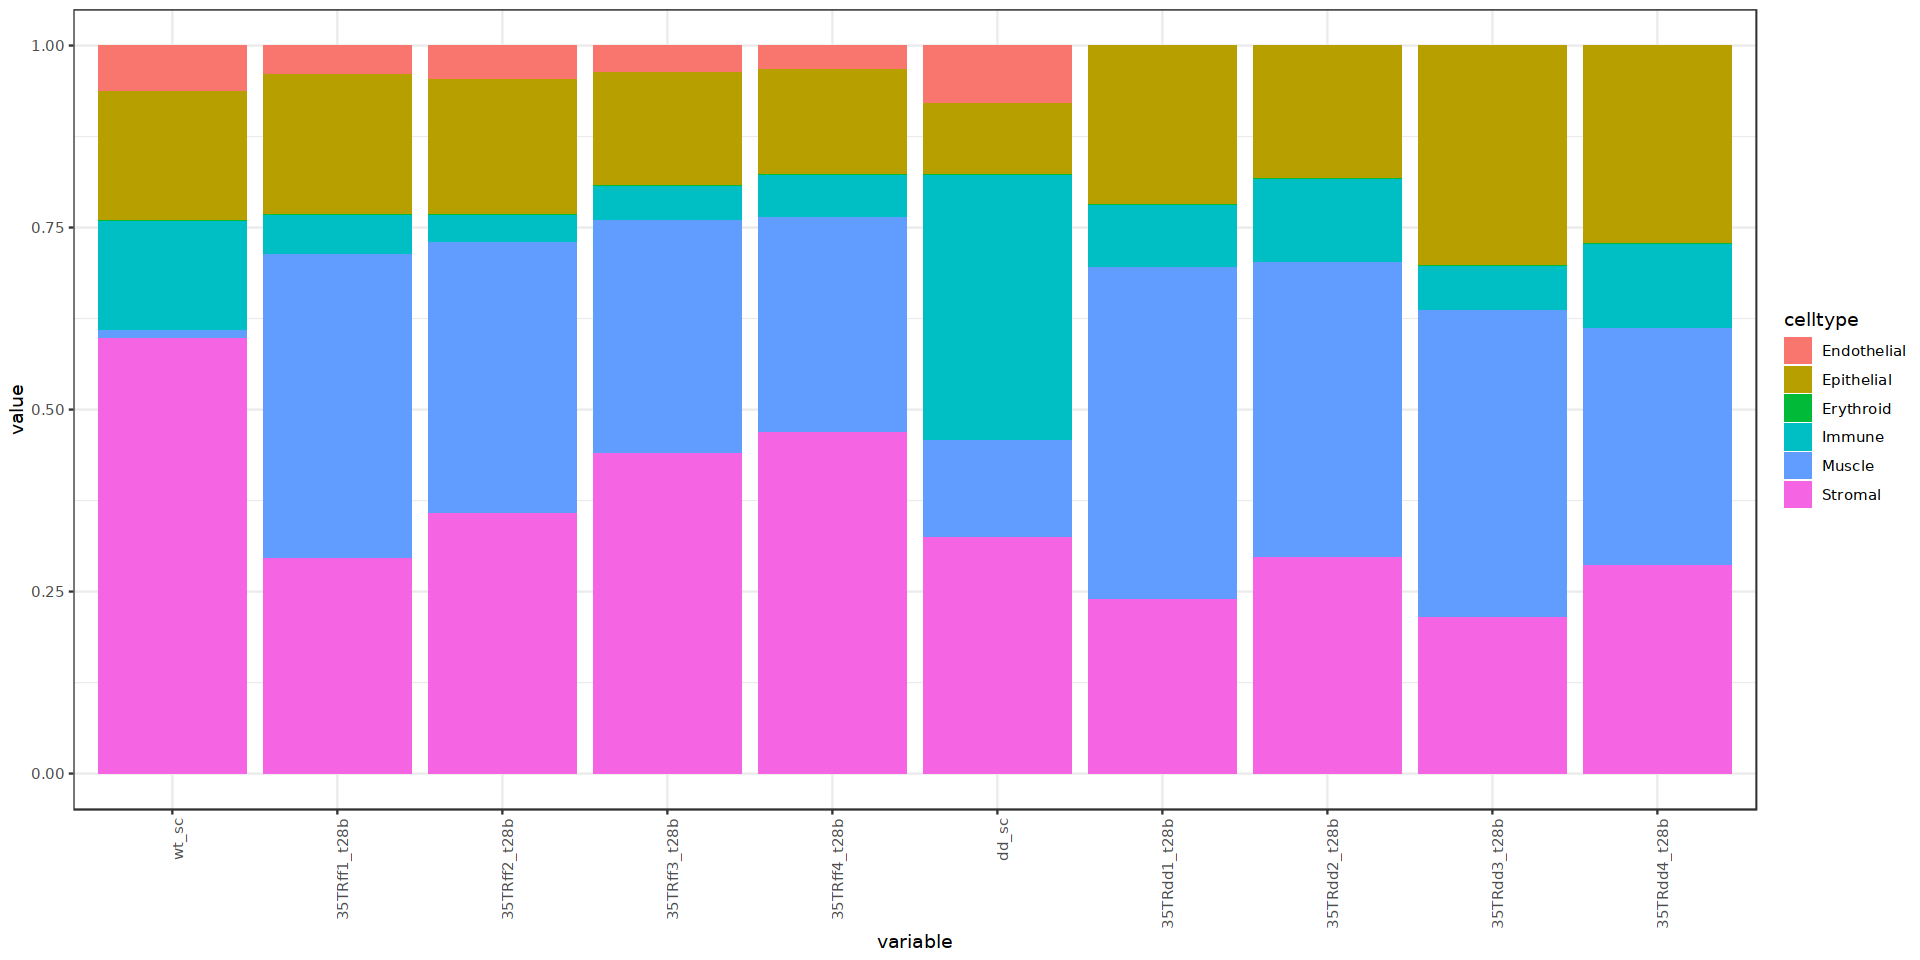

In [820]:
# Plot the above table in the form of stacked bar plots for visualization.
# Also save the plots.

frac_tbl <- frac_tbl_orig[,c(1,5:8,2,9:12)] %>% tibble::rownames_to_column("celltype") %>% melt(id.vars = "celltype")
plt <- ggplot(data = frac_tbl, aes(x = variable, y = value, fill = celltype)) +
    geom_bar(stat = "identity") + 
    theme_bw() + 
    theme(axis.text.x = element_text(angle = 90, hjust = 1))
plt

pdf("Figures/DeconvVsPseudobulkTRIM28-3.pdf", width = 16, height = 8)
plt
dev.off()

# Step 3: generate data files for other applications

In [821]:
# MCA 3.0 signature matrix save with ENSEMBL naming conventions.

mca_singlecell_reference_mtx_ensembl <- as.matrix(mca_singlecell_reference_mtx)
rownames(mca_singlecell_reference_mtx_ensembl) <- dmSC::applyMapper(rownames(mca_singlecell_reference_mtx_ensembl), toEnsembl = TRUE)
mca_singlecell_reference_mtx_ensembl <- mca_singlecell_reference_mtx_ensembl[!is.na(rownames(test_mtx)),]

fwrite(x = as.data.frame(mca_singlecell_reference_mtx_ensembl),
       file = "Data/MCA3.0-SingleCellReferenceMtx-ENSEMBL.tsv",
       sep = "\t",
       row.names = TRUE,
       col.names = TRUE)

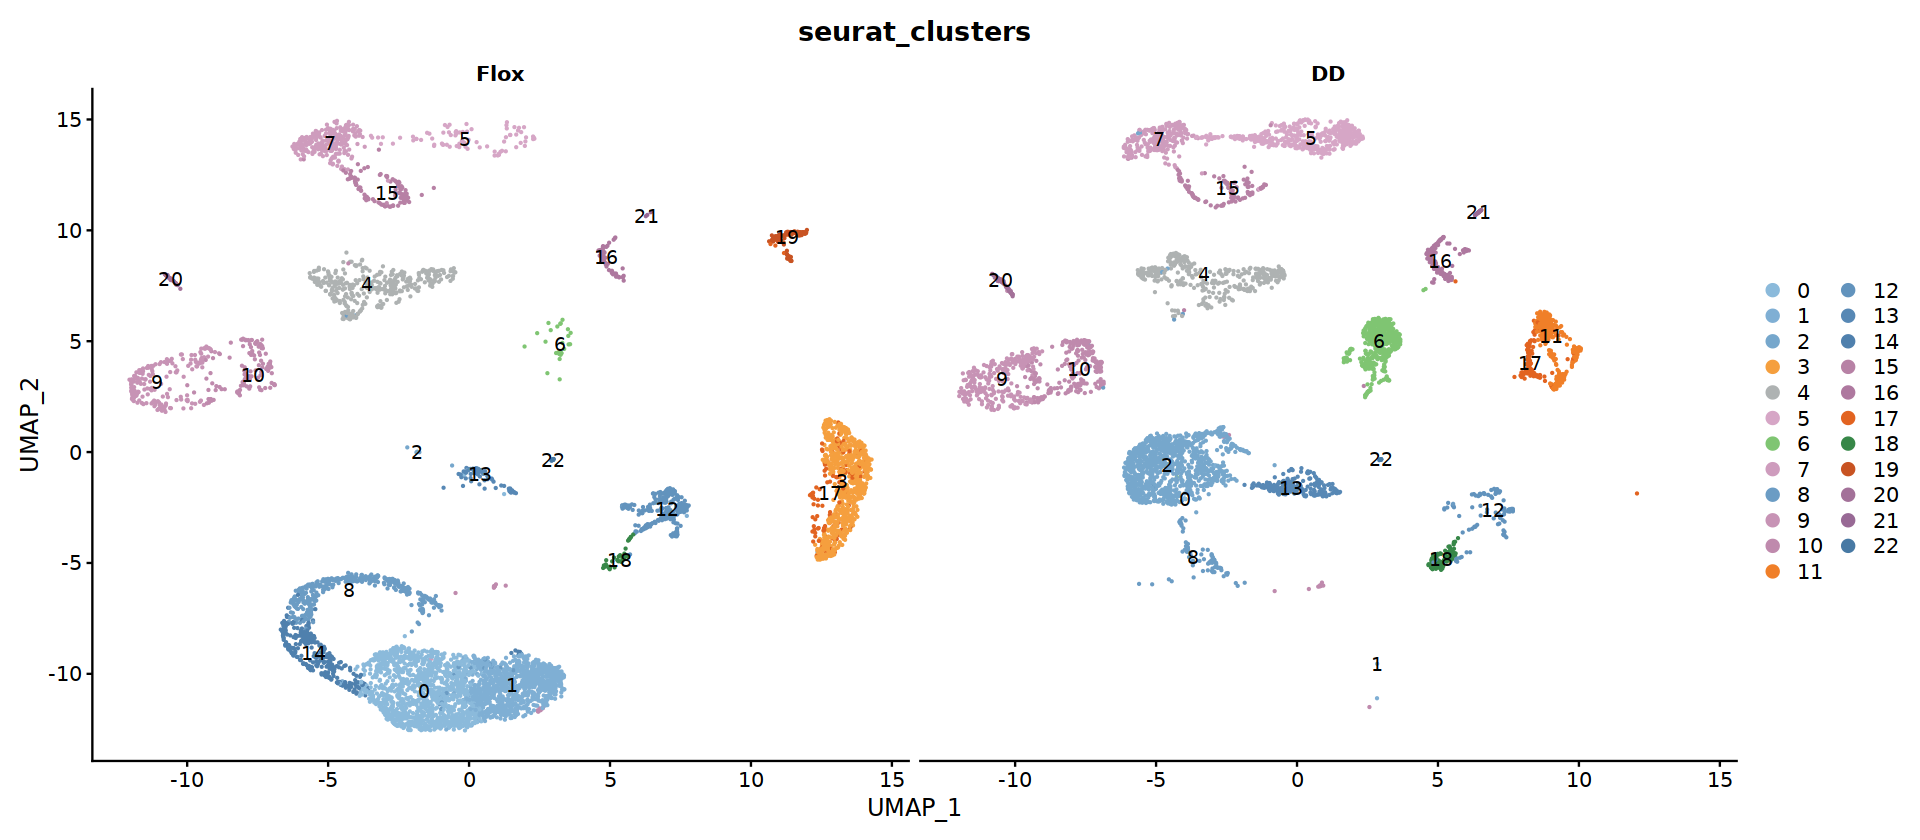

In [129]:
clusters <- c(sort(c(0, 1, 2, 8, 12, 13, 14, 22)), # stromal
              sort(c(3, 11, 17, 19)), # epithelial
              sort(c(6, 18)), # muscle
              sort(c(4)), # endothelial
              sort(c(9, 10, 20, 7, 5, 15, 16, 21))) # immune
colors <- c(tableau_gradient_pal(palette = "Blue", type = "ordered-sequential")(seq(0.25, 0.75, length = 8)),
            tableau_gradient_pal(palette = "Orange", type = "ordered-sequential")(seq(0.25, 0.75, length = 4)),
            tableau_gradient_pal(palette = "Green", type = "ordered-sequential")(seq(0.25, 0.75, length = 2)),
            tableau_gradient_pal(palette = "Gray", type = "ordered-sequential")(seq(0.25, 0.75, length = 1)),
            tableau_gradient_pal(palette = "Purple", type = "ordered-sequential")(seq(0.25, 0.75, length = 8)))

mapper <- colors #c(dd_colors, flox_colors)
names(mapper) <- clusters #c(dd_clusters, flox_clusters)
mapped_levels <- dmSC::applyMapper(levels(trim28$seurat_clusters),
                                   mapperTable = data.table(V1 = names(mapper), V2 = as.vector(mapper)))

saved <- options(repr.plot.width = 16)
complex_fig <- DimPlot(trim28, split.by="orig.ident", group.by="seurat_clusters", cols = mapped_levels, label=TRUE)
complex_fig
options(saved)

In [6]:
# Save the trim28 file.

saveRDS(trim28, file = "TRIM28-GSM6213387+GSM6213388-MCA3.0ImputedCellType.rds")

# Step 4: Individual marker genes

In [833]:
# Declare temporary variables.

trim28_tmp_clusters <- trim28
Idents(trim28_tmp_clusters) <- trim28_tmp$seurat_clusters

trim28_tmp_lineage <- trim28
trim28_tmp_lineage$IdentByLineage <- interaction(trim28_tmp$orig.ident, trim28_tmp$singler_lineage)
Idents(trim28_tmp_lineage) <- trim28_tmp_lineage$IdentByLineage

In [830]:
# Make the function for GO plots. See the Github link above.
# Code taken from enrichplot: https://github.com/YuLab-SMU/enrichplot/blob/devel/R/dotplot.R#L200-L207
ipa_plot <- function(ipa_table, title) {
    tmp <- ipa_table
    x_axis <- "Ingenuity Canonical Pathways"
    order_by <- "z-score"
    tmp[[x_axis]] <- ordered(tmp[[x_axis]], levels=tmp[[x_axis]][order(tmp[[order_by]])])
    return(ggplot(tmp,
                  aes(x = `Ingenuity Canonical Pathways`,
                      y = `z-score`,
                      size = `Ratio`,
                      color = `-log(p-value)`)) + geom_point() + theme_bw() + theme(axis.text.x = element_text(angle = 90, hjust = 1)) + ggtitle(title))
}

In [827]:
## Overall information.

# Summary table.

head(trim28_tmp[[]])

# Number of cells per group.
table(Idents(trim28_tmp))

orig.ident nCount_RNA nFeature_RNA percent.mt
Flox_AAACCCAAGACCTGGA-1 Flox       17459      4390          6.037001 
Flox_AAACCCAAGCTCACTA-1 Flox       23797      4982          5.147708 
Flox_AAACCCAAGGTTGACG-1 Flox       26888      5165          5.400179 
Flox_AAACCCAAGTCAGCCC-1 Flox       11657      3209          3.294158 
Flox_AAACCCACACACACGC-1 Flox        6097      2196         11.087420 
Flox_AAACCCACAGCATCTA-1 Flox       23316      4601          6.141705 
                        RNA_snn_res.0.5 seurat_clusters genotype geno.cluster
Flox_AAACCCAAGACCTGGA-1 8               8               F        F.8         
Flox_AAACCCAAGCTCACTA-1 12              12              F        F.12        
Flox_AAACCCAAGGTTGACG-1 0               0               F        F.0         
Flox_AAACCCAAGTCAGCCC-1 7               7               F        F.7         
Flox_AAACCCACACACACGC-1 3               3               F        F.3         
Flox_AAACCCACAGCATCTA-1 0               0               F        F.0         
                        cell_type   singler_type    singler_lineage
Flox_AAACCCAAGACCTGGA-1 Mesenchymal Fibroblast      Stromal        
Flox_AAACCCAAGCTCACTA-1 Mesenchymal Fibroblast      Stromal        
Flox_AAACCCAAGGTTGACG-1 Mesenchymal Fibroblast      Stromal        
Flox_AAACCCAAGTCAGCCC-1 Other       T cell          Immune         
Flox_AAACCCACACACACGC-1 Epithelial  Epithelial cell Epithelial     
Flox_AAACCCACAGCATCTA-1 Mesenchymal Fibroblast      Stromal        
                        IdentByLineage 
Flox_AAACCCAAGACCTGGA-1 Flox.Stromal   
Flox_AAACCCAAGCTCACTA-1 Flox.Stromal   
Flox_AAACCCAAGGTTGACG-1 Flox.Stromal   
Flox_AAACCCAAGTCAGCCC-1 Flox.Immune    
Flox_AAACCCACACACACGC-1 Flox.Epithelial
Flox_AAACCCACAGCATCTA-1 Flox.Stromal


Flox.Endothelial   DD.Endothelial  Flox.Epithelial    DD.Epithelial 
             361              364             1018              450 
     Flox.Immune        DD.Immune      Flox.Muscle        DD.Muscle 
             865             1674               59              608 
    Flox.Stromal       DD.Stromal 
            3426             1488 

### Epithelial cells

In [834]:
## Top marker genes.

epi_markers <- FindMarkers(trim28_tmp_lineage, ident.1 = "DD.Epithelial", ident.2 = "Flox.Epithelial")
epi_markers <- epi_markers %>% filter(p_val_adj < 0.05) %>% arrange(desc(avg_log2FC))
head(epi_markers)

fwrite(x = epi_markers,
       file = "Data/MarkerGenes/EpithelialMarkerGenes-PAdj<0.05-NCBIRefSeq.csv",
       row.names = TRUE,
       col.names = TRUE)

fwrite(x = epi_markers %>% filter(abs(avg_log2FC) > log2(1.5)),
       file = "Data/MarkerGenes/EpithelialMarkerGenes-PAdj<0.05+AbsFC>1.5-NCBIRefSeq.csv",
       row.names = TRUE,
       col.names = TRUE)

p_val         avg_log2FC pct.1 pct.2 p_val_adj    
Lcn2    8.558448e-225 3.999501   0.891 0.085 1.842463e-220
C3      1.935503e-184 2.752145   0.796 0.085 4.166750e-180
Igkc     1.210989e-54 2.691268   0.807 0.660  2.607018e-50
Naalad2 1.576534e-218 2.651507   0.829 0.043 3.393963e-214
Tacstd2 1.303009e-142 2.609422   0.702 0.096 2.805119e-138
Iglc1    6.734603e-10 2.410163   0.278 0.136  1.449825e-05

In [835]:
## Load in IPA pathway results.

epi_pathways <- fread("Data/IPA/EpithelialMarkerGenes-PAdj_0.05+AbsFC_1.5-NCBIRefSeq.txt") %>% 
    filter(abs(`z-score`) > 2 & `-log(p-value)` > -log10(0.05))
dim(epi_pathways)
head(epi_pathways[,1:4])

[1] 36  6

Ingenuity Canonical Pathways                                                  
1 Sertoli Cell-Sertoli Cell Junction Signaling                                  
2 Interleukin-4 and Interleukin-13 signaling                                    
3 RHO GTPases activate IQGAPs                                                   
4 Gap junction trafficking and regulation                                       
5 Role of Macrophages, Fibroblasts and Endothelial Cells in Rheumatoid Arthritis
6 IL-17A Signaling in Fibroblasts                                               
  -log(p-value) Ratio  z-score
1 8.56          0.0988 2.449  
2 7.42          0.1360 2.138  
3 6.41          0.2580 2.828  
4 6.08          0.2350 2.121  
5 5.97          0.0721 2.294  
6 4.80          0.1250 2.530

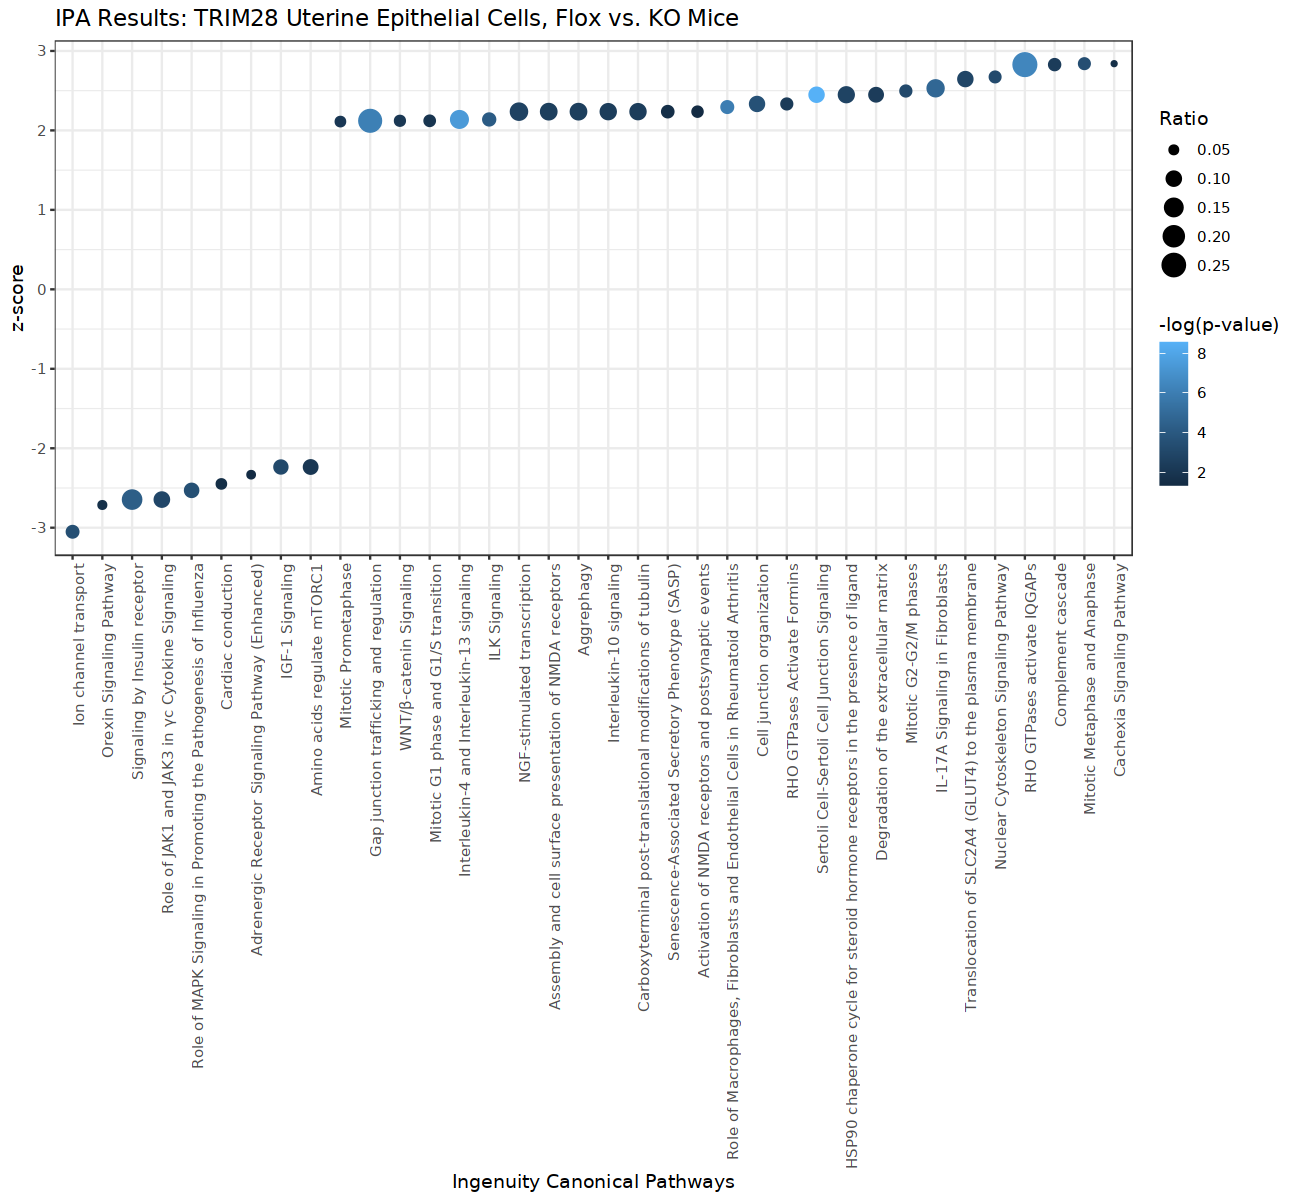

In [836]:
## Dot plot of pathways.

saved <- options(repr.plot.width = dim(epi_pathways)[1] * 0.3, repr.plot.height = 10)
fig_epi_pathways <- ipa_plot(epi_pathways, "IPA Results: TRIM28 Uterine Epithelial Cells, Flox vs. KO Mice")
fig_epi_pathways
options(saved)

### Stromal cells

In [837]:
## Top marker genes.

stromal_markers <- FindMarkers(trim28_tmp_lineage, ident.1 = "DD.Stromal", ident.2 = "Flox.Stromal")
stromal_markers <- stromal_markers %>% filter(p_val_adj < 0.05) %>% arrange(desc(avg_log2FC))
head(stromal_markers)

fwrite(stromal_markers, "Data/MarkerGenes/StromalMarkerGenes-PAdj<0.05-NCBIRefSeq.csv", row.names = TRUE, col.names = TRUE)
fwrite(stromal_markers %>% filter(abs(avg_log2FC) > log2(1.5)), "Data/MarkerGenes/StromalMarkerGenes-PAdj<0.05+AbsFC>1.5-NCBIRefSeq.csv", row.names = TRUE, col.names = TRUE)

p_val avg_log2FC pct.1 pct.2 p_val_adj
Col6a4 0     2.759987   0.918 0.627 0        
Prss23 0     2.650327   0.900 0.160 0        
Col1a1 0     2.452097   0.982 0.988 0        
A2m    0     2.421326   0.647 0.143 0        
Mfap4  0     2.377778   0.850 0.527 0        
Ogn    0     2.238965   0.852 0.400 0

In [838]:
## Load in IPA pathway results.

stromal_pathways <- fread("Data/IPA/StromalMarkerGenes-PAdj_0.05+AbsFC_1.5-NCBIRefSeq.txt") %>% filter(abs(`z-score`) > 2 & `-log(p-value)` > -log10(0.05))
dim(stromal_pathways)
head(stromal_pathways[,1:4])

[1] 39  6

Ingenuity Canonical Pathways                                  -log(p-value)
1 Role of Osteoclasts in Rheumatoid Arthritis Signaling Pathway 10.70        
2 Pathogen Induced Cytokine Storm Signaling Pathway              6.97        
3 Collagen degradation                                          14.60        
4 Collagen biosynthesis and modifying enzymes                   14.00        
5 Assembly of collagen fibrils and other multimeric structures  14.60        
6 Extracellular matrix organization                             14.90        
  Ratio  z-score
1 0.0682 3.710  
2 0.0485 3.300  
3 0.2300 3.207  
4 0.2090 3.207  
5 0.2300 3.207  
6 0.1600 3.153

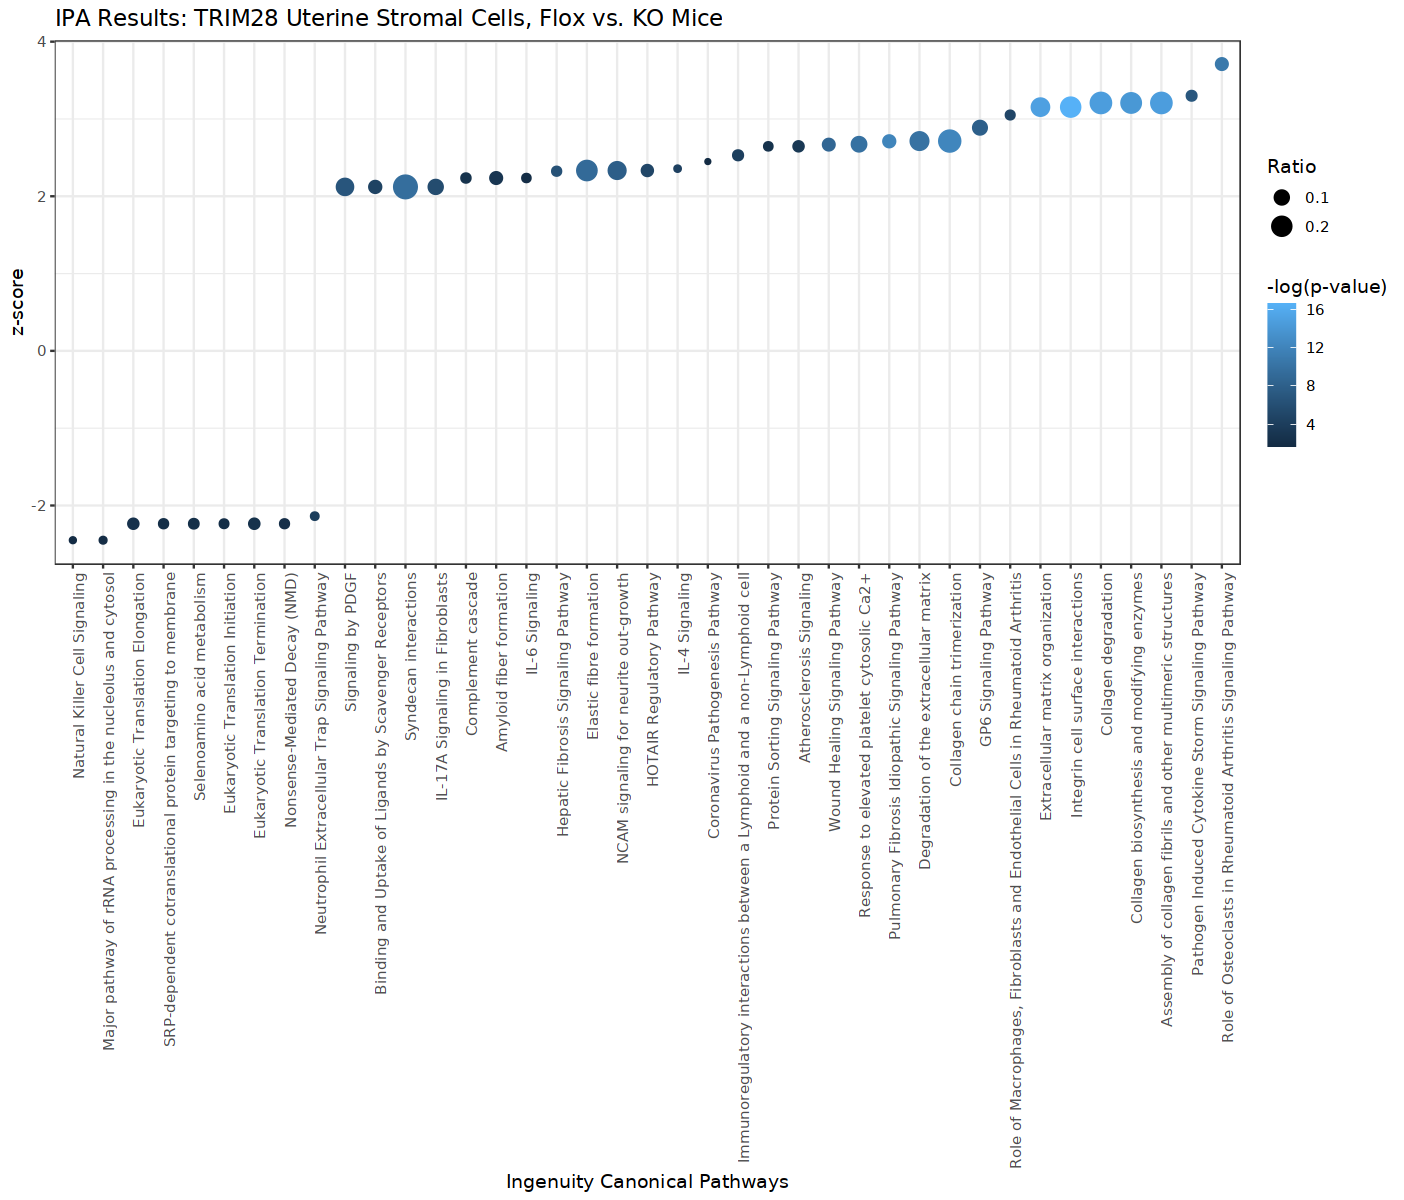

In [839]:
## Dot plot of pathways.

saved <- options(repr.plot.width = dim(stromal_pathways)[1] * 0.3, repr.plot.height = 10)
fig_stromal_pathways <- ipa_plot(stromal_pathways, "IPA Results: TRIM28 Uterine Stromal Cells, Flox vs. KO Mice")
fig_stromal_pathways
options(saved)

### Muscle cells

In [840]:
## Top marker genes.

muscle_markers <- FindMarkers(trim28_tmp_lineage, ident.1 = "DD.Muscle", ident.2 = "Flox.Muscle")
muscle_markers <- muscle_markers %>% filter(p_val_adj < 0.05) %>% arrange(desc(avg_log2FC))
head(muscle_markers)

fwrite(muscle_markers, "Data/MarkerGenes/MuscleMarkerGenes-PAdj<0.05-NCBIRefSeq.csv", row.names = TRUE, col.names = TRUE)
fwrite(muscle_markers %>% filter(abs(avg_log2FC) > log2(1.5)), "Data/MarkerGenes/MuscleMarkerGenes-PAdj<0.05+AbsFC>1.5-NCBIRefSeq.csv", row.names = TRUE, col.names = TRUE)

p_val        avg_log2FC pct.1 pct.2 p_val_adj   
Igkc  4.842536e-14 2.695486   0.854 0.356 1.042501e-09
Igha  3.533159e-09 1.704925   0.757 0.305 7.606186e-05
Resf1 1.059070e-13 1.569648   0.862 0.559 2.279965e-09
Lsp1  1.132954e-12 1.471211   0.786 0.407 2.439024e-08
Dcn   8.824067e-07 1.275214   0.724 0.407 1.899645e-02
B2m   1.290235e-06 1.146478   0.850 0.644 2.777617e-02

In [842]:
## Load in IPA pathway results.

muscle_pathways <- fread("Data/IPA/MuscleMarkerGenes-PAdj_0.05+AbsFC_1.5-NCBIRefSeq.txt") %>% filter(abs(`z-score`) > 2 & `-log(p-value)` > -log10(0.05))
dim(muscle_pathways)
head(muscle_pathways[,1:4])

[1] 1 6

Ingenuity Canonical Pathways   -log(p-value) Ratio   z-score
1 Molecular Mechanisms of Cancer 1.37          0.00935 -2.828

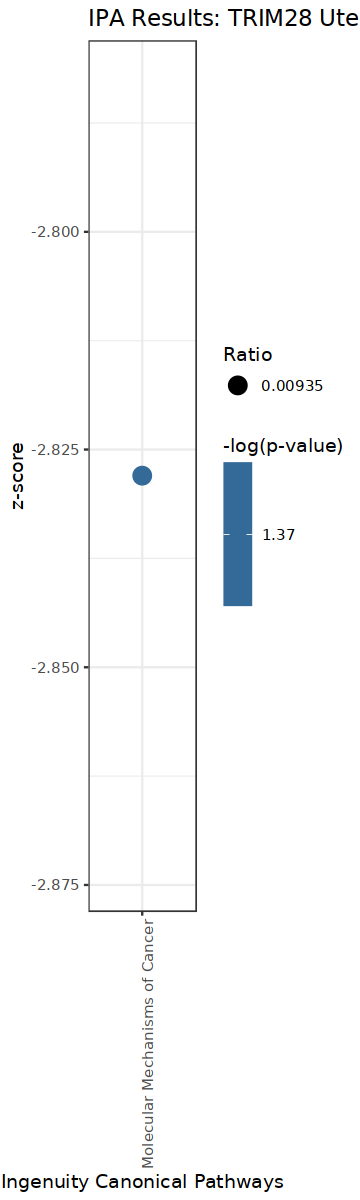

In [843]:
## Dot plot of pathways.

saved <- options(repr.plot.width = dim(muscle_pathways)[1] * 3, repr.plot.height = 10)
fig_muscle_pathways <- ipa_plot(muscle_pathways, "IPA Results: TRIM28 Uterine Muscle Cells, Flox vs. KO Mice")
fig_muscle_pathways
options(saved)

p_val         avg_log2FC pct.1 pct.2 p_val_adj    
Pdgfrb 2.941424e-103 1.841961   0.965 0.317  6.332298e-99
Cspg4  1.711108e-249 2.286559   0.937 0.104 3.683674e-245

p_val        avg_log2FC pct.1 pct.2 p_val_adj
Pgr    0.1356435451  0.3301355 0.389 0.294  1       
Trim28 0.0004399093 -0.4295527 0.269 0.588  1       
NA               NA         NA    NA    NA NA

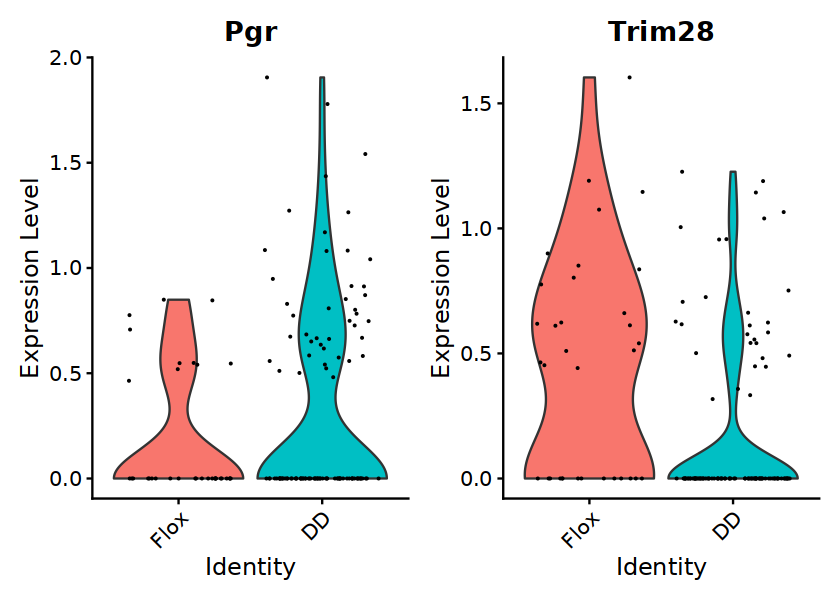

In [845]:
## Investigate cluster 18, which might be pericytes.

all_markers <- FindMarkers(trim28_tmp_clusters, ident.1 = 18)

# Print some pericyte markers.
(all_markers %>% filter(p_val_adj < 0.05) %>% arrange(desc(avg_log2FC)))[c("Pdgfrb","Cspg4"),]

# Look at PR+ TRIM28- subset, cluster 18 using graphs.
trim28_prko_subset <- subset(trim28, seurat_clusters == 18)
prko_markers <- FindMarkers(trim28_prko_subset, ident.1 = "D.18", ident.2 = "F.18")

saved <- options(repr.plot.width = 7, repr.plot.height = 5)
VlnPlot(trim28_prko_subset, features = c("Pgr","Trim28"), group.by = "orig.ident")
prko_markers[c("Pgr","Trim28","Esr1"),]
options(saved)

# Check the change in muscle cells between flox and knockout.
sum(trim28$singler_lineage == "Muscle" & trim28$orig.ident == "DD")
sum(trim28$singler_lineage == "Muscle" & trim28$orig.ident == "Flox")

# Perform a t-test on Trim28 expression between flox and KO subsets of cluster 18.
# Should corroborate the all_markers table earlier, albeit with slight differences.
dd_cells <- GetAssayData(trim28_prko_subset)["Trim28",colnames(trim28_prko_subset)[trim28_prko_subset$geno.cluster == "D.18"]]
flox_cells <- GetAssayData(trim28_prko_subset)["Trim28",colnames(trim28_prko_subset)[trim28_prko_subset$geno.cluster == "F.18"]]
t.test(dd_cells, flox_cells)

## Save all figures.
pdf("Figures/TRIM28-ClusterPathways.pdf", width = 22, height = 10)
fig_epi_pathways
fig_stromal_pathways
fig_muscle_pathways
dev.off()

# Step 5: Gene expression by cluster

Warning message:
“Groups with fewer than two data points have been dropped.”
Warning message:
“Groups with fewer than two data points have been dropped.”


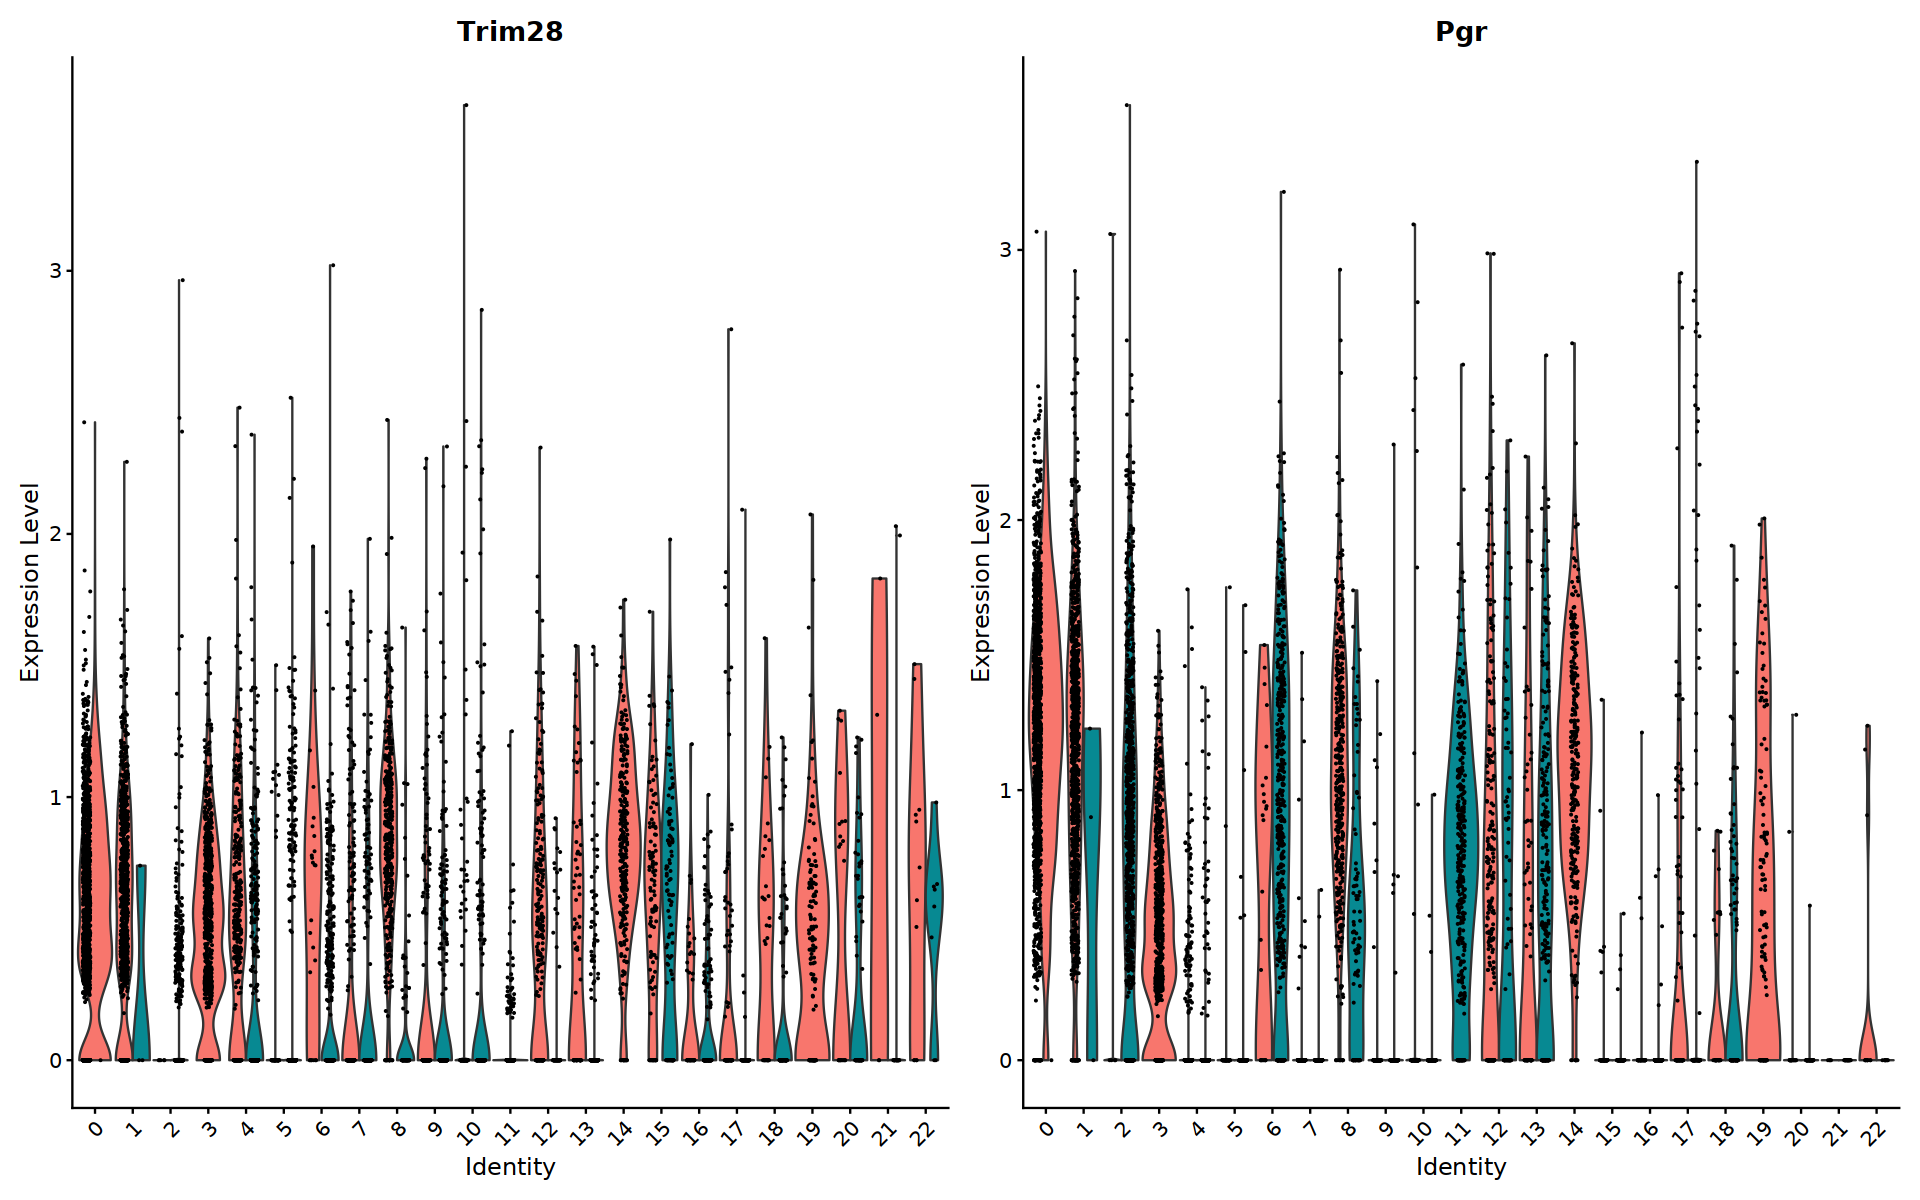

In [307]:
# Crude violin plots showing Trim28 and Pgr expression by cluster.
# Granular view.

trim28_wt <- subset(trim28, orig.ident == "Flox")
saved <- options(repr.plot.wdith = 30)
VlnPlot(trim28, features = c("Trim28", "Pgr"), group.by = "seurat_clusters", split.by = "orig.ident")
options(saved)

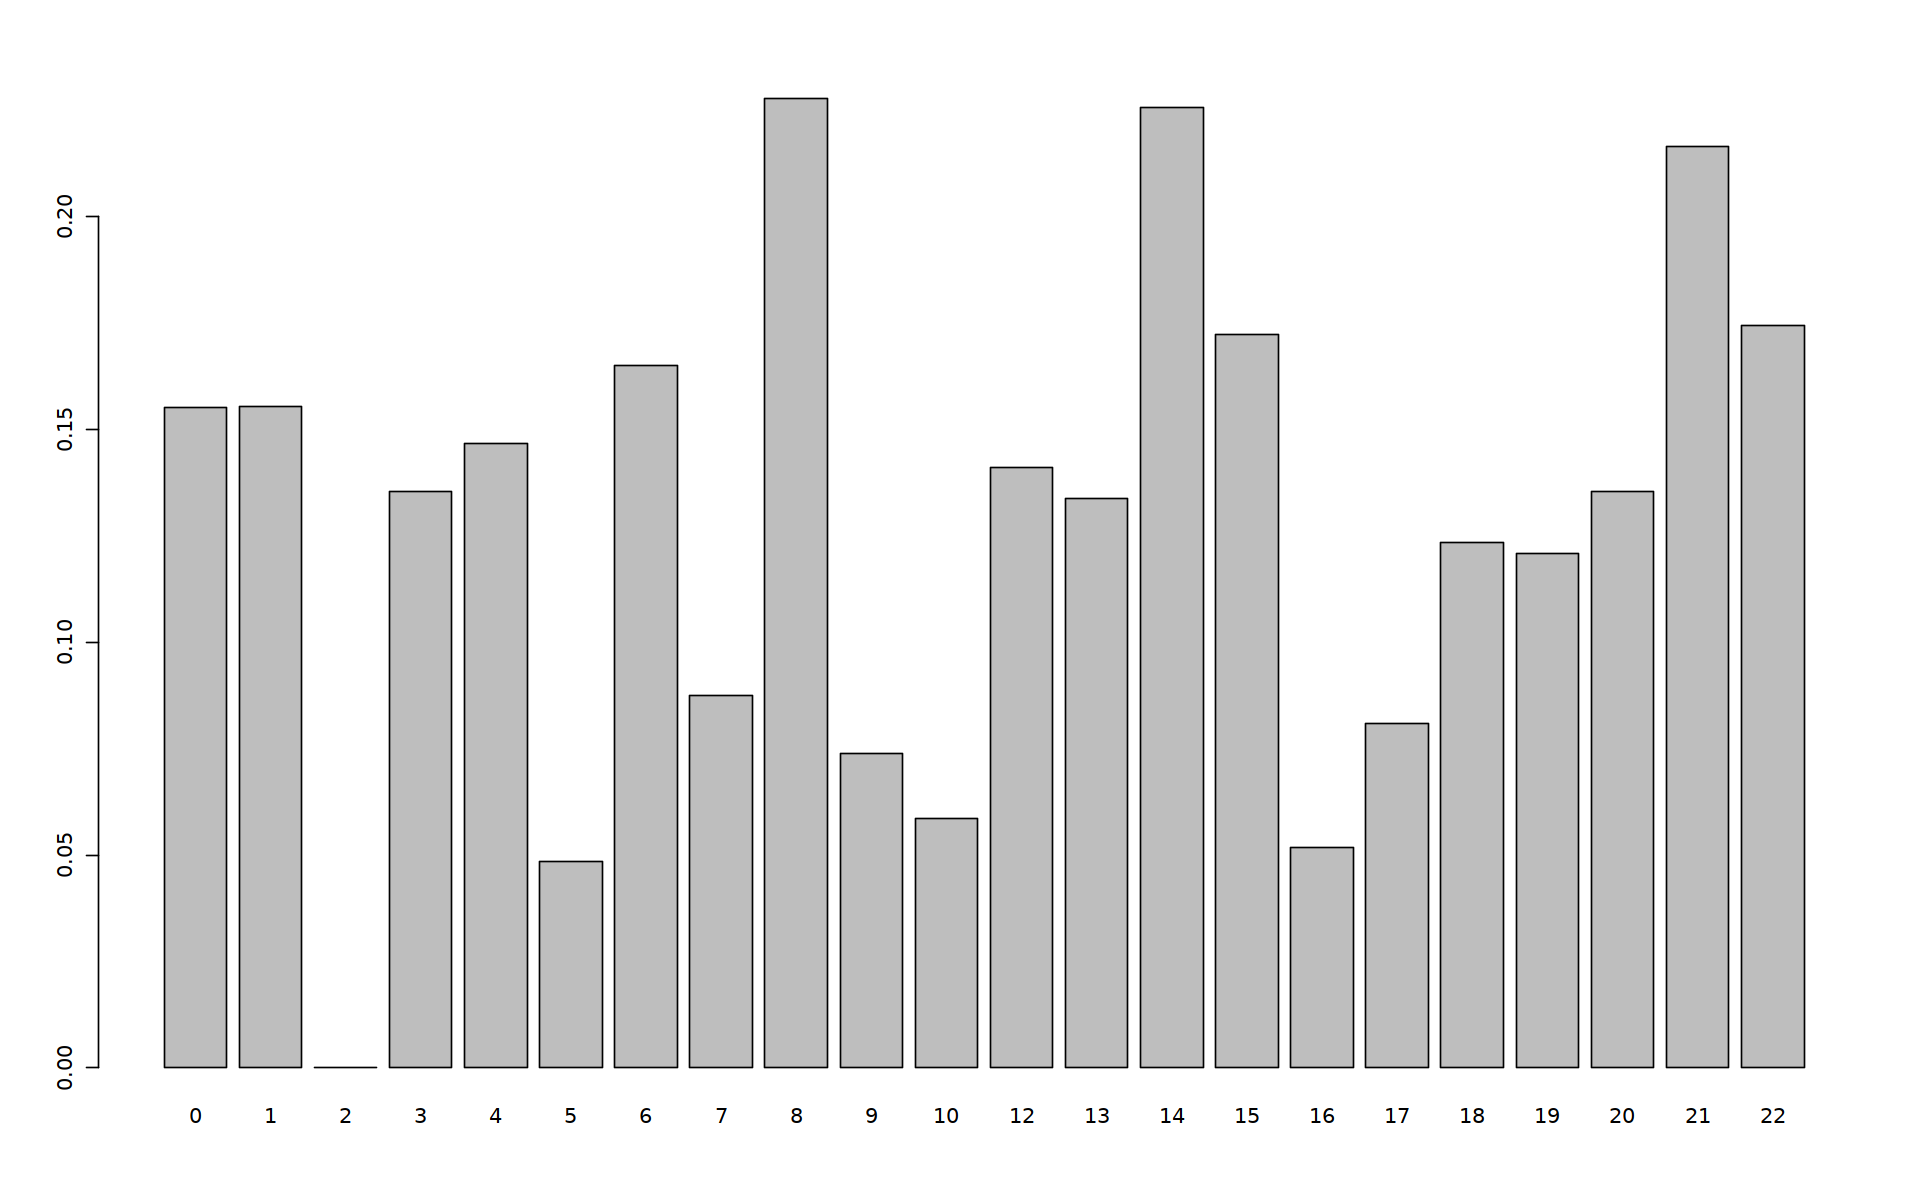

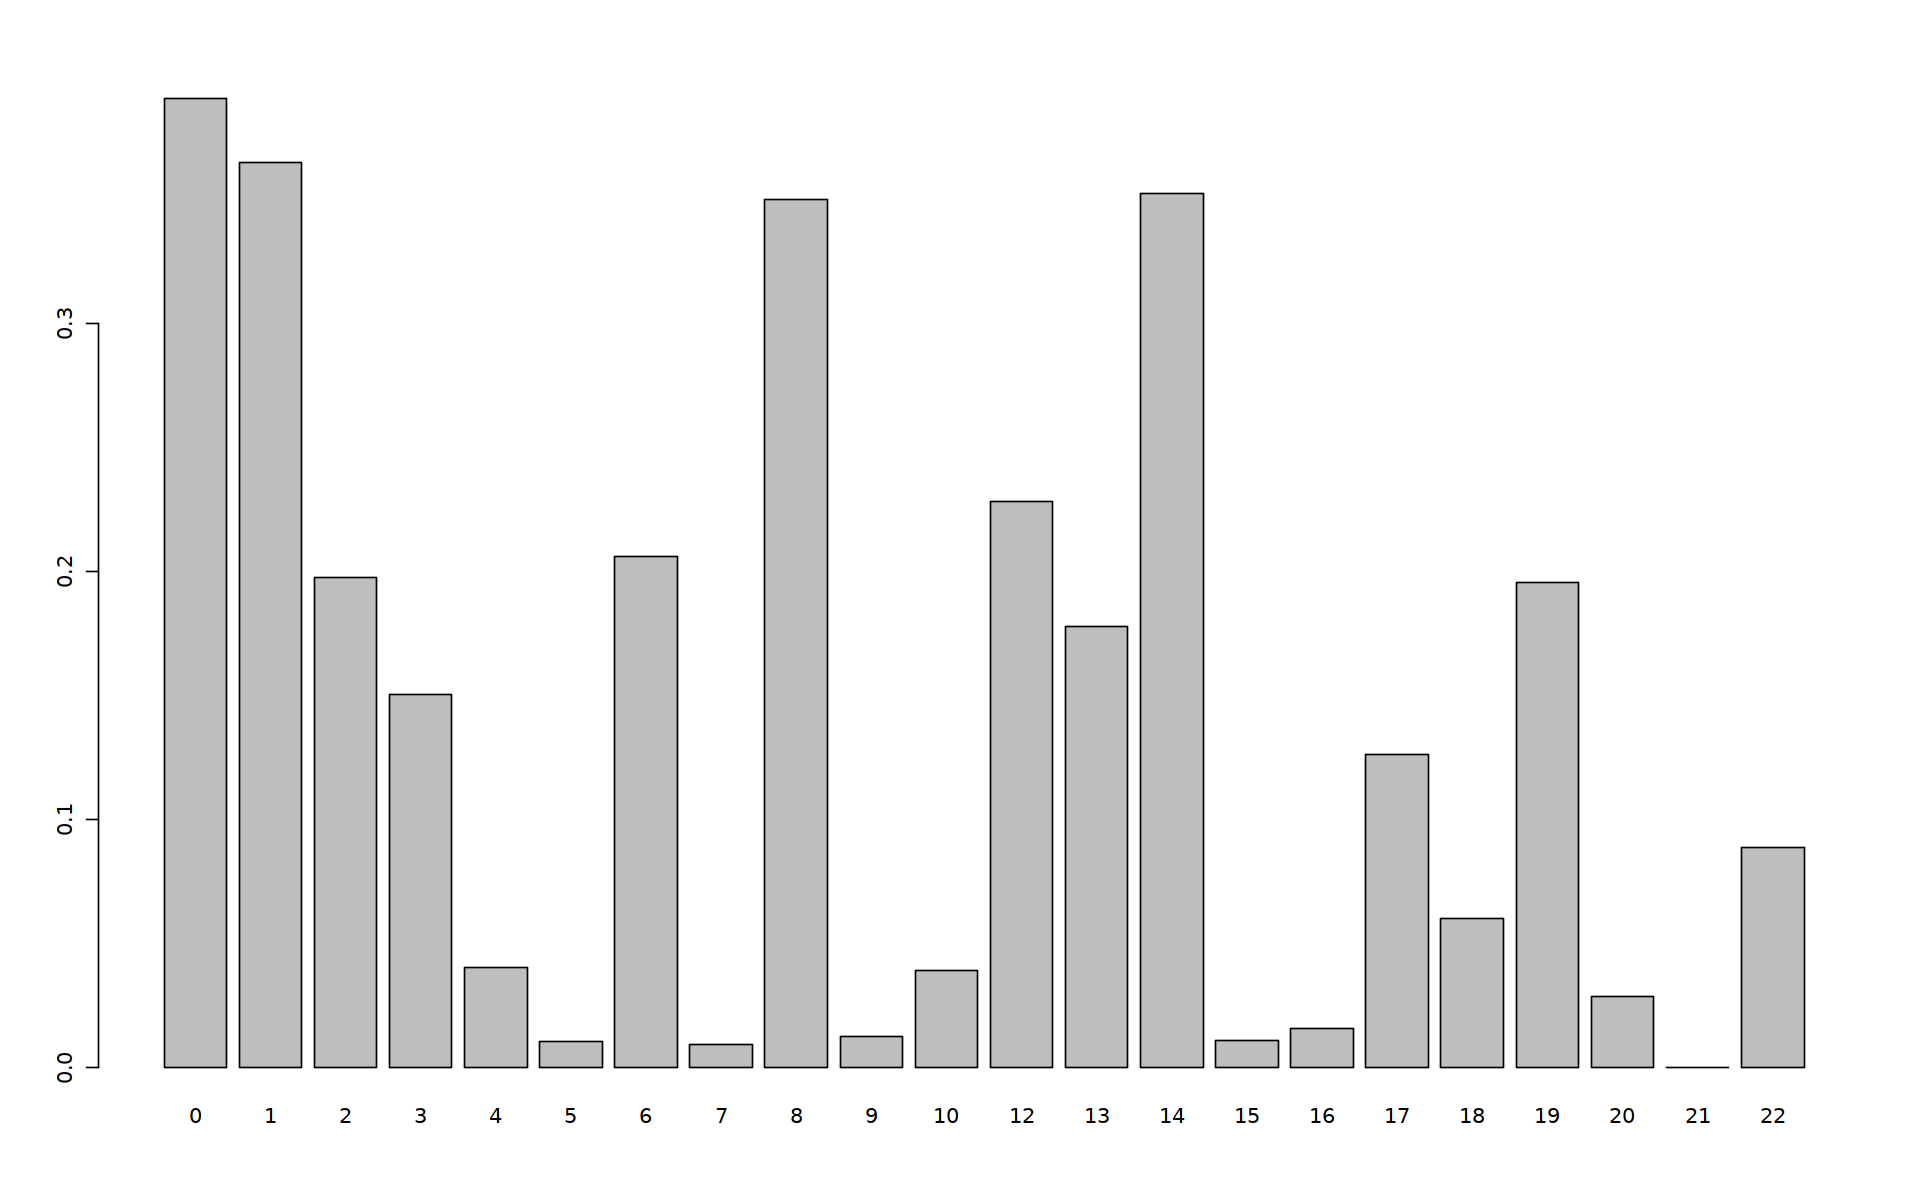

In [303]:
# Average Trim28 and Pgr expression levels by cluster.
# Can help with flagging clusters using cutoffs.

cluster_gene_expr_info <- cbind(as.data.frame(t(GetAssayData(trim28_wt)[c("Trim28", "Pgr"),])),
                                trim28_wt[["seurat_clusters"]]) %>%
    mutate(Trim28 = Trim28 / max(Trim28), Pgr = Pgr / max(Pgr)) %>%
    group_by(seurat_clusters) %>%
    summarize(Trim28_mean = mean(Trim28), Pgr_mean = mean(Pgr))

#cluster_gene_expr_info
barplot(cluster_gene_expr_info$Trim28_mean, names.arg = cluster_gene_expr_info$seurat_clusters)
barplot(cluster_gene_expr_info$Pgr_mean, names.arg = cluster_gene_expr_info$seurat_clusters)

In [945]:
# Find DEGs for clusters 4 and 18 in the KNOCKOUT clusters vs. FLOXED.

degs_cluster4_floxvko <- FindMarkers(trim28, ident.1 = "D.4", ident.2 = "F.4") %>% arrange(desc(avg_log2FC))
degs_cluster18_floxvko <- FindMarkers(trim28, ident.1 = "D.18", ident.2 = "F.18") %>% arrange(desc(avg_log2FC))

dim(degs_cluster4_floxvko %>% filter(p_val_adj < 0.05))
dim(degs_cluster18_floxvko %>% filter(p_val_adj < 0.05))
head(degs_cluster4_floxvko %>% filter(p_val_adj < 0.05))
head(degs_cluster18_floxvko %>% filter(p_val_adj < 0.05))

# Write the markers for cluster 4.
fwrite(x = degs_cluster4_floxvko %>% filter(p_val_adj < 0.05),
       file = "Data/MarkerGenes/TRIM28-DEGs-Cluster4-FloxvKO.csv",
       row.names = TRUE,
       col.names = TRUE)

# Write the markers for cluster 8.
fwrite(x = degs_cluster18_floxvko %>% filter(p_val_adj < 0.05),
       file = "Data/MarkerGenes/TRIM28-DEGs-Cluster18-FloxvKO.csv",
       row.names = TRUE,
       col.names = TRUE)

[1] 819   5

[1] 15  5

p_val        avg_log2FC pct.1 pct.2 p_val_adj   
Igkc  2.229241e-24 2.641490   0.734 0.565 4.799110e-20
Fos   1.875826e-15 1.933024   0.679 0.551 4.038277e-11
Igha  8.008900e-20 1.876689   0.640 0.435 1.724156e-15
Egr1  1.724465e-12 1.744448   0.637 0.571 3.712427e-08
Zfp36 5.903210e-15 1.521464   0.720 0.632 1.270843e-10
Iigp1 1.212621e-17 1.399366   0.821 0.778 2.610530e-13

p_val        avg_log2FC pct.1 pct.2 p_val_adj   
Rxfp1  6.379757e-08  1.3947329 0.889 0.647 1.373434e-03
Srsf5  1.039012e-06  0.7336606 0.963 0.824 2.236785e-02
Rps27  1.393781e-06  0.5232602 1.000 1.000 3.000531e-02
Ctla2a 4.316531e-07 -0.3411005 0.056 0.412 9.292629e-03
S100g  1.703926e-10 -0.3993350 0.009 0.382 3.668212e-06
Spink1 1.393415e-10 -0.4501471 0.000 0.353 2.999743e-06

In [944]:
# Find markers for clusters 4 and 18 in the FLOXED clusters only.

trim28_tmp <- subset(trim28, orig.ident == "Flox")
markers_cluster4_flox <- FindMarkers(trim28_tmp, ident.1 = "F.4") %>% arrange(desc(avg_log2FC))
markers_cluster18_flox <- FindMarkers(trim28_tmp, ident.1 = "F.18") %>% arrange(desc(avg_log2FC))

dim(markers_cluster4_flox %>% filter(p_val_adj < 0.05))
dim(markers_cluster18_flox %>% filter(p_val_adj < 0.05))
head(markers_cluster4_flox %>% filter(p_val_adj < 0.05))
head(markers_cluster18_flox %>% filter(p_val_adj < 0.05))

# Write the markers for cluster 4.
fwrite(x = markers_cluster4_flox %>% filter(p_val_adj < 0.05),
       file = "Data/MarkerGenes/TRIM28-MarkerGenes-Cluster4-FloxvKO.csv",
       row.names = TRUE,
       col.names = TRUE)

# Write the markers for cluster 8.
fwrite(x = markers_cluster18_flox %>% filter(p_val_adj < 0.05),
       file = "Data/MarkerGenes/TRIM28-MarkerGenes-Cluster18-FloxvKO.csv",
       row.names = TRUE,
       col.names = TRUE)

[1] 2228    5

[1] 932   5

p_val avg_log2FC pct.1 pct.2 p_val_adj
Cd93   0     3.247047   0.972 0.078 0        
Tm4sf1 0     3.108737   0.950 0.125 0        
Egfl7  0     3.079248   0.972 0.179 0        
Pecam1 0     3.025534   0.970 0.066 0        
Lrg1   0     2.968291   0.792 0.023 0        
Esam   0     2.874188   0.964 0.113 0

p_val         avg_log2FC pct.1 pct.2 p_val_adj    
Acta2   1.580855e-68 5.880046   1     0.119  3.403264e-64
Tagln   8.177608e-51 5.217174   1     0.172  1.760475e-46
Myl9    8.117254e-38 4.536988   1     0.259  1.747482e-33
Crip1   8.541260e-24 4.173854   1     0.779  1.838762e-19
Mustn1 1.127096e-184 4.173479   1     0.036 2.426413e-180
Myh11  1.302823e-134 4.122326   1     0.052 2.804717e-130

# Step 6: Mesenchymal cell single-cell plots

orig.ident nCount_RNA nFeature_RNA percent.mt
Flox_AAACCCAAGACCTGGA-1 Flox       17459      4390         6.037001  
Flox_AAACCCAAGCTCACTA-1 Flox       23797      4982         5.147708  
Flox_AAACCCAAGGTTGACG-1 Flox       26888      5165         5.400179  
Flox_AAACCCACAGCATCTA-1 Flox       23316      4601         6.141705  
Flox_AAACCCAGTAACGATA-1 Flox       17574      3950         6.219415  
Flox_AAACCCAGTAATCAGA-1 Flox       21345      4842         2.576716  
                        RNA_snn_res.0.5 seurat_clusters genotype geno.cluster
Flox_AAACCCAAGACCTGGA-1 8               8               F        F.8         
Flox_AAACCCAAGCTCACTA-1 12              12              F        F.12        
Flox_AAACCCAAGGTTGACG-1 0               0               F        F.0         
Flox_AAACCCACAGCATCTA-1 0               0               F        F.0         
Flox_AAACCCAGTAACGATA-1 1               1               F        F.1         
Flox_AAACCCAGTAATCAGA-1 13              13              F        F.13        
                        cell_type   singler_type singler_lineage
Flox_AAACCCAAGACCTGGA-1 Mesenchymal Fibroblast   Stromal        
Flox_AAACCCAAGCTCACTA-1 Mesenchymal Fibroblast   Stromal        
Flox_AAACCCAAGGTTGACG-1 Mesenchymal Fibroblast   Stromal        
Flox_AAACCCACAGCATCTA-1 Mesenchymal Fibroblast   Stromal        
Flox_AAACCCAGTAACGATA-1 Mesenchymal Fibroblast   Stromal        
Flox_AAACCCAGTAATCAGA-1 Mesenchymal Fibroblast   Stromal

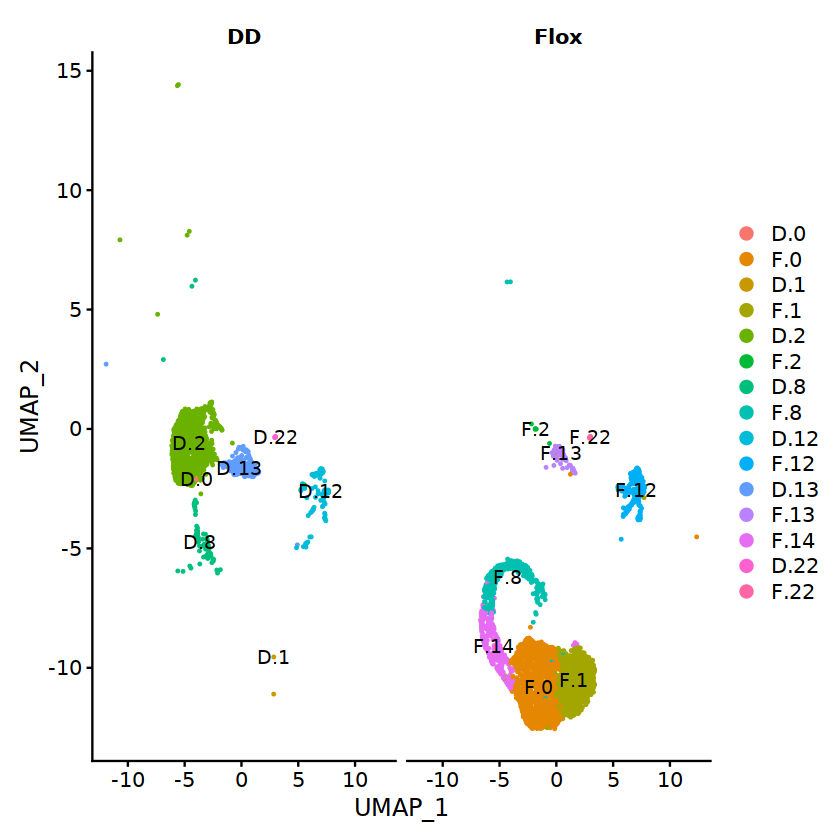

In [7]:
# Isolate the stromal cells.

trim28_stromal <- subset(trim28, singler_lineage %in% c("Stromal"))#, "Endothelial", "Immune", "Muscle"))
head(trim28_stromal[[]])
DimPlot(trim28_stromal, split.by = "orig.ident", label = TRUE)

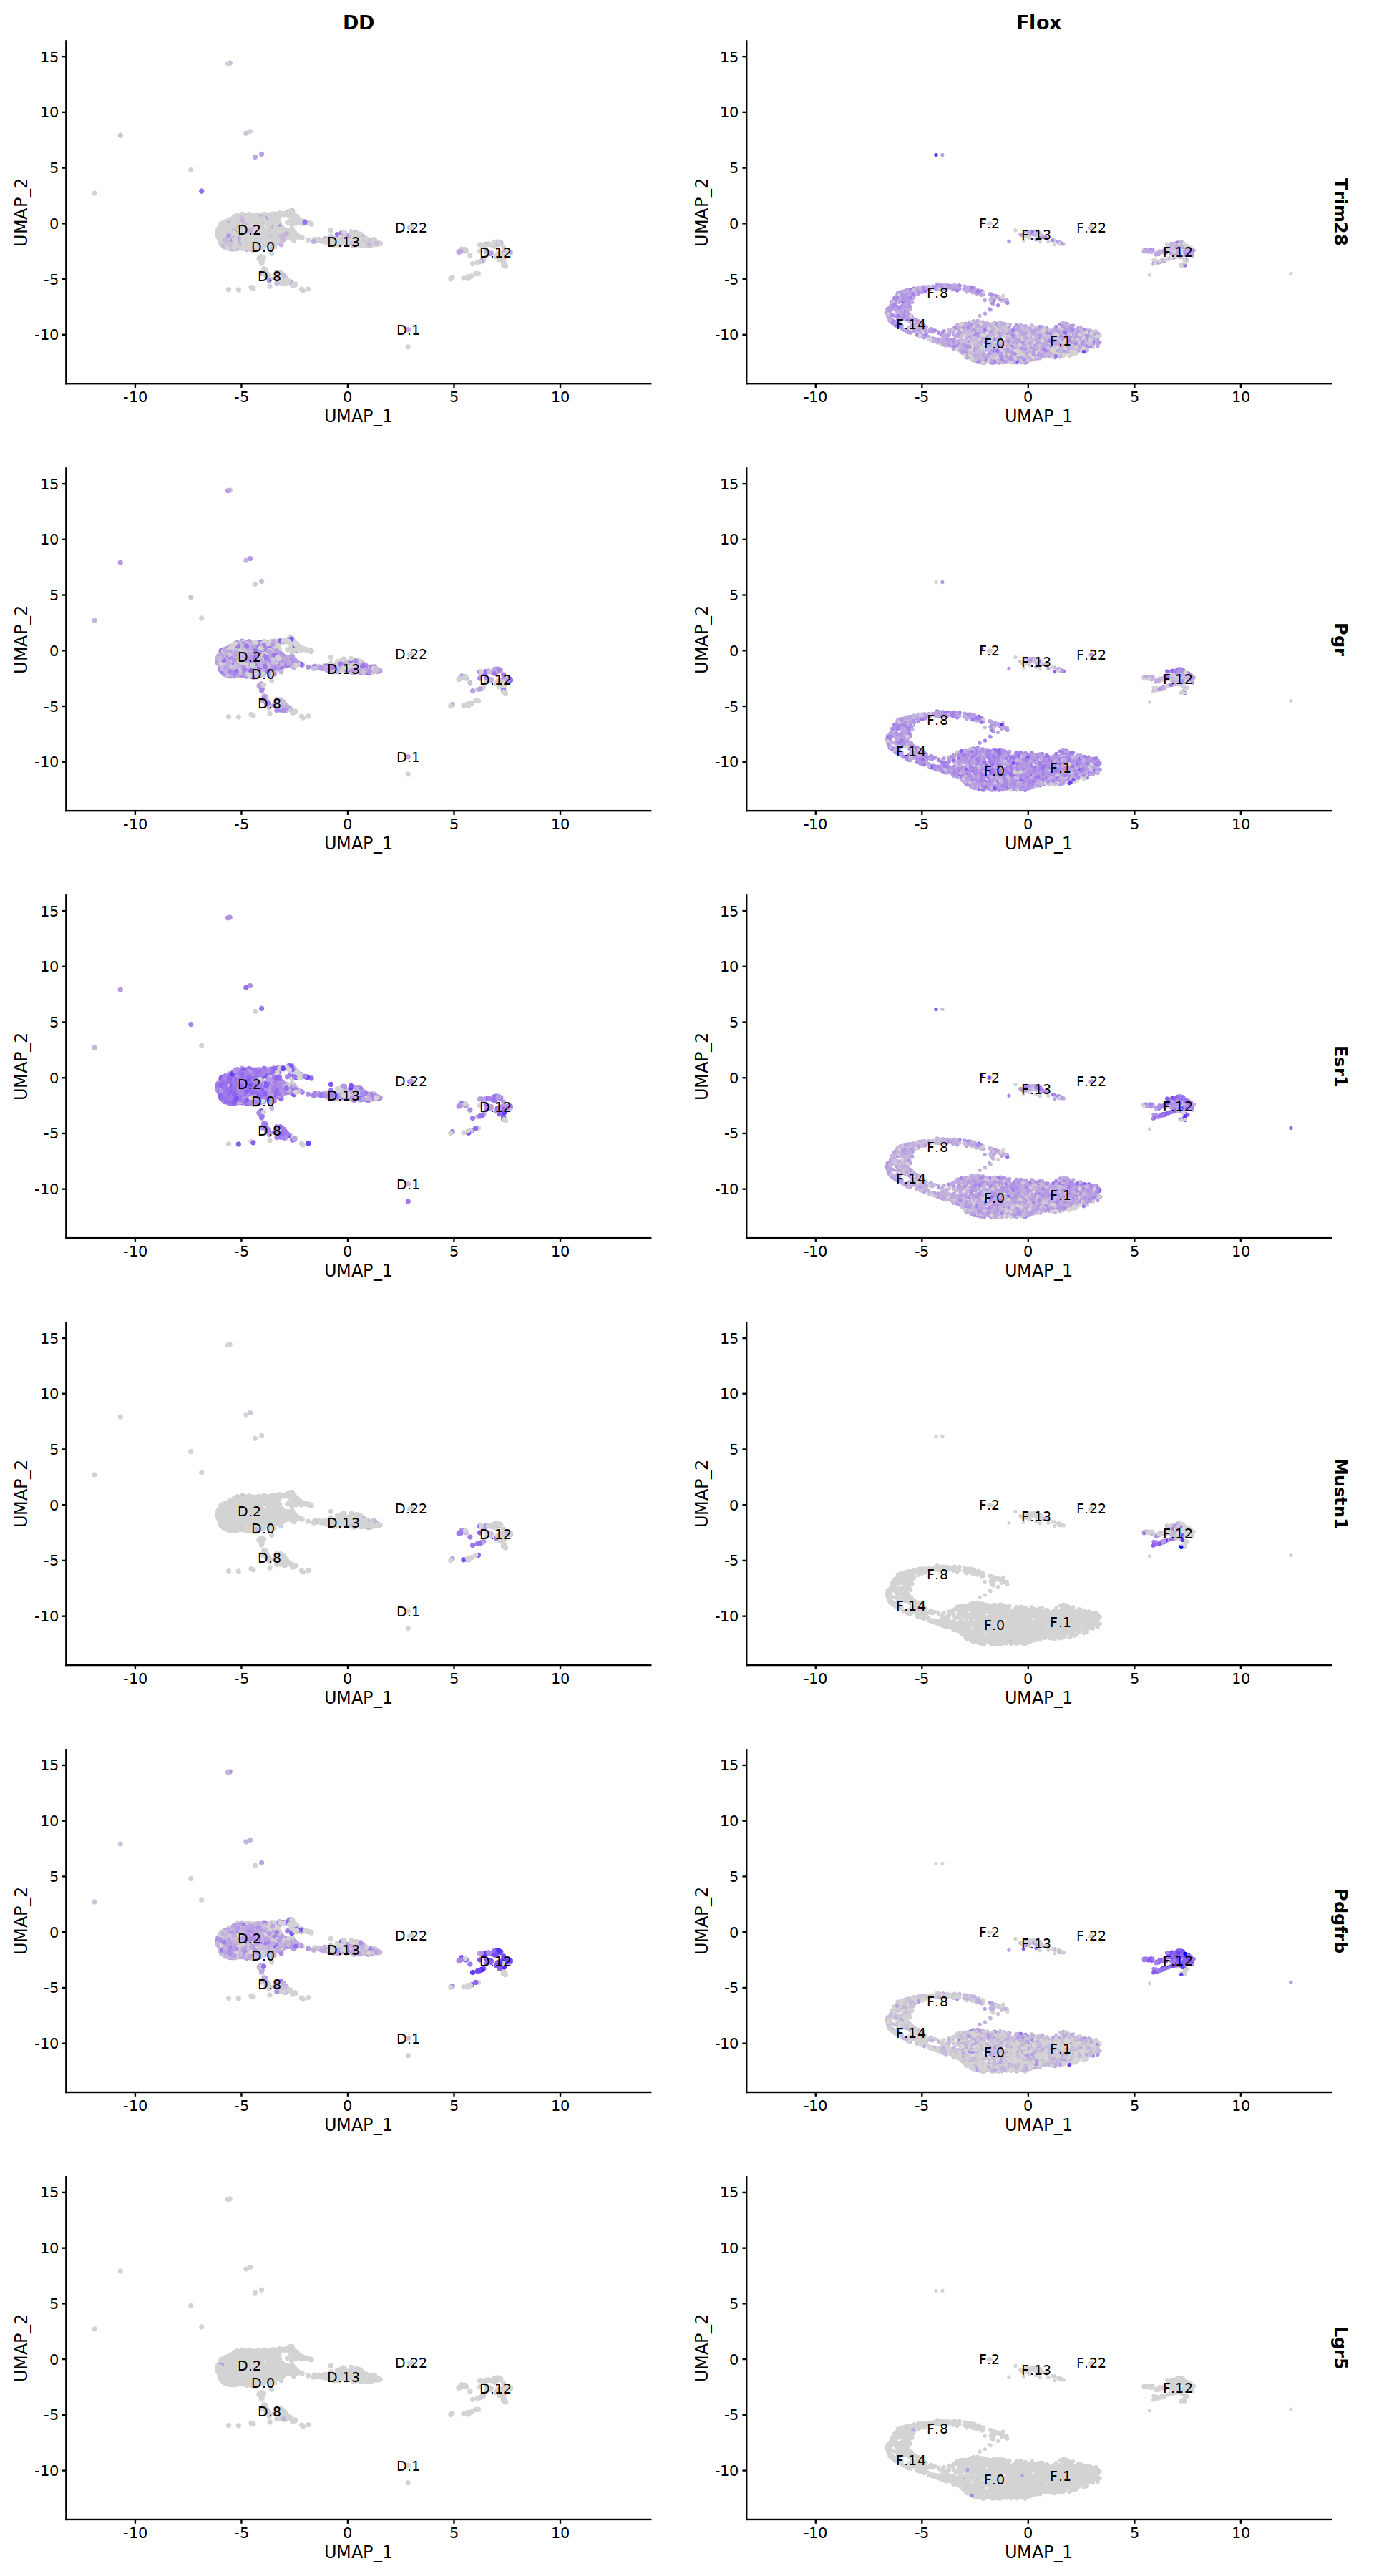

In [855]:
# Plot semantically meaningful genes.

saved <- options(repr.plot.width = 16, repr.plot.height = 30)
FeaturePlot(trim28_stromal, features = c("Trim28", "Pgr", "Esr1", "Mustn1", "Pdgfrb", "Lgr5"), split.by = "orig.ident", label = TRUE)
options(saved)

Warning message:
“Groups with fewer than two data points have been dropped.”


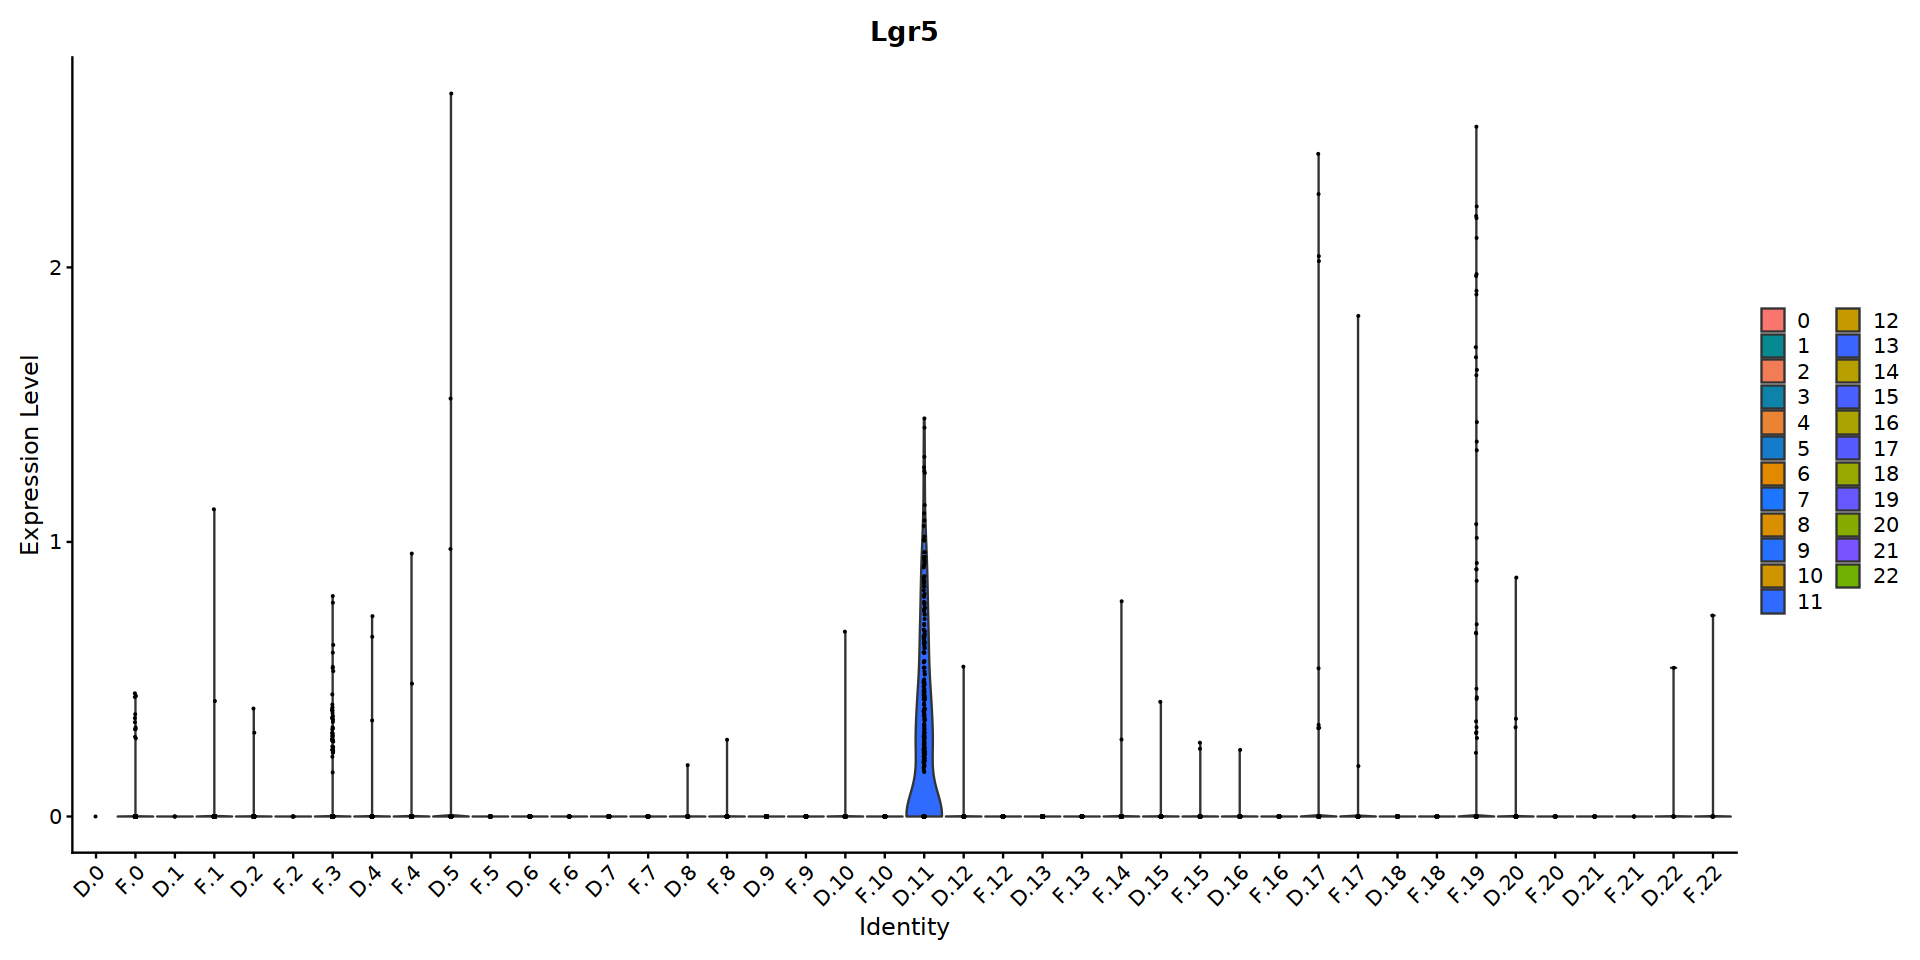

In [858]:
VlnPlot(trim28, split.by = 'seurat_clusters', features = "Lgr5")

In [860]:
pdf("Figures/Lgr5VlnPlots.pdf", width = 16, height = 8)
VlnPlot(trim28, split.by = 'seurat_clusters', features = "Lgr5")
dev.off()

Warning message:
“Groups with fewer than two data points have been dropped.”


png 
  2

In [210]:
# Save a subset of the plots above.

dir.create("Figures/")
pdf("Figures/TRIM28-SelectGeneExpressionLevels-4.pdf", width = 16, height = 8)
trim28_tmp <- trim28
Idents(trim28_tmp) <- "seurat_clusters"
FeaturePlot(trim28_tmp, features = "Trim28", split.by="orig.ident", label=FALSE, order=TRUE, repel=TRUE) + theme(legend.position = 'none')
FeaturePlot(trim28_tmp, features = "Pgr", split.by="orig.ident", label=FALSE, order=TRUE, repel=TRUE) + theme(legend.position = 'none')
FeaturePlot(trim28_tmp, features = "Esr1", split.by="orig.ident", label=FALSE, order=TRUE, repel=TRUE) + theme(legend.position = 'none')
dev.off()

Warning message in dir.create("Figures/"):
“'Figures' already exists”


png 
  2

In [9]:
# Rather than shooting blind, let's find the genes that have the greatest
# significance of difference between clusters.

trim28_stromal_tmp <- trim28_stromal
trim28_stromal_tmp$orig_v_lineage <- interaction(trim28_stromal_tmp$orig.ident, trim28_stromal_tmp$singler_lineage)
Idents(trim28_stromal_tmp) <- trim28_stromal_tmp$orig_v_lineage

stromal_changed_genes <- FindMarkers(trim28_stromal_tmp,
                                     ident.1 = "DD.Stromal",
                                     ident.2 = "Flox.Stromal") %>% filter(abs(avg_log2FC) > log2(1.5) & p_val_adj < 0.05) %>% 
                                                                   arrange(desc(avg_log2FC))
head(stromal_changed_genes)
tail(stromal_changed_genes)

p_val avg_log2FC pct.1 pct.2 p_val_adj
Col6a4 0     2.759987   0.918 0.627 0        
Prss23 0     2.650327   0.900 0.160 0        
Col1a1 0     2.452097   0.982 0.988 0        
A2m    0     2.421326   0.647 0.143 0        
Mfap4  0     2.377778   0.850 0.527 0        
Ogn    0     2.238965   0.852 0.400 0

p_val         avg_log2FC pct.1 pct.2 p_val_adj    
Angptl7 3.010453e-192 -1.484450  0.019 0.457 6.480904e-188
Maob     0.000000e+00 -1.559019  0.421 0.866  0.000000e+00
Igf1    1.981469e-298 -1.657024  0.741 0.929 4.265706e-294
Fst      0.000000e+00 -2.015997  0.044 0.736  0.000000e+00
Ctla2a  4.079854e-304 -2.079101  0.493 0.935 8.783109e-300
Rgs2     0.000000e+00 -2.869292  0.220 0.907  0.000000e+00

In [78]:
# Save the above table.

fwrite(stromal_changed_genes,
       "Data/MarkerGenes/TRIM28-MCA3.0StromalChangedGenes-PAdj<0.05+Log2FCAbs>Log21.5-NCBIRefSeq.csv",
       row.names = TRUE,
       col.names = TRUE)

# Step 7: Analysis of epithelial clusters

Warning message:
“Scaling data with a low number of groups may produce misleading results”
Warning message:
“Scaling data with a low number of groups may produce misleading results”


png 
  2

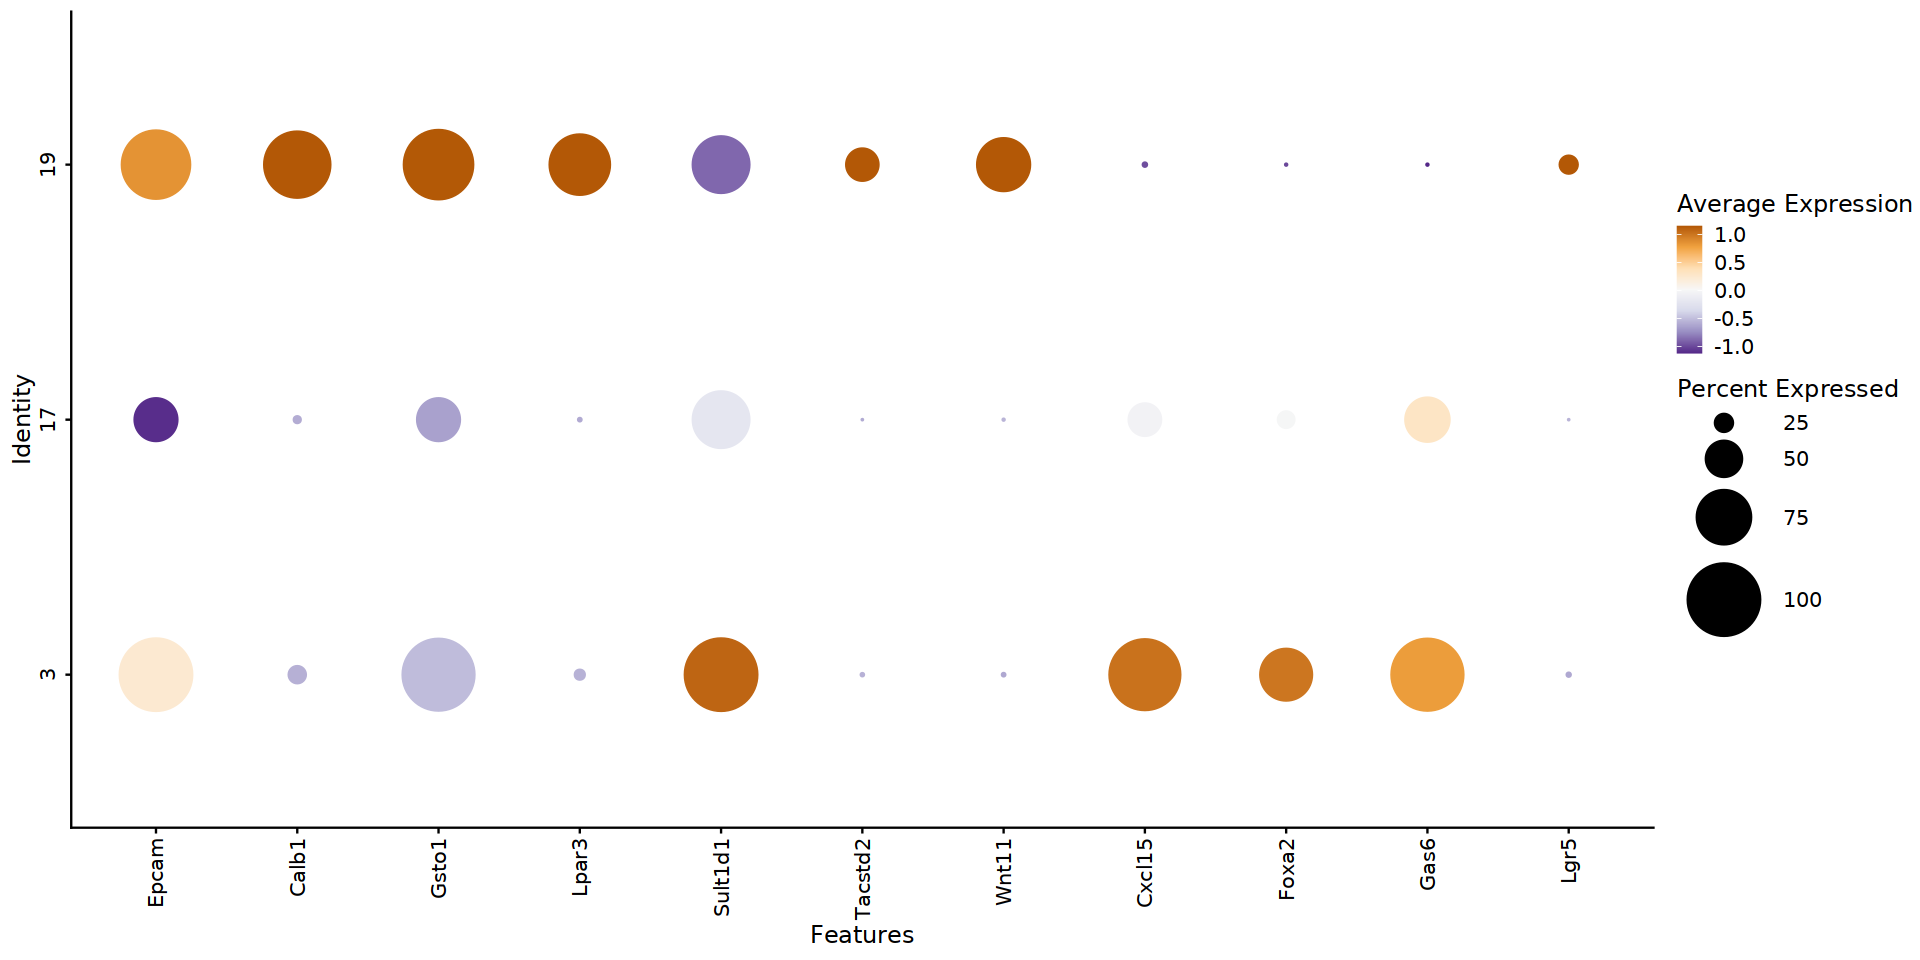

In [899]:
# Plot marker expression among wild-type TRIM28 epithelial clusters.

trim28_wt_tmp <- trim28_wt
Idents(trim28_wt_tmp) <- trim28_wt$seurat_clusters

DotPlot(subset(trim28_wt_tmp,
               idents = c(3, 17, 19)),
        features = c("Epcam", "Calb1", "Gsto1", "Lpar3", "Sult1d1", "Tacstd2", "Wnt11", "Cxcl15", "Foxa2", "Gas6", "Lgr5"),
        cols = "PuOr",
        dot.scale = 20) + theme(axis.text.x = element_text(angle = 90, hjust = 1, vjust = 0.5), axis.text.y = element_text(angle = 90, vjust = 1, hjust = 0.5))

#saved <- options(repr.plot.width = 7, repr.plot.height = 4)
pdf("Figures/TRIM28-EpithelialGEvsLEDotPlotsFlox.pdf", width = 7, height = 4)
DotPlot(subset(trim28_wt_tmp,
               idents = c(3, 17, 19)),
        features = c("Epcam", "Calb1", "Gsto1", "Lpar3", "Sult1d1", "Tacstd2", "Wnt11", "Cxcl15", "Foxa2", "Gas6", "Lgr5"),
        cols = "PuOr",
        dot.scale = 20) + theme(axis.text.x = element_text(angle = 90, hjust = 1, vjust = 0.5), axis.text.y = element_text(angle = 90, vjust = 1, hjust = 0.5))
# DotPlot(subset(trim28_wt_tmp,
#                idents = c(3, 17, 19)),
#         features = c("Epcam", "Calb1", "Gsto1", "Lpar3", "Sult1d1", "Tacstd2", "Wnt11", "Cxcl15", "Foxa2", "Gas6"),
#         cols = "Oranges") + theme(axis.text.x = element_text(angle = 90, hjust = 1, vjust = 0.5), axis.text.y = element_text(angle = 90, vjust = 1, hjust = 0.5))
# DotPlot(subset(trim28_wt_tmp,
#                idents = c(3, 17, 19)),
#         features = c("Epcam", "Calb1", "Gsto1", "Lpar3", "Sult1d1", "Tacstd2", "Wnt11", "Cxcl15", "Foxa2", "Gas6"),
#         cols = "Blues") + theme(axis.text.x = element_text(angle = 90, hjust = 1, vjust = 0.5), axis.text.y = element_text(angle = 90, vjust = 1, hjust = 0.5))
#options(saved)
dev.off()

Warning message:
“Scaling data with a low number of groups may produce misleading results”
Warning message:
“Scaling data with a low number of groups may produce misleading results”


png 
  2

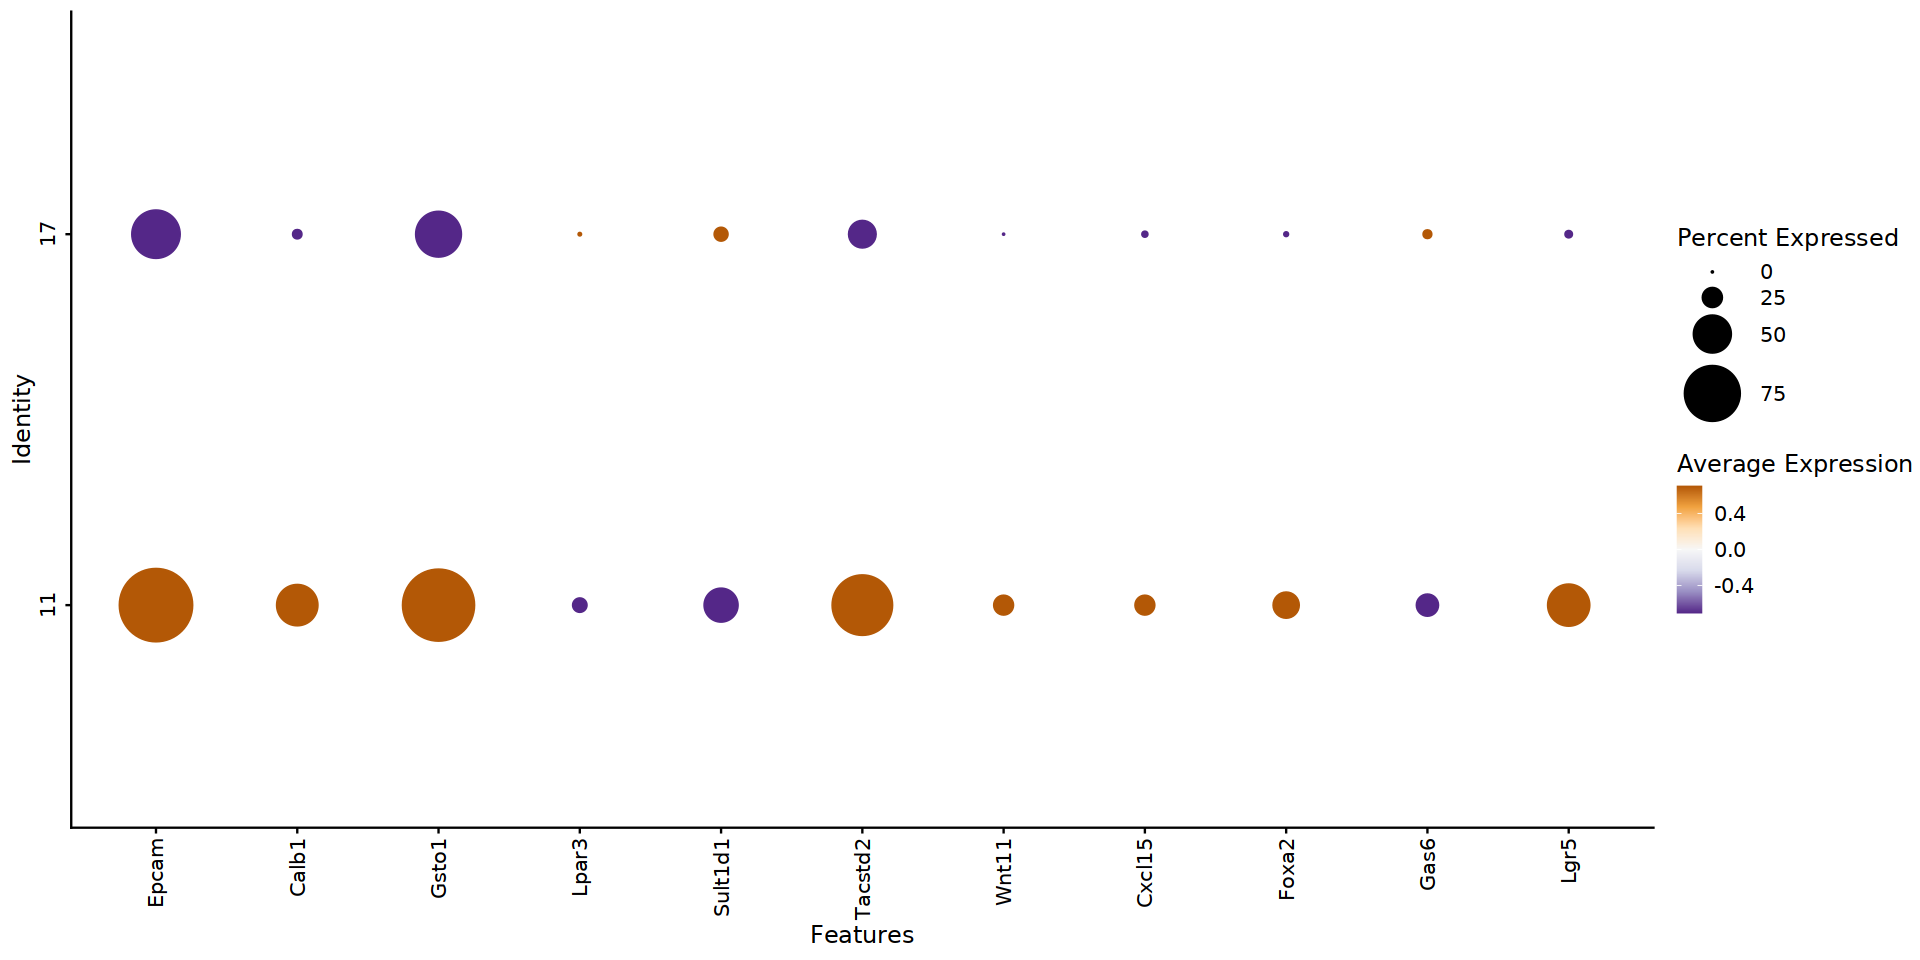

In [898]:
# Plot marker expression among knockout TRIM28 epithelial clusters.

trim28_dd_tmp <- subset(trim28, orig.ident == "DD")
Idents(trim28_dd_tmp) <- trim28_dd_tmp$seurat_clusters

DotPlot(subset(trim28_dd_tmp,
               idents = c(11, 17)),
        features = c("Epcam", "Calb1", "Gsto1", "Lpar3", "Sult1d1", "Tacstd2", "Wnt11", "Cxcl15", "Foxa2", "Gas6", "Lgr5"),
        cols = "PuOr",
        dot.scale = 20) + theme(axis.text.x = element_text(angle = 90, hjust = 1, vjust = 0.5), axis.text.y = element_text(angle = 90, vjust = 1, hjust = 0.5))

#saved <- options(repr.plot.width = 7, repr.plot.height = 4)
pdf("Figures/TRIM28-EpithelialGEvsLEDotPlotsDD.pdf", width = 7, height = 4)
DotPlot(subset(trim28_dd_tmp,
               idents = c(11, 17)),
        features = c("Epcam", "Calb1", "Gsto1", "Lpar3", "Sult1d1", "Tacstd2", "Wnt11", "Cxcl15", "Foxa2", "Gas6", "Lgr5"),
        cols = "PuOr",
        dot.scale = 20) + theme(axis.text.x = element_text(angle = 90, hjust = 1, vjust = 0.5), axis.text.y = element_text(angle = 90, vjust = 1, hjust = 0.5))
# DotPlot(subset(trim28_dd_tmp,
#                idents = c(11, 17)),
#         features = c("Epcam", "Calb1", "Gsto1", "Lpar3", "Sult1d1", "Tacstd2", "Wnt11", "Cxcl15", "Foxa2", "Gas6"),
#         cols = "Oranges") + theme(axis.text.x = element_text(angle = 90, hjust = 1, vjust = 0.5), axis.text.y = element_text(angle = 90, vjust = 1, hjust = 0.5))
# DotPlot(subset(trim28_dd_tmp,
#                idents = c(11, 17)),
#         features = c("Epcam", "Calb1", "Gsto1", "Lpar3", "Sult1d1", "Tacstd2", "Wnt11", "Cxcl15", "Foxa2", "Gas6"),
#         cols = "Blues") + theme(axis.text.x = element_text(angle = 90, hjust = 1, vjust = 0.5), axis.text.y = element_text(angle = 90, vjust = 1, hjust = 0.5))
#options(saved)
dev.off()

Warning message:
“Scaling data with a low number of groups may produce misleading results”


png 
  2

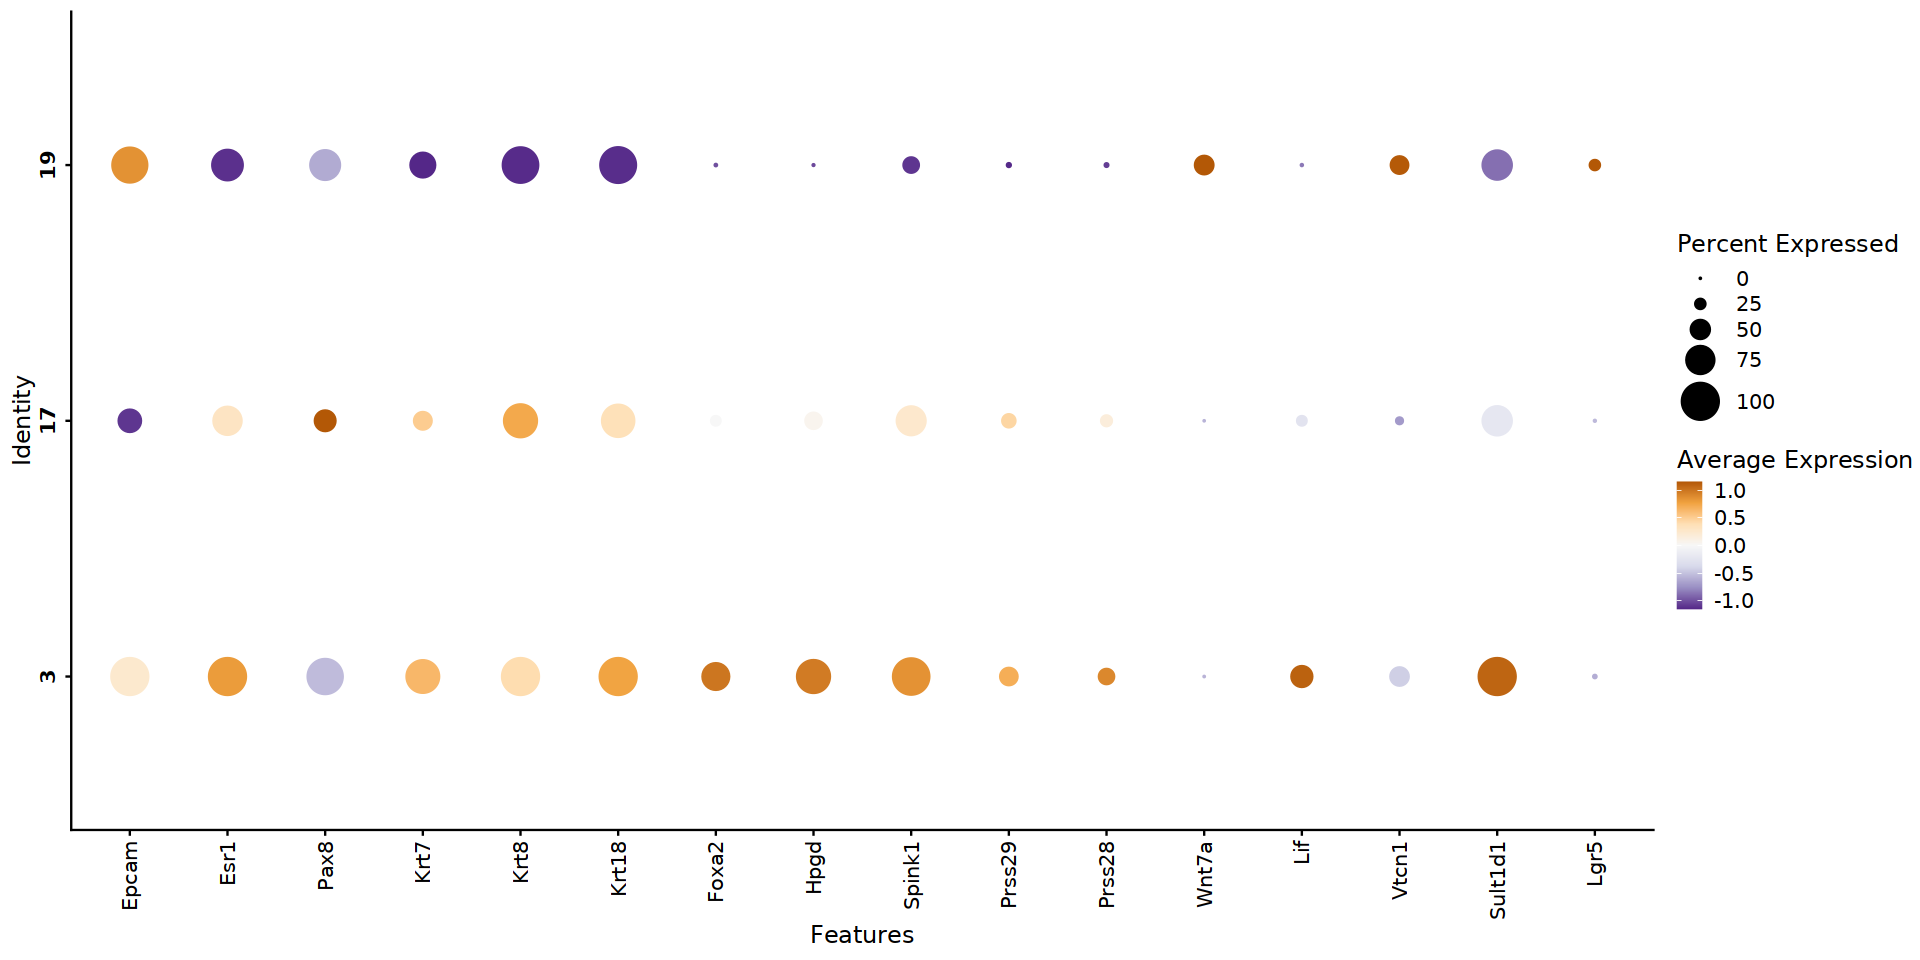

In [925]:
# Plot marker expression among wild-type TRIM28 epithelial clusters.

trim28_wt_tmp <- trim28_wt
Idents(trim28_wt_tmp) <- trim28_wt$seurat_clusters
markers <- c("Epcam", "Esr1", "Pax8", "Krt7", "Krt8", "Krt18", # epithelial
             "Foxa2","Hpgd", "Spink1", "Prss29", "Prss28", # GE
             "Wnt7a", "Lif", "Vtcn1", "Sult1d1", "Lgr5") # LE

plt <- DotPlot(subset(trim28_wt_tmp, idents = c(3, 17, 19)),
               features = markers,
               cols = "PuOr",
               dot.scale = 10) + theme(axis.text.x = element_text(angle = 90,
                                                                  hjust = 1,
                                                                  vjust = 0.5,,
                                                                  face = "italic"),
                                       axis.text.y = element_text(angle = 90,
                                                                  vjust = 1,
                                                                  hjust = 0.5,
                                                                  face = "bold"))
plt

pdf("Figures/TRIM28-EpithelialGEvsLEDotPlotsFlox-ExtendedMarkers-3.pdf", width = 7, height = 4)
plt
dev.off()

Warning message:
“Scaling data with a low number of groups may produce misleading results”


png 
  2

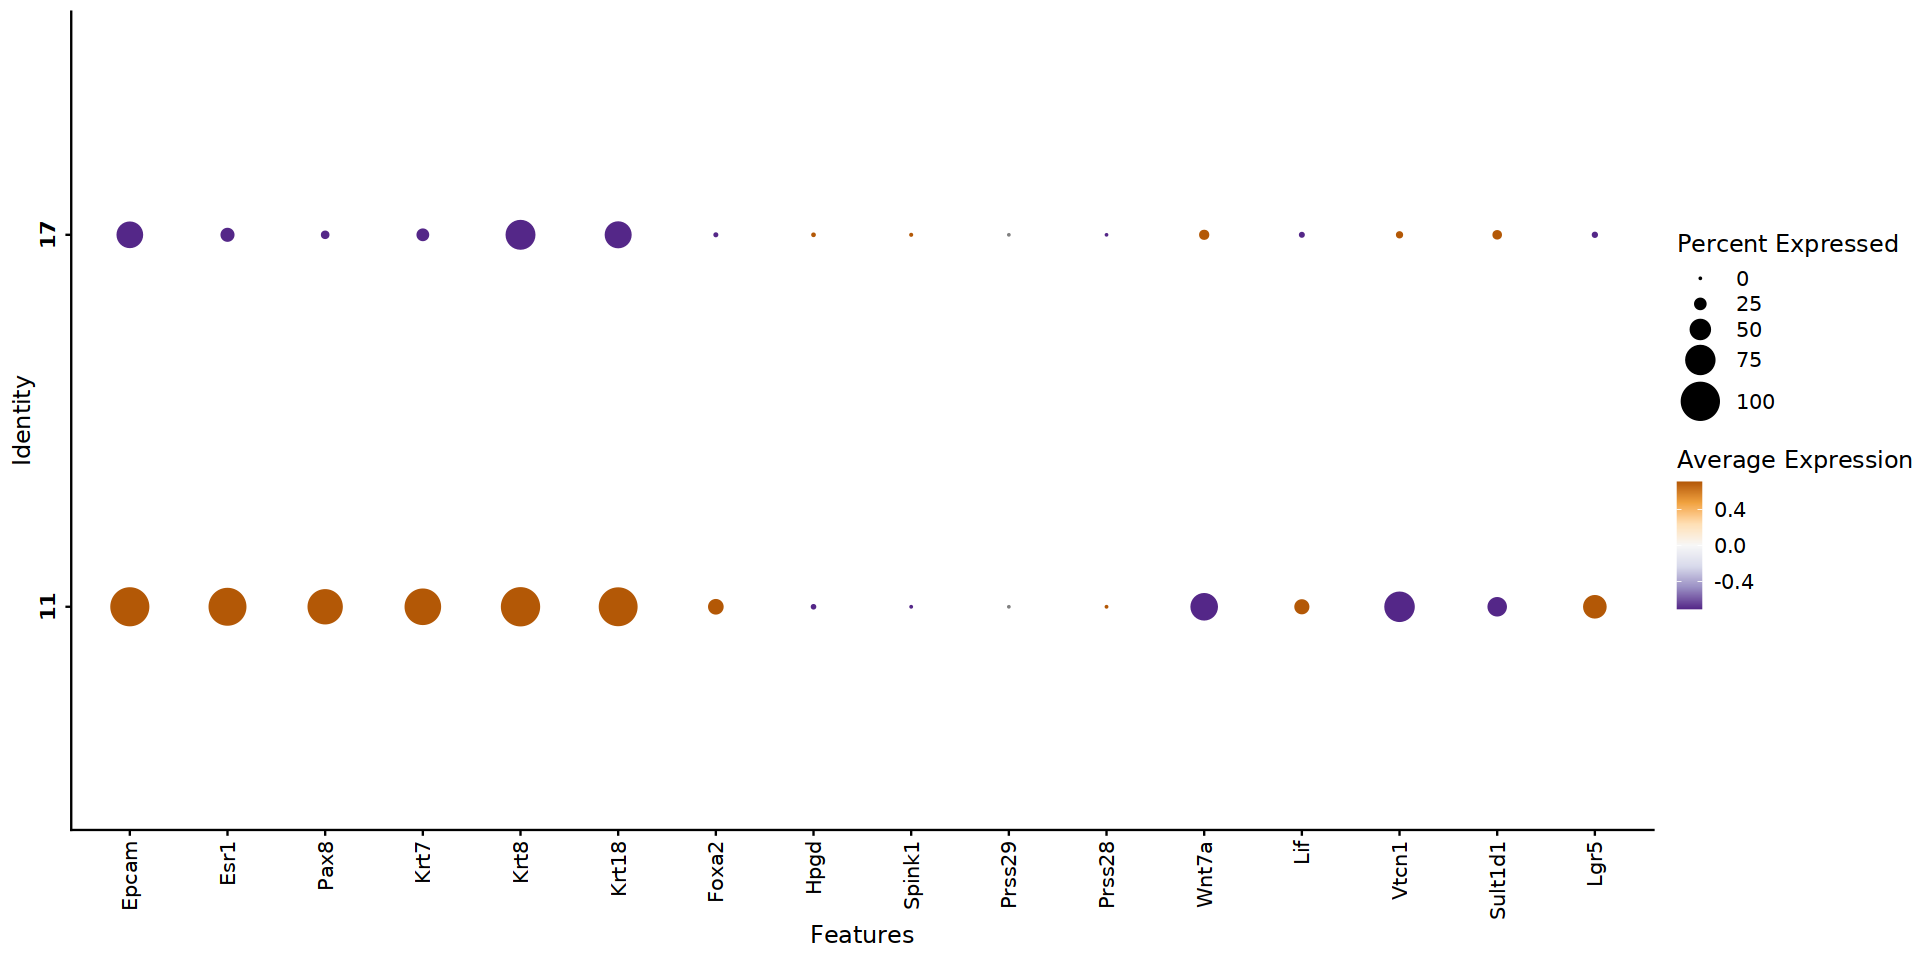

In [926]:
# Plot marker expression among wild-type TRIM28 epithelial clusters.

trim28_dd_tmp <- subset(trim28, orig.ident == "DD")
Idents(trim28_dd_tmp) <- trim28_dd_tmp$seurat_clusters
markers <- c("Epcam", "Esr1", "Pax8", "Krt7", "Krt8", "Krt18", # epithelial
             "Foxa2", "Hpgd", "Spink1", "Prss29", "Prss28", # GE
             "Wnt7a", "Lif", "Vtcn1", "Sult1d1", "Lgr5") # LE

plt <- DotPlot(subset(trim28_dd_tmp, idents = c(11, 17)),
               features = markers,
               cols = "PuOr",
               dot.scale = 10) + theme(axis.text.x = element_text(angle = 90,
                                                                  hjust = 1,
                                                                  vjust = 0.5,
                                                                  face = "italic"),
                                       axis.text.y = element_text(angle = 90,
                                                                  vjust = 1,
                                                                  hjust = 0.5,
                                                                  face = "bold"))
plt

pdf("Figures/TRIM28-EpithelialGEvsLEDotPlotsDD-ExtendedMarkers-3.pdf", width = 7, height = 4)
plt
dev.off()

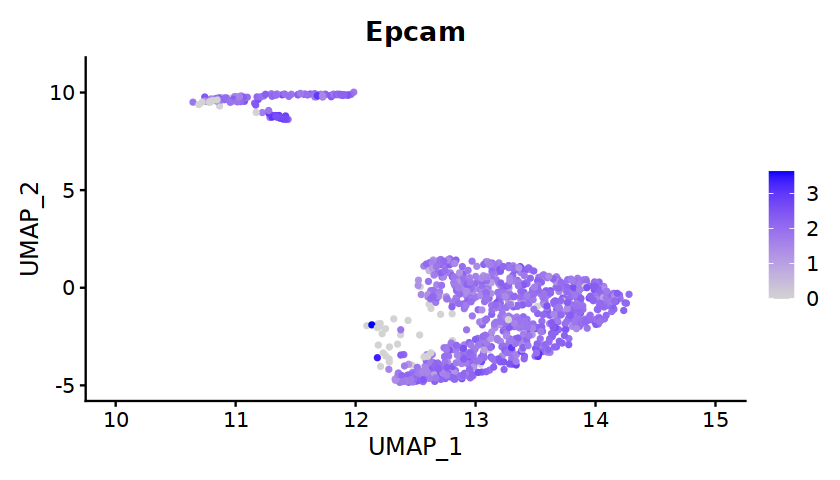

In [771]:
# Plot expression of Epcam across all identified epithelial cells.

FeaturePlot(subset(trim28_wt_tmp, idents = c(3, 17, 19)), features = c("Epcam"))

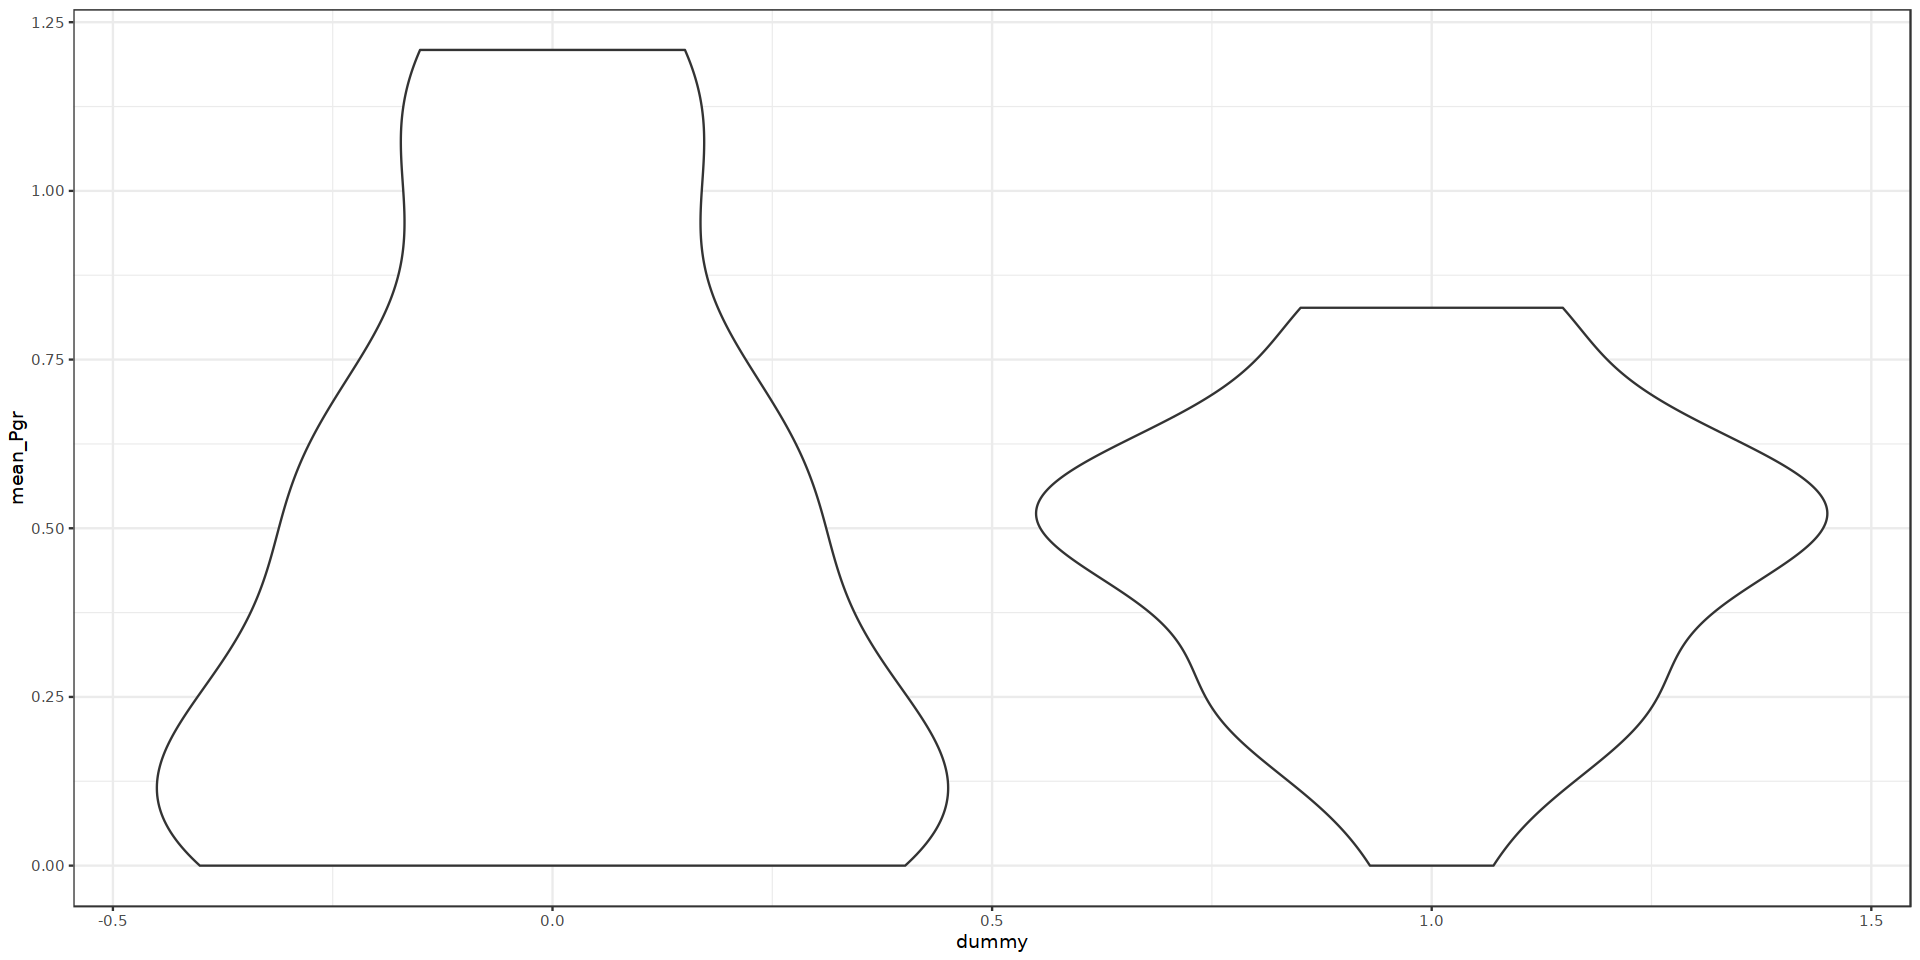

png 
  2

png 
  2

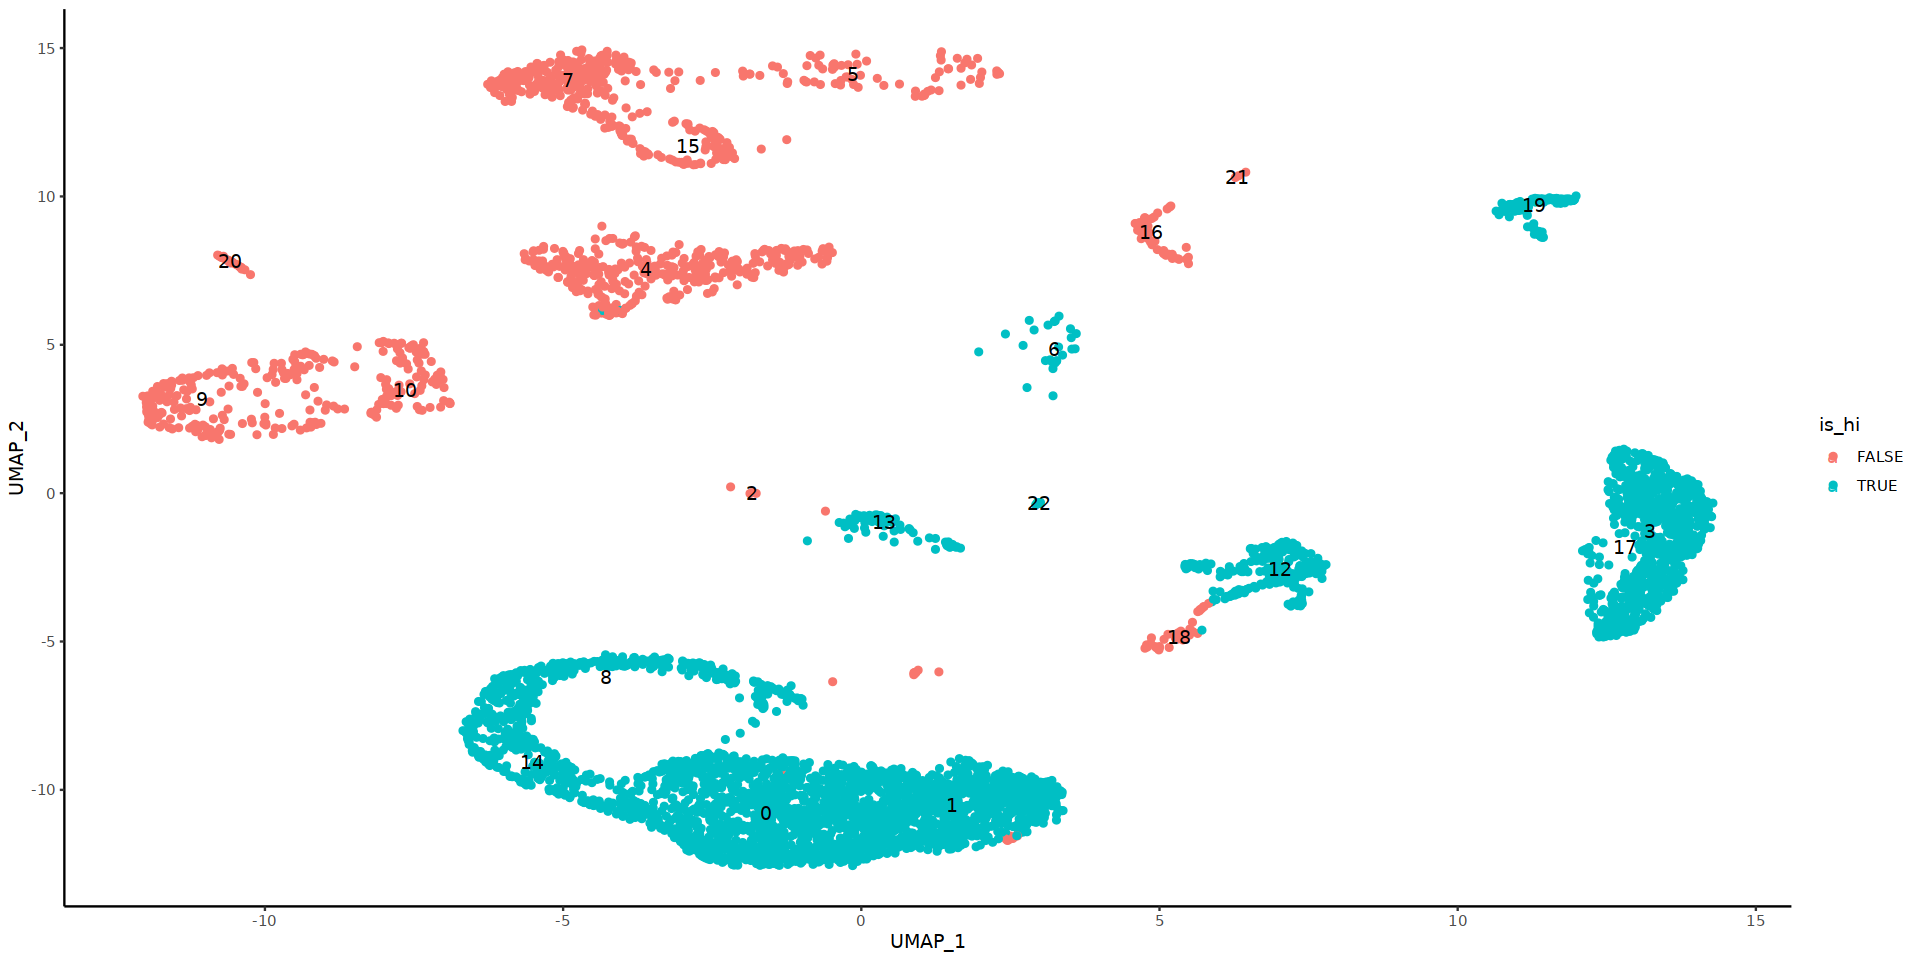

In [850]:
# Show distribution of Trim28 and Pgr expression (respectively) for WILD-TYPE clusters.
# Cutoff is arbitrary. Need a better method for that.

pts <- as.data.frame(Embeddings(trim28_wt_tmp, reduction = "umap"))
pgr_trim28_pos <- t(GetAssayData(trim28_wt_tmp)[c("Trim28","Pgr"),])
pts <- cbind(pts, pgr_trim28_pos)
pts$cluster <- trim28_wt_tmp$seurat_clusters
cluster_expr_agg <- pts %>% group_by(cluster) %>% summarize(UMAP_1 = median(UMAP_1), UMAP_2 = median(UMAP_2), mean_Pgr = mean(Pgr), mean_Trim28 = mean(Trim28))
cluster_expr_agg_filt <- cluster_expr_agg %>% filter(mean_Pgr > 0.2 & mean_Trim28 > 0.2)
hi_clusters <- cluster_expr_agg_filt$cluster
pts$is_hi <- pts$cluster %in% hi_clusters

# Show distributions of Trim28 and Pgr expression across all clusters.
dist_plt <- ggplot(cluster_expr_agg %>% mutate(dummy = 0, dummy2 = 1)) + 
    geom_violin(aes(x = dummy, y = mean_Pgr)) + 
    geom_violin(aes(x = dummy2, y = mean_Trim28)) +
    theme_bw()

# Plot high-Trim28 and high-Pgr clusters (blue) and low (red).
point_plt <- ggplot(data = pts, aes(x = UMAP_1, y = UMAP_2, color = is_hi, label = cluster)) + geom_point() + theme_classic() + 
                 geom_text(data = cluster_expr_agg, aes(label = cluster, color = NULL))

dist_plt
point_plt

# Save the above two plots.
pdf("Figures/TRIM28-Trim28PgrNegvsPos_PointPlot.pdf", width = 12, height = 8)
point_plt
dev.off()

pdf("Figures/TRIM28-Trim28PgrNegvsPos_DistPlot.pdf", width = 5, height = 8)
dist_plt
dev.off()

png 
  2

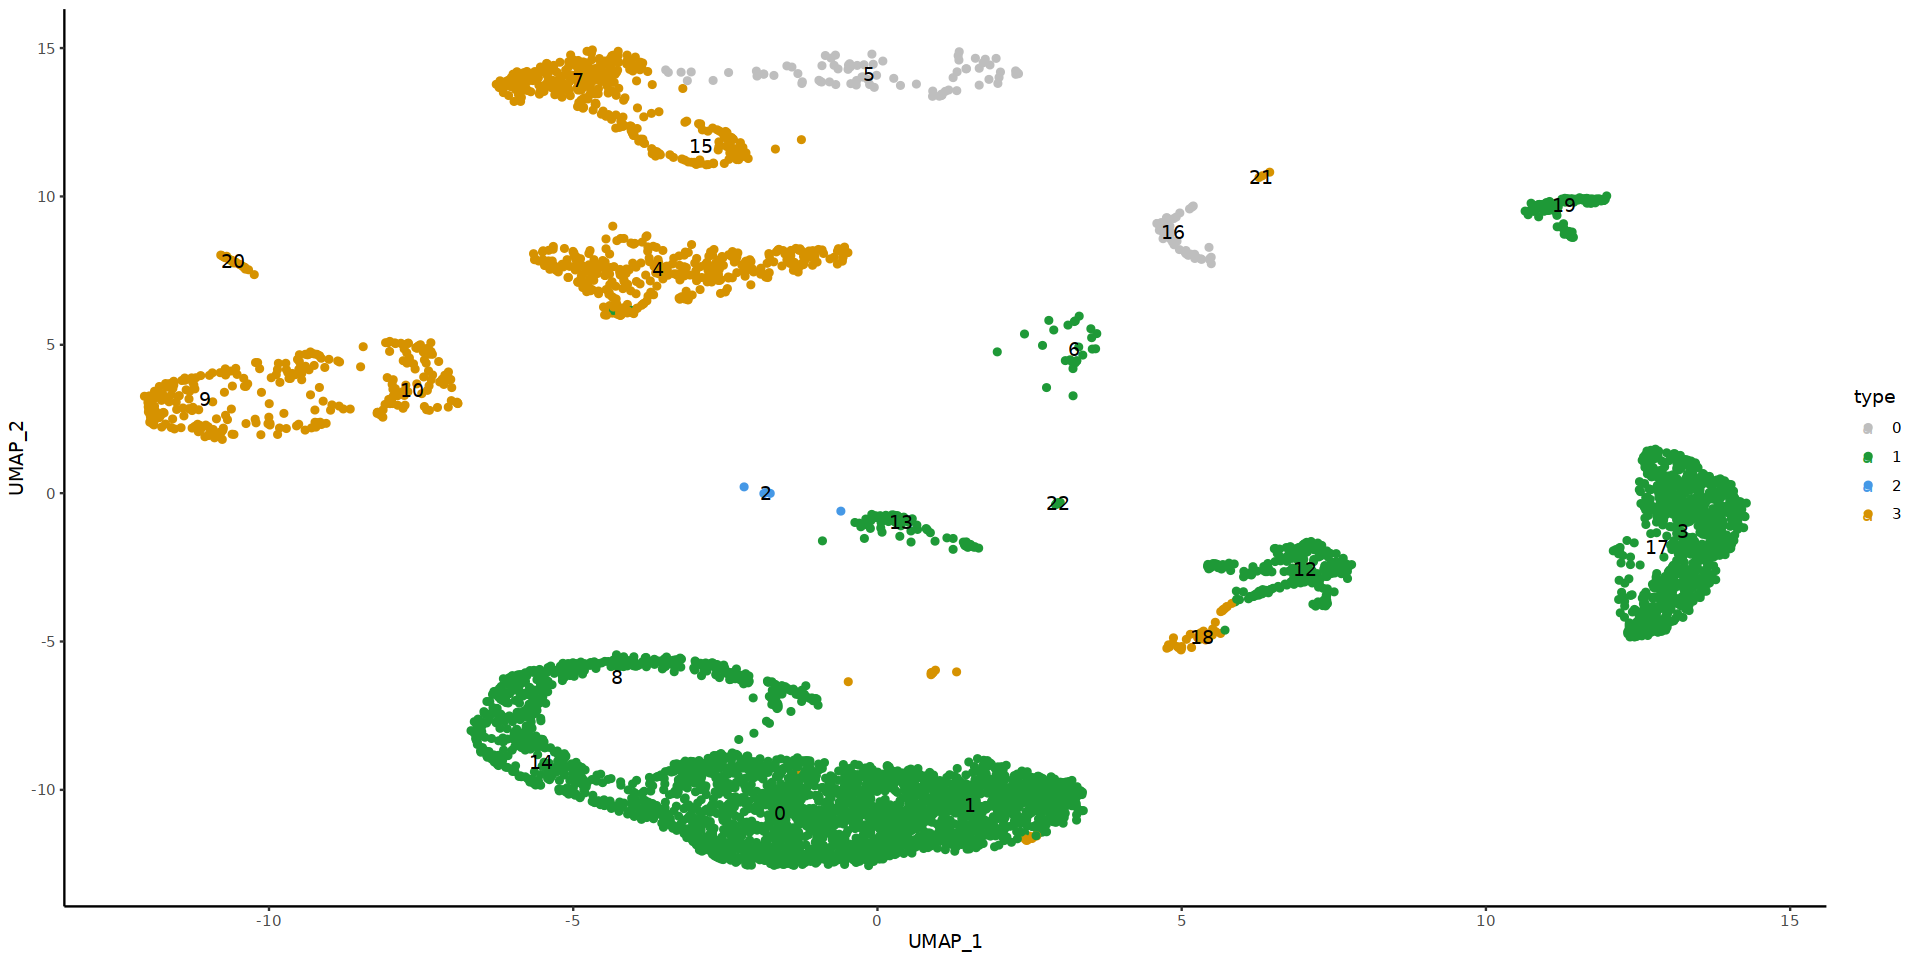

In [941]:
# Show distribution of Trim28 and Pgr expression (respectively) for WILD-TYPE clusters.
# Cutoff is arbitrary. Need a better method for that.

pts <- as.data.frame(Embeddings(trim28_wt_tmp, reduction = "umap"))
pgr_trim28_pos <- t(GetAssayData(trim28_wt_tmp)[c("Trim28","Pgr"),])
pts <- cbind(pts, pgr_trim28_pos)
pts$cluster <- trim28_wt_tmp$seurat_clusters
cluster_expr_agg <- pts %>% group_by(cluster) %>% summarize(UMAP_1 = median(UMAP_1), UMAP_2 = median(UMAP_2), mean_Pgr = mean(Pgr), mean_Trim28 = mean(Trim28))
cluster_expr_agg_filt_bothhi <- cluster_expr_agg %>% filter(mean_Pgr > 0.2 & mean_Trim28 > 0.2)
cluster_expr_agg_filt_pgrhi <- cluster_expr_agg %>% filter(mean_Pgr > 0.2 & mean_Trim28 <= 0.2)
cluster_expr_agg_filt_trim28hi <- cluster_expr_agg %>% filter(mean_Pgr <= 0.2 & mean_Trim28 > 0.2)
pts$type <- 0
pts$type[pts$cluster %in% cluster_expr_agg_filt_bothhi$cluster] <- 1
pts$type[pts$cluster %in% cluster_expr_agg_filt_pgrhi$cluster] <- 2
pts$type[pts$cluster %in% cluster_expr_agg_filt_trim28hi$cluster] <- 3
pts$type <- as.factor(pts$type)

# Plot high-Trim28 and high-Pgr clusters (blue) and low (red).
point_plt <- ggplot(data = pts, aes(x = UMAP_1, y = UMAP_2, color = type, label = cluster)) + 
                    geom_point() +
                    scale_color_manual(values = c("0" = "gray", "1" = "#1E9937", "2" = "#4598E6", "3" = "#D69200")) +
                    theme_classic() + 
                    geom_text(data = cluster_expr_agg, aes(label = cluster, color = NULL))

point_plt

# Save the above two plots.
pdf("Figures/TRIM28-Trim28PgrNegvsPos_PointPlot_More.pdf", width = 12, height = 8)
point_plt
dev.off()

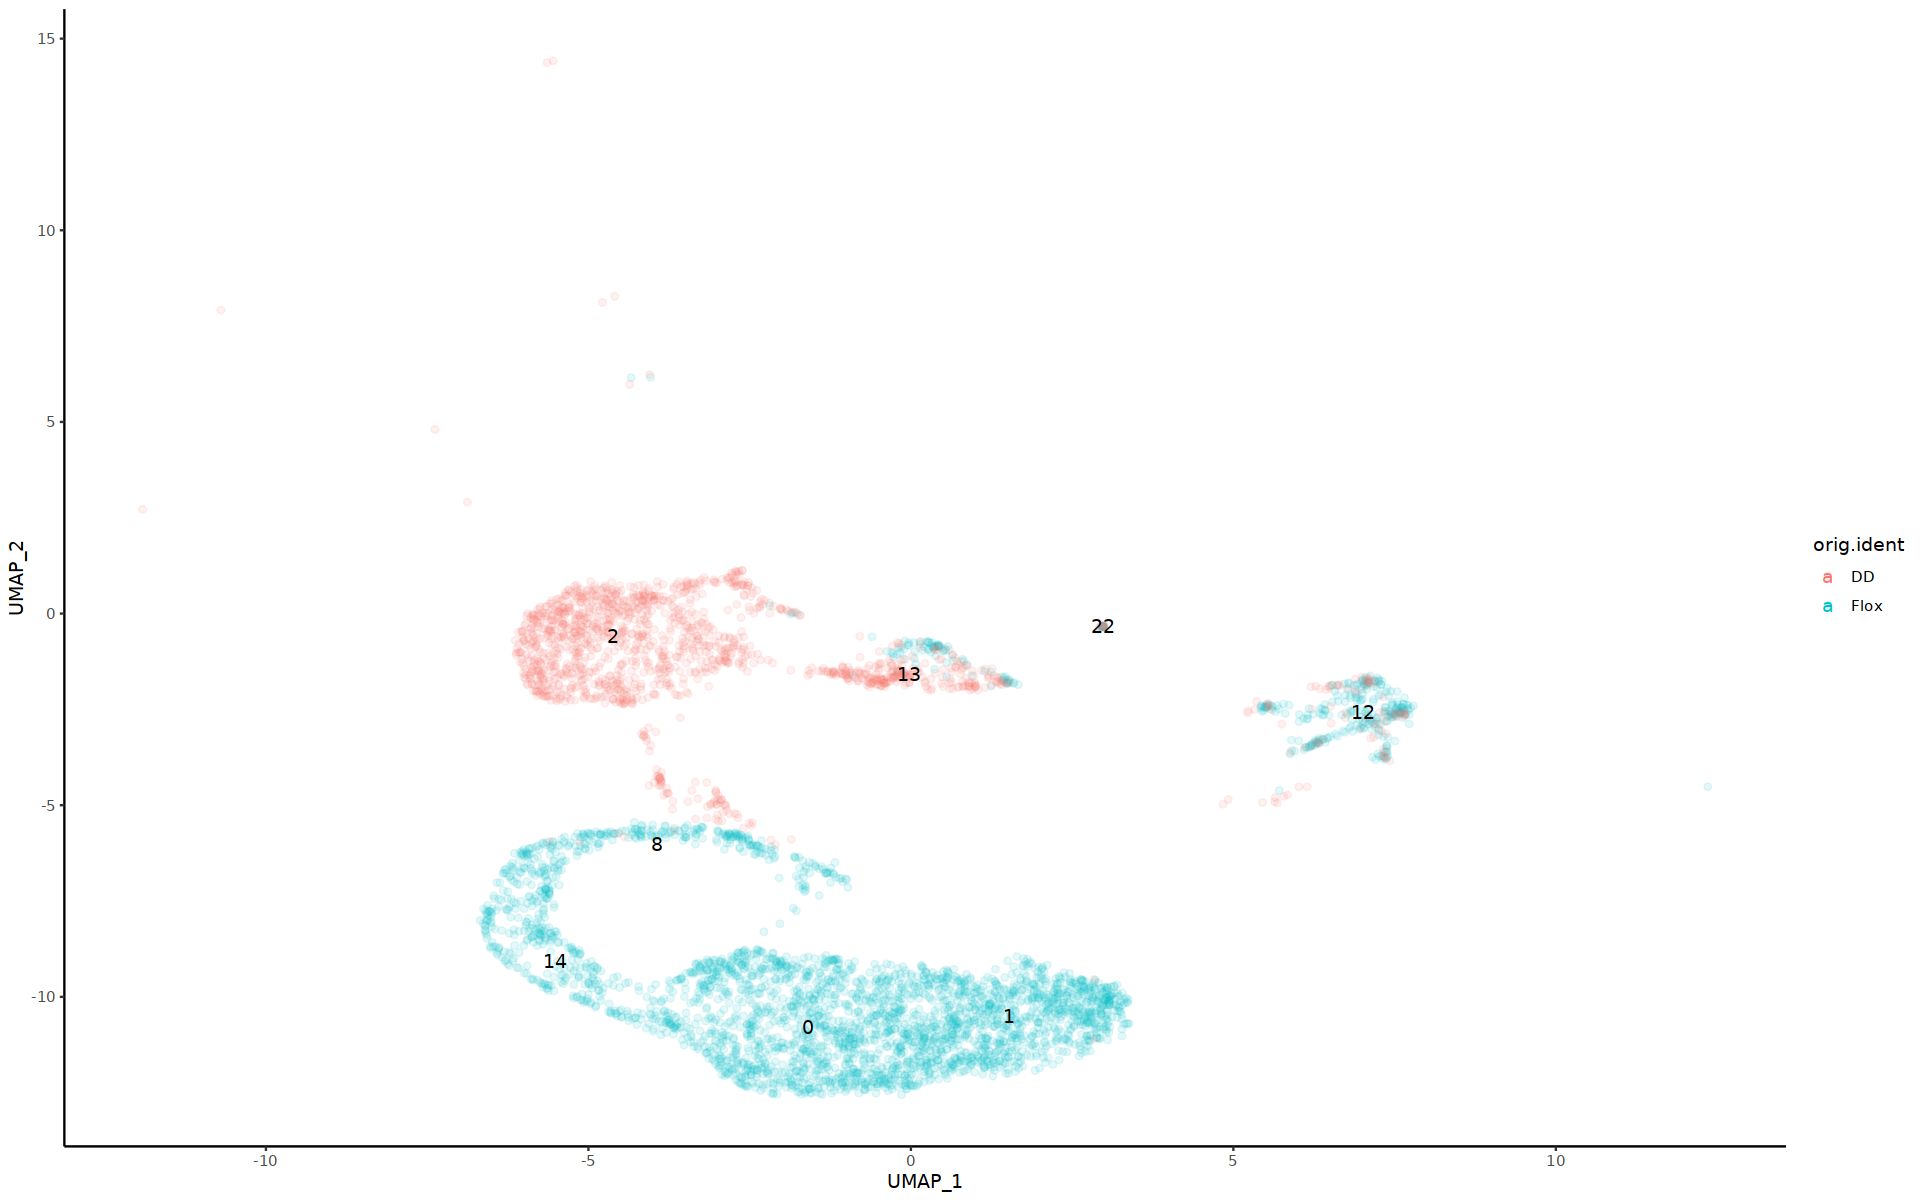

In [619]:
# Plot how the stromal clusters change between flox and knockout conditions.

trim28_tmp <- trim28
pts_all <- as.data.frame(Embeddings(trim28_tmp, reduction = "umap"))
pts_all$cluster <- trim28_tmp$seurat_clusters
pts_all$orig.ident <- factor(trim28_tmp$orig.ident, levels = c("DD", "Flox"))
pts_all$lineage <- trim28_tmp$singler_lineage
pts_all <- pts_all %>% filter(lineage == "Stromal")
cluster_expr_agg_all <- pts_all %>% group_by(cluster) %>% summarize(UMAP_1 = median(UMAP_1), UMAP_2 = median(UMAP_2))
point_plt_all <- ggplot(data = pts_all, aes(x = UMAP_1, y = UMAP_2, color = orig.ident)) + geom_point(alpha = 0.1) + theme_classic() + 
                     geom_text(data = cluster_expr_agg_all, aes(label = cluster, color = NULL))

point_plt_all

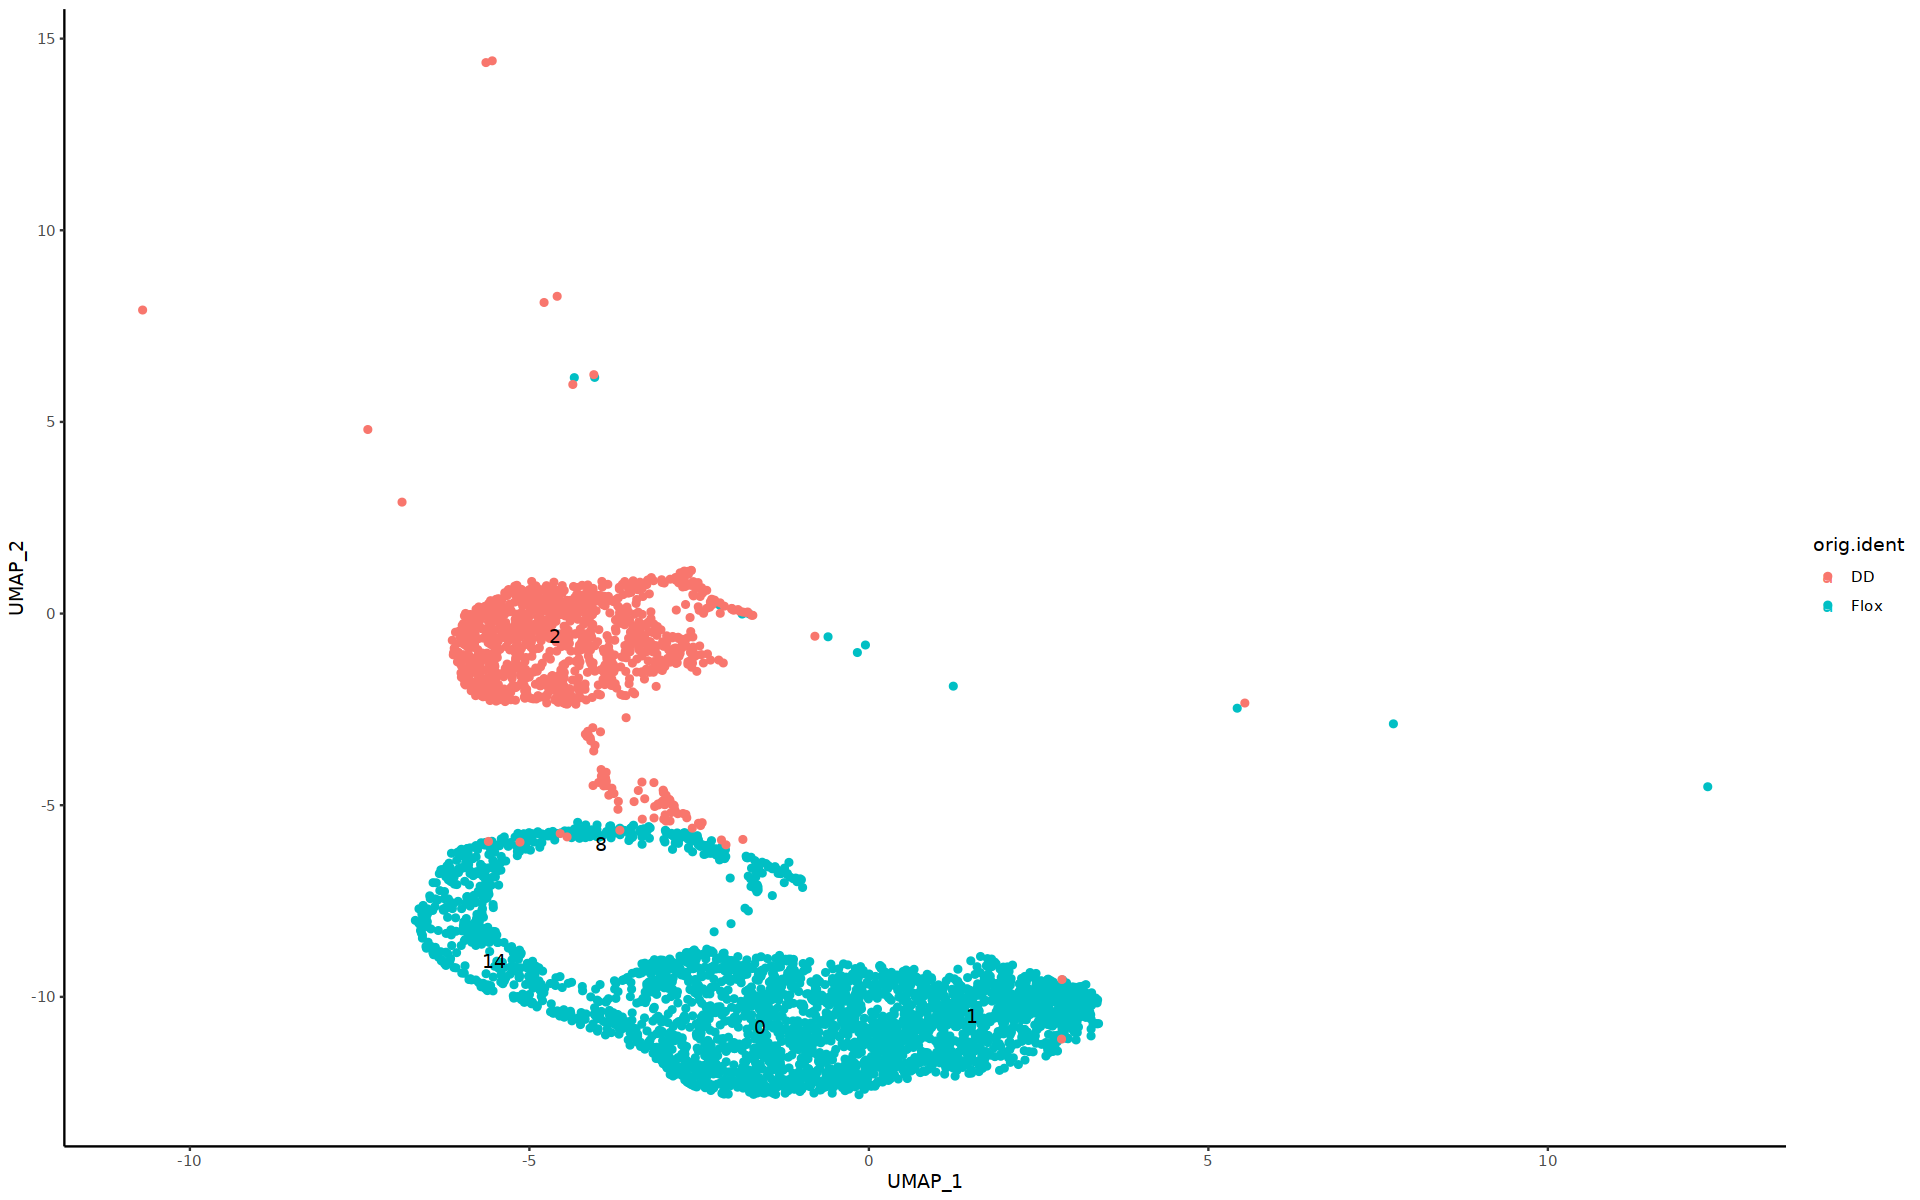

In [624]:
# Of the above plot, exclusively plot the clusters that change and don't have
# overlaps between flox and knockout conditions.

pts_opaque <- pts_all %>% filter(cluster %in% c(0,1,2,8,14))
cluster_expr_agg_opaque <- pts_opaque %>% group_by(cluster) %>% summarize(UMAP_1 = median(UMAP_1), UMAP_2 = median(UMAP_2))
point_plt_opaque <- ggplot(data = pts_opaque, aes(x = UMAP_1, y = UMAP_2, color = orig.ident)) + geom_point() + theme_classic() + 
                     geom_text(data = cluster_expr_agg_opaque, aes(label = cluster, color = NULL))

point_plt_opaque

In [ ]:
# Save the above two plots.

pdf("Figures/Stromal_FloxvsKO_Viz.pdf", width = 5, height = 5)
point_plt_all
point_plt_opaque
dev.off()

In [632]:
# Analyze the key changes between the DD and flox conditions of the graph immediately above.

trim28_tmp_subset <- subset(trim28_tmp, seurat_clusters %in% c(0,1,2,8,14))
Idents(trim28_tmp_subset) <- trim28_tmp_subset$orig.ident
degs_floxvko_stromal <- FindMarkers(trim28_tmp_subset, ident.1 = "DD", ident.2 = "Flox")
head(degs_floxvko_stromal)

p_val avg_log2FC pct.1 pct.2 p_val_adj
Arl4c  0      1.684007  0.891 0.494 0        
Col6a3 0      2.235496  0.961 0.860 0        
Inhbb  0      1.105913  0.544 0.026 0        
Rgs2   0     -2.997595  0.242 0.970 0        
Grem2  0      1.090636  0.614 0.006 0        
Col5a1 0      1.701786  0.950 0.887 0

In [634]:
# Filter and save the above table for those genes with padj < 0.05 and log2(FC) > log2(1.5)

degs_floxvko_stromal_filt <- degs_floxvko_stromal %>% arrange(desc(avg_log2FC)) %>% filter(p_val_adj < 0.05 & abs(avg_log2FC) > log2(1.5))
fwrite(degs_floxvko_stromal_filt, "Data/MarkerGenes/DEGs-FloxvKOStromal-TRIM28.csv", row.names = TRUE, col.names = TRUE)

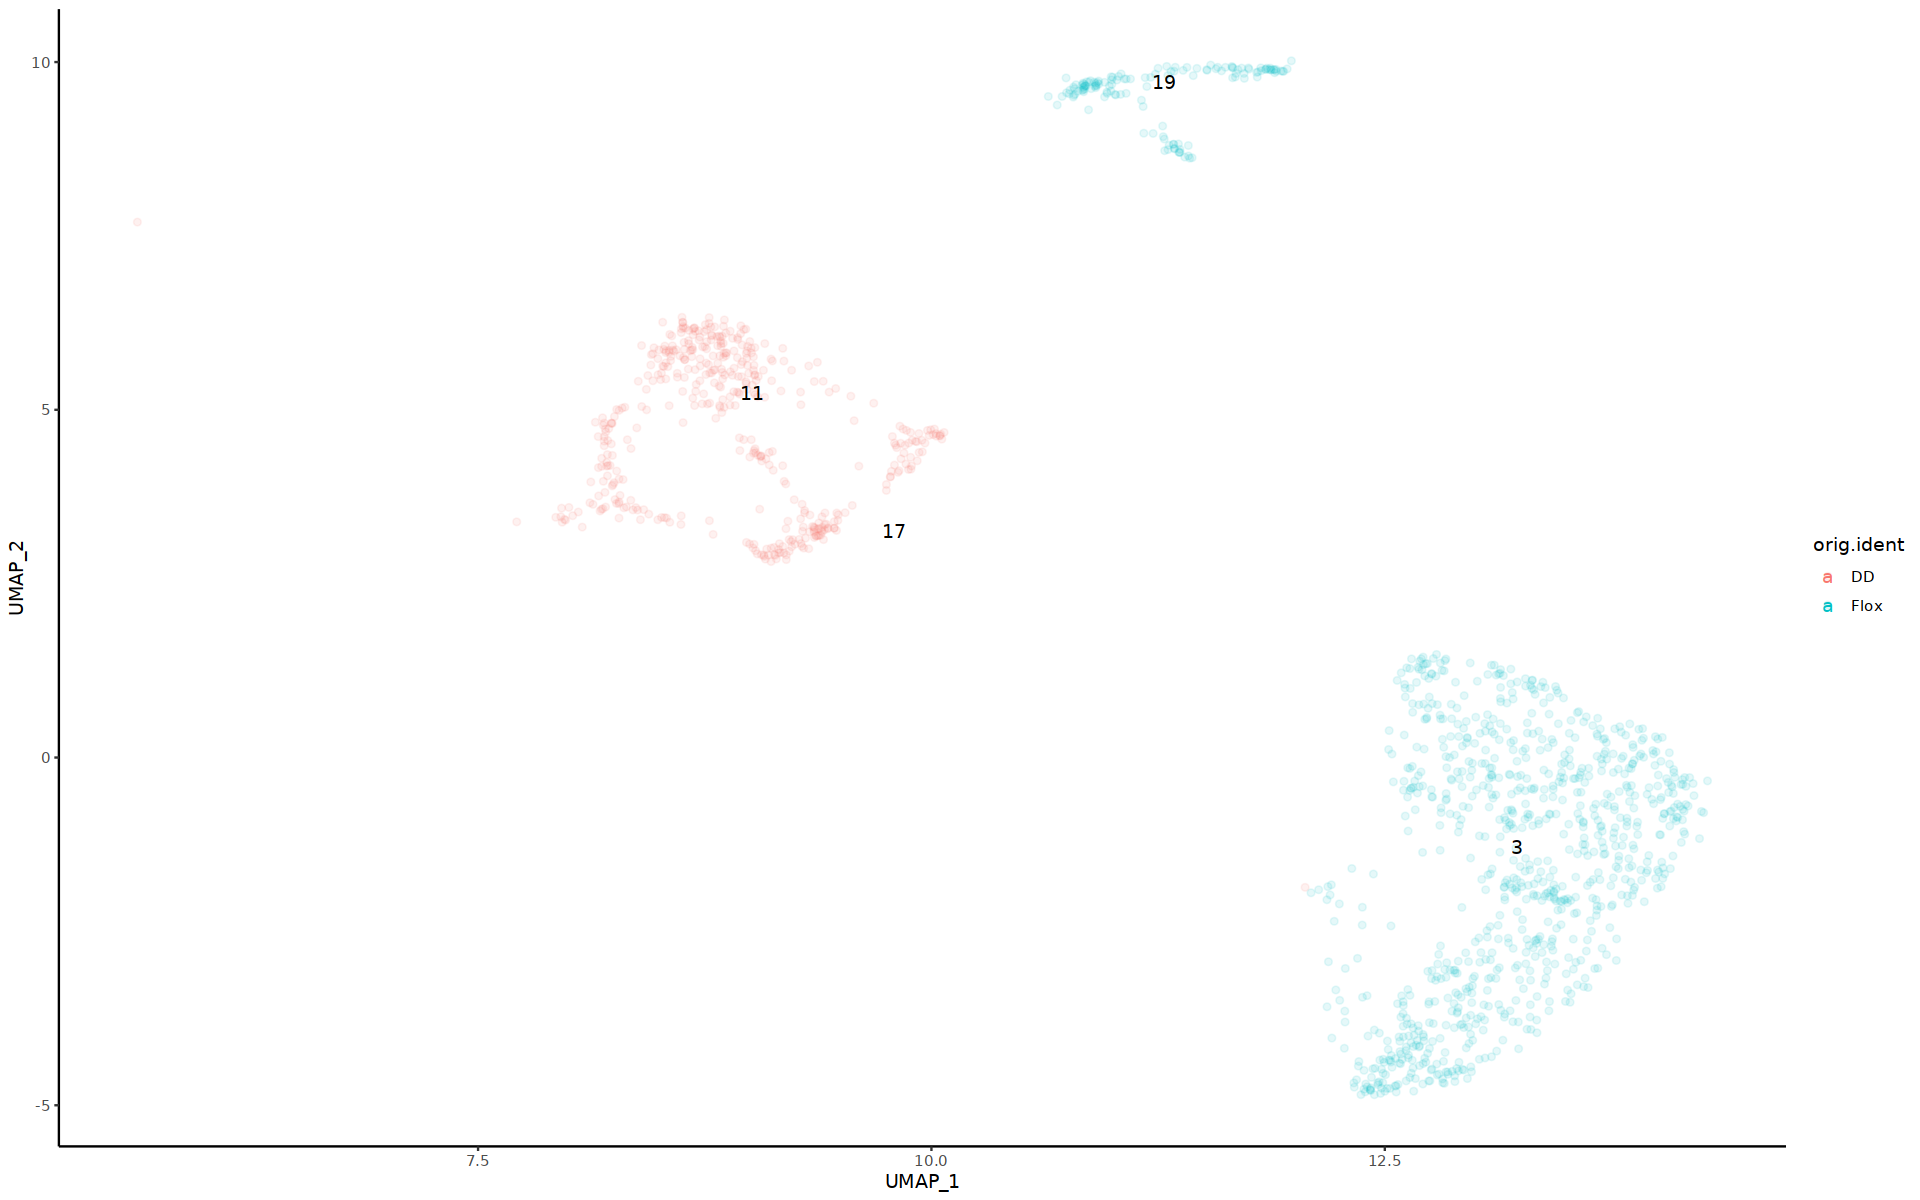

In [636]:
# Plot how the epithelial clusters change between flox and knockout conditions.

trim28_tmp <- trim28
pts_all <- as.data.frame(Embeddings(trim28_tmp, reduction = "umap"))
pts_all$cluster <- trim28_tmp$seurat_clusters
pts_all$orig.ident <- factor(trim28_tmp$orig.ident, levels = c("DD", "Flox"))
pts_all$lineage <- trim28_tmp$singler_lineage
pts_all <- pts_all %>% filter(lineage == "Epithelial")
cluster_expr_agg_all <- pts_all %>% group_by(cluster) %>% summarize(UMAP_1 = median(UMAP_1), UMAP_2 = median(UMAP_2))
point_plt_all <- ggplot(data = pts_all, aes(x = UMAP_1, y = UMAP_2, color = orig.ident)) + geom_point(alpha = 0.1) + theme_classic() + 
                     geom_text(data = cluster_expr_agg_all, aes(label = cluster, color = NULL))

point_plt_all

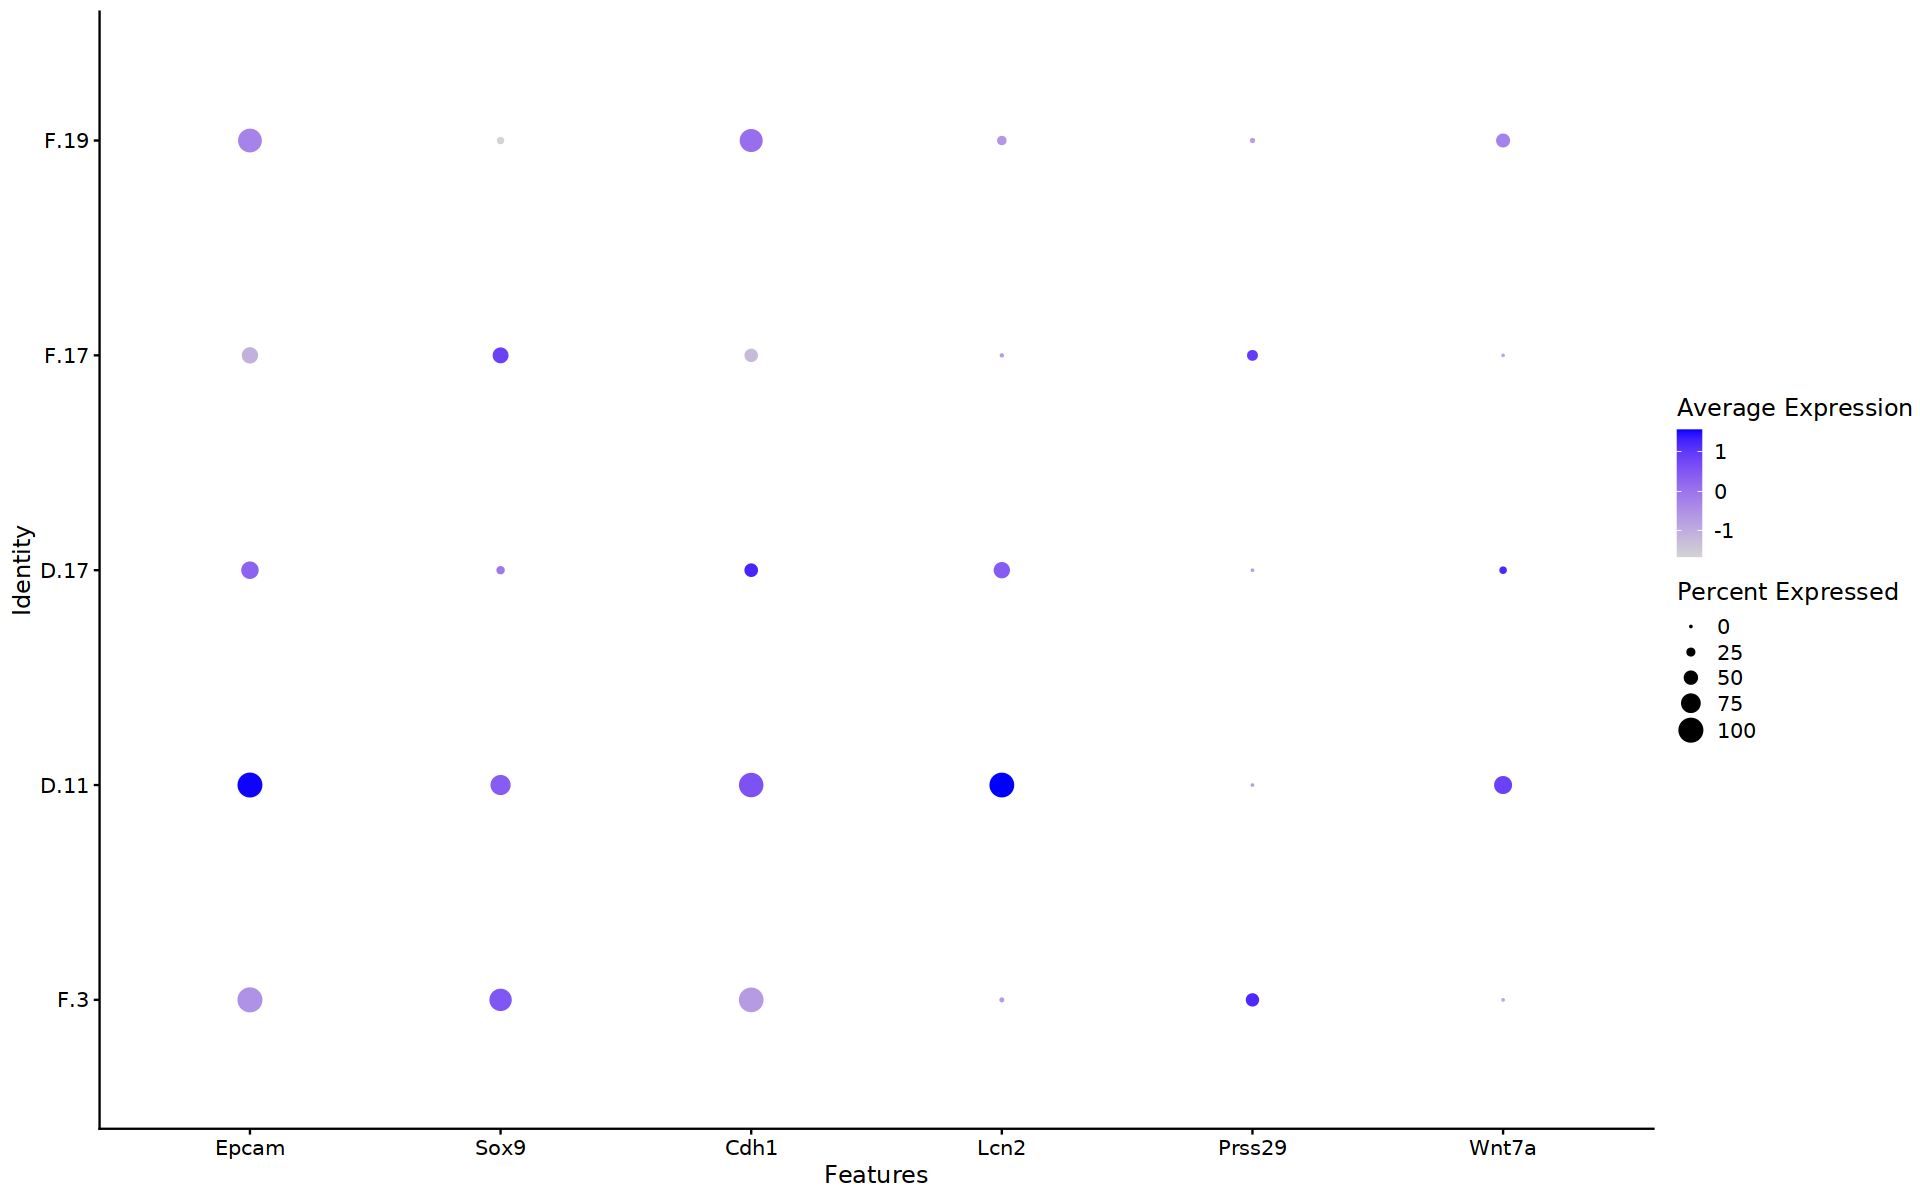

In [658]:
# Plot markers for above epithelial clusters.

DotPlot(subset(trim28, singler_lineage == "Epithelial"), features = c("Epcam", "Sox9", "Cdh1", "Lcn2", "Prss29", "Wnt7a"))

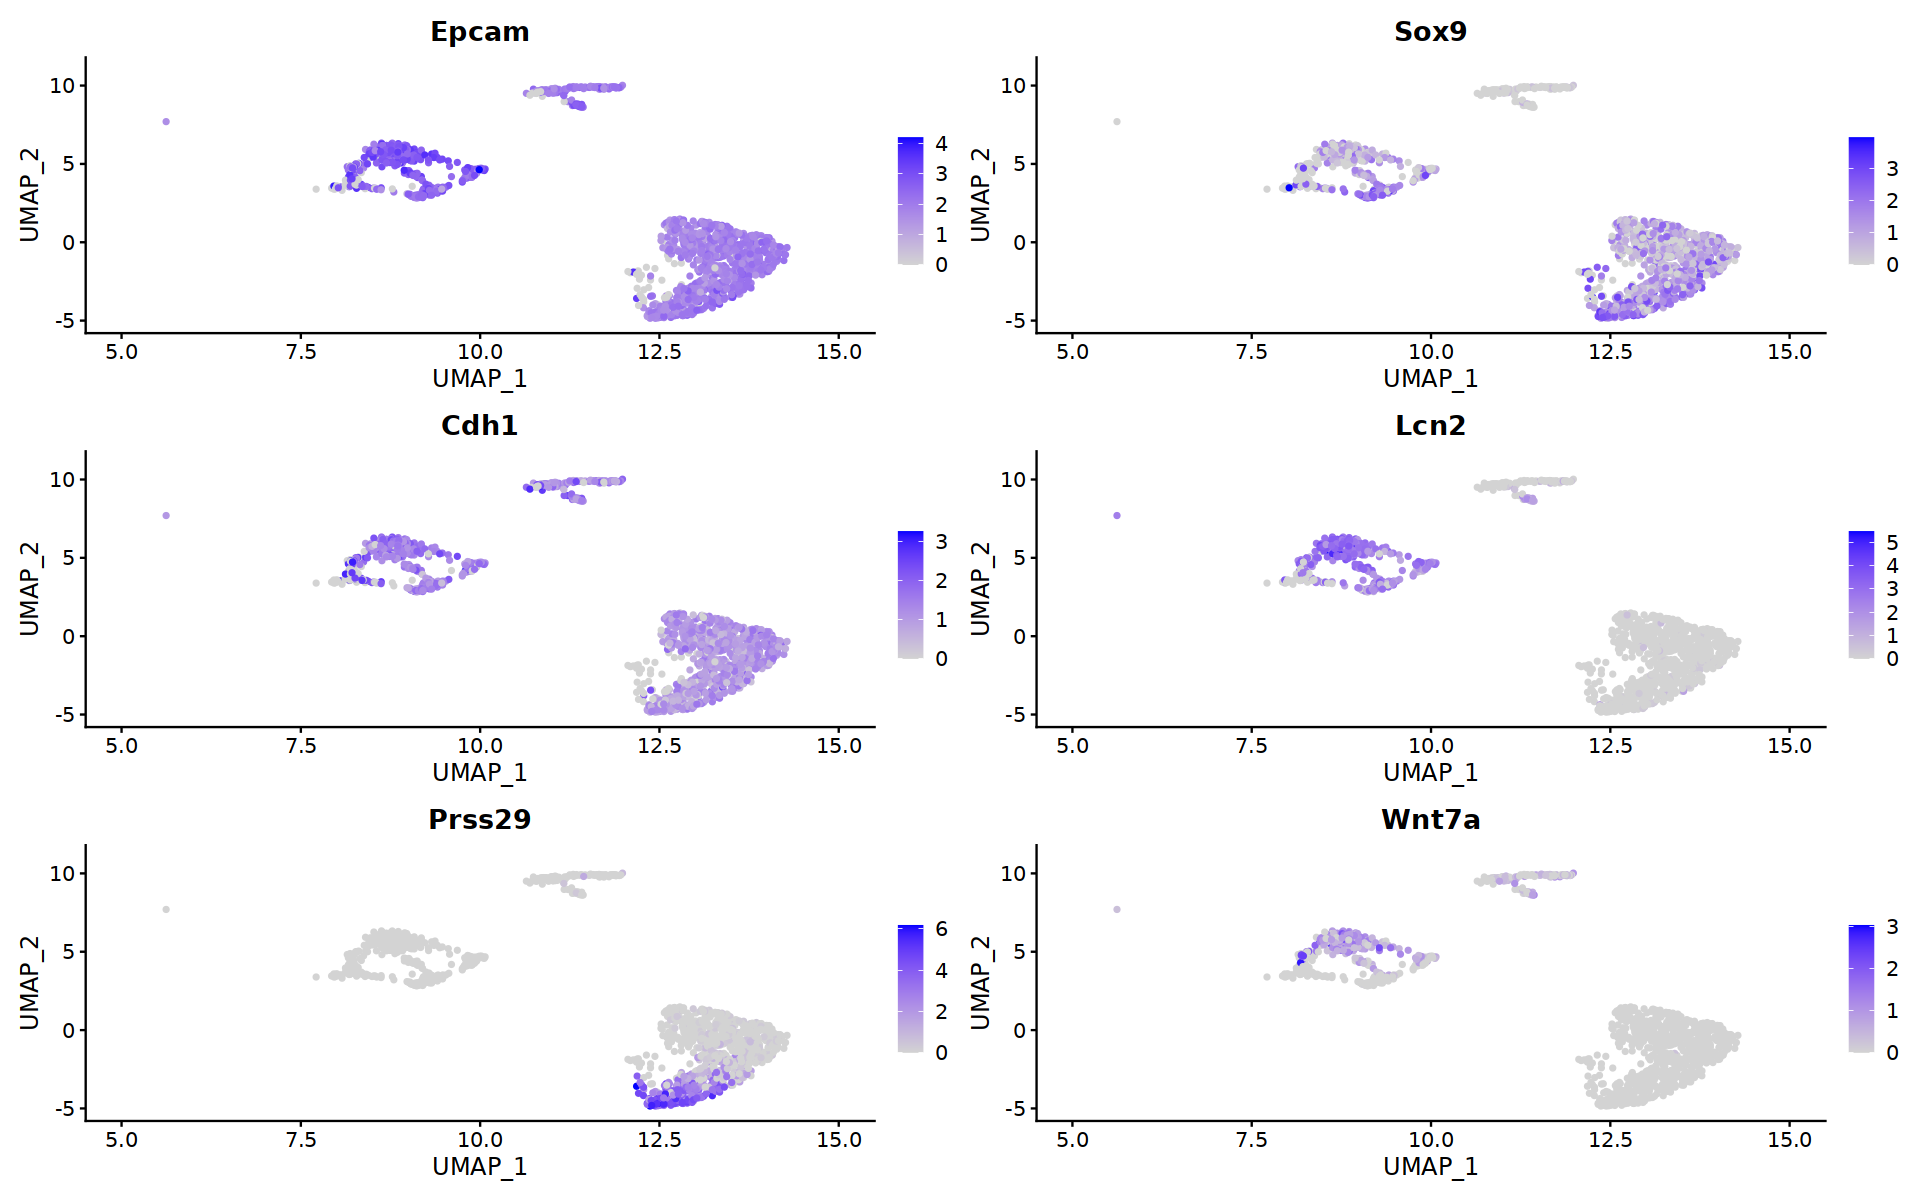

In [665]:
# Plot markers for above epithelial clusters PER-CELL.

FeaturePlot(subset(trim28, singler_lineage == "Epithelial"), features = c("Epcam", "Sox9", "Cdh1", "Lcn2", "Prss29", "Wnt7a"))

png 
  2

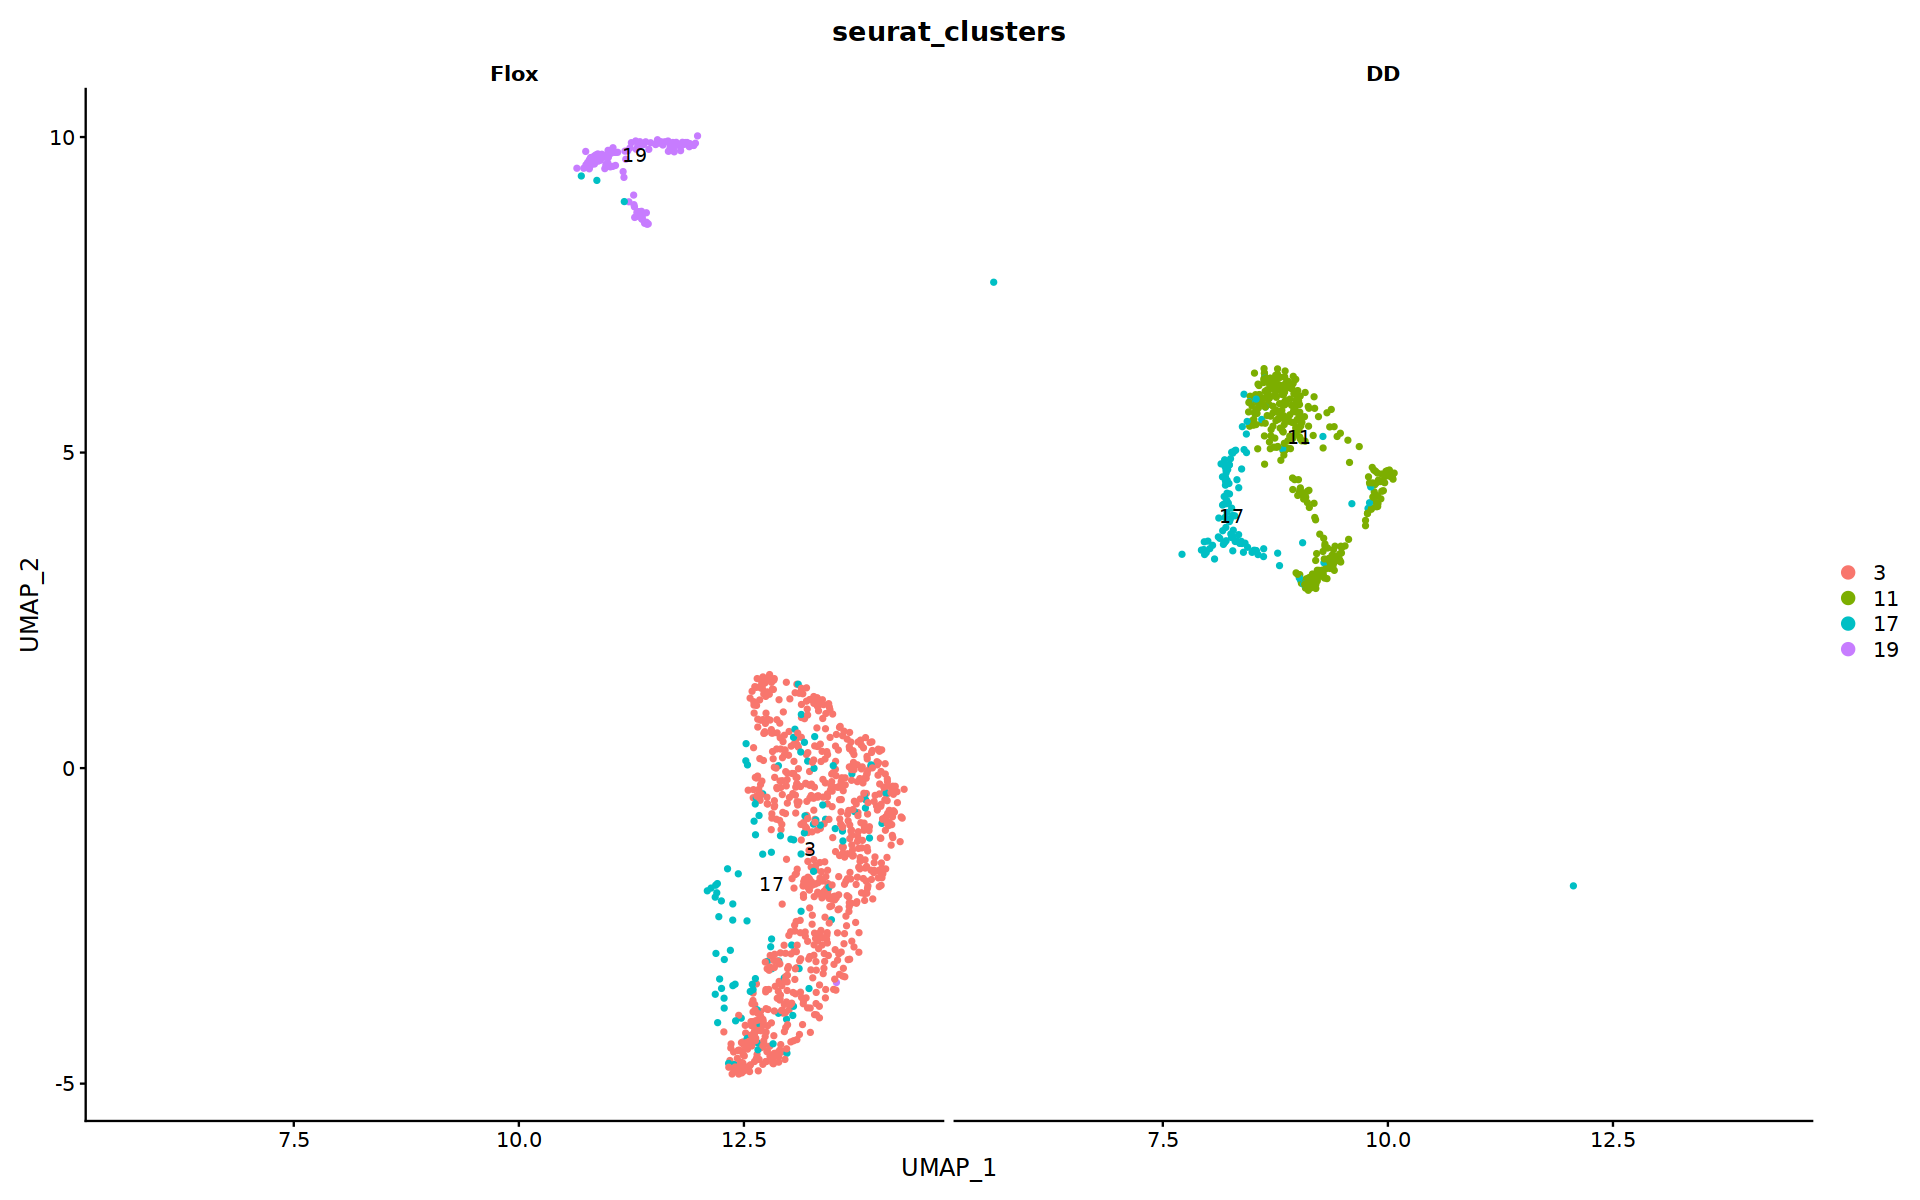

In [650]:
# Plot epithelial clusters and save the plot for both flox and KO conditions.

pts_clusters_epi_plt <- DimPlot(subset(trim28, singler_lineage == "Epithelial"), group.by = "seurat_clusters", split.by = "orig.ident", label = TRUE)
pts_clusters_epi_plt

pdf("Figures/TRIM28-Trim28EpiTreatments.pdf", width = 8, height = 7)
pts_clusters_epi_plt
dev.off()

png 
  2

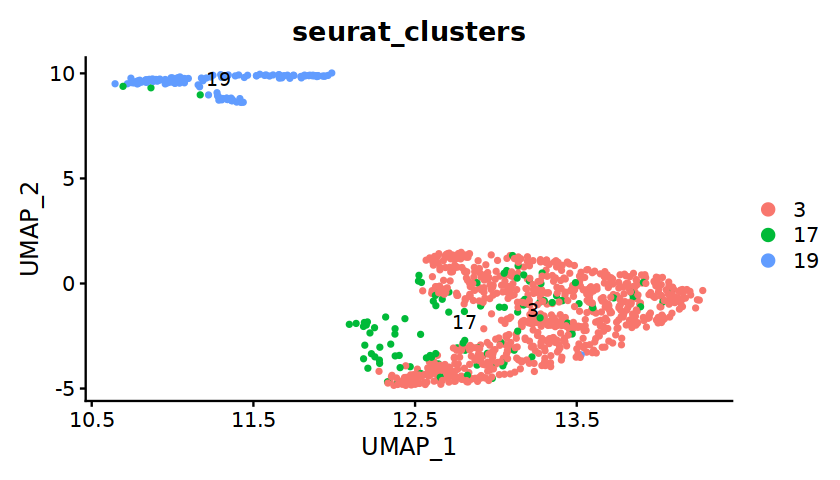

In [773]:
# Plot epithelial clusters and save the plot for flox conditions.

pts_clusters_epi_plt <- DimPlot(subset(trim28, singler_lineage == "Epithelial" & orig.ident == "Flox"), group.by = "seurat_clusters", label = TRUE)
pts_clusters_epi_plt

pdf("Figures/TRIM28-Trim28EpiTreatments-FloxOnly.pdf", width = 7, height = 7)
pts_clusters_epi_plt
dev.off()

png 
  2

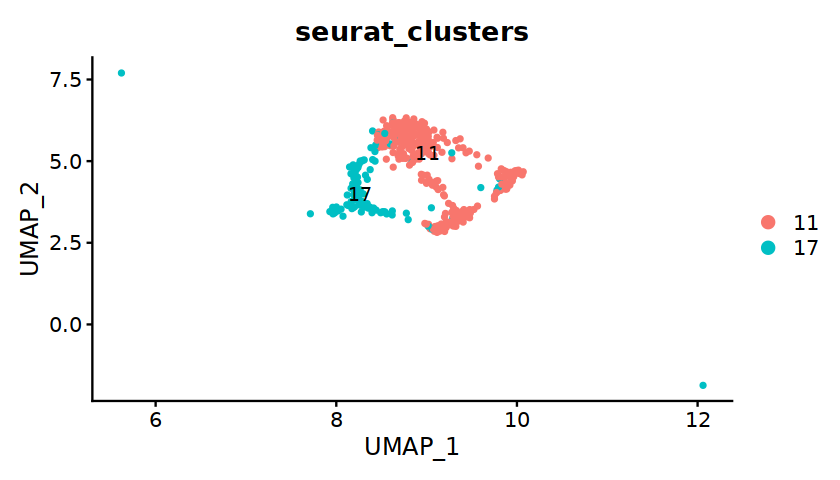

In [781]:
# Plot epithelial clusters and save the plot for KO conditions.

pts_clusters_epi_plt <- DimPlot(subset(trim28, singler_lineage == "Epithelial" & orig.ident == "DD"), group.by = "seurat_clusters", label = TRUE)
pts_clusters_epi_plt

pdf("Figures/TRIM28-Trim28EpiTreatments-DDOnly.pdf", width = 7, height = 7)
pts_clusters_epi_plt
dev.off()

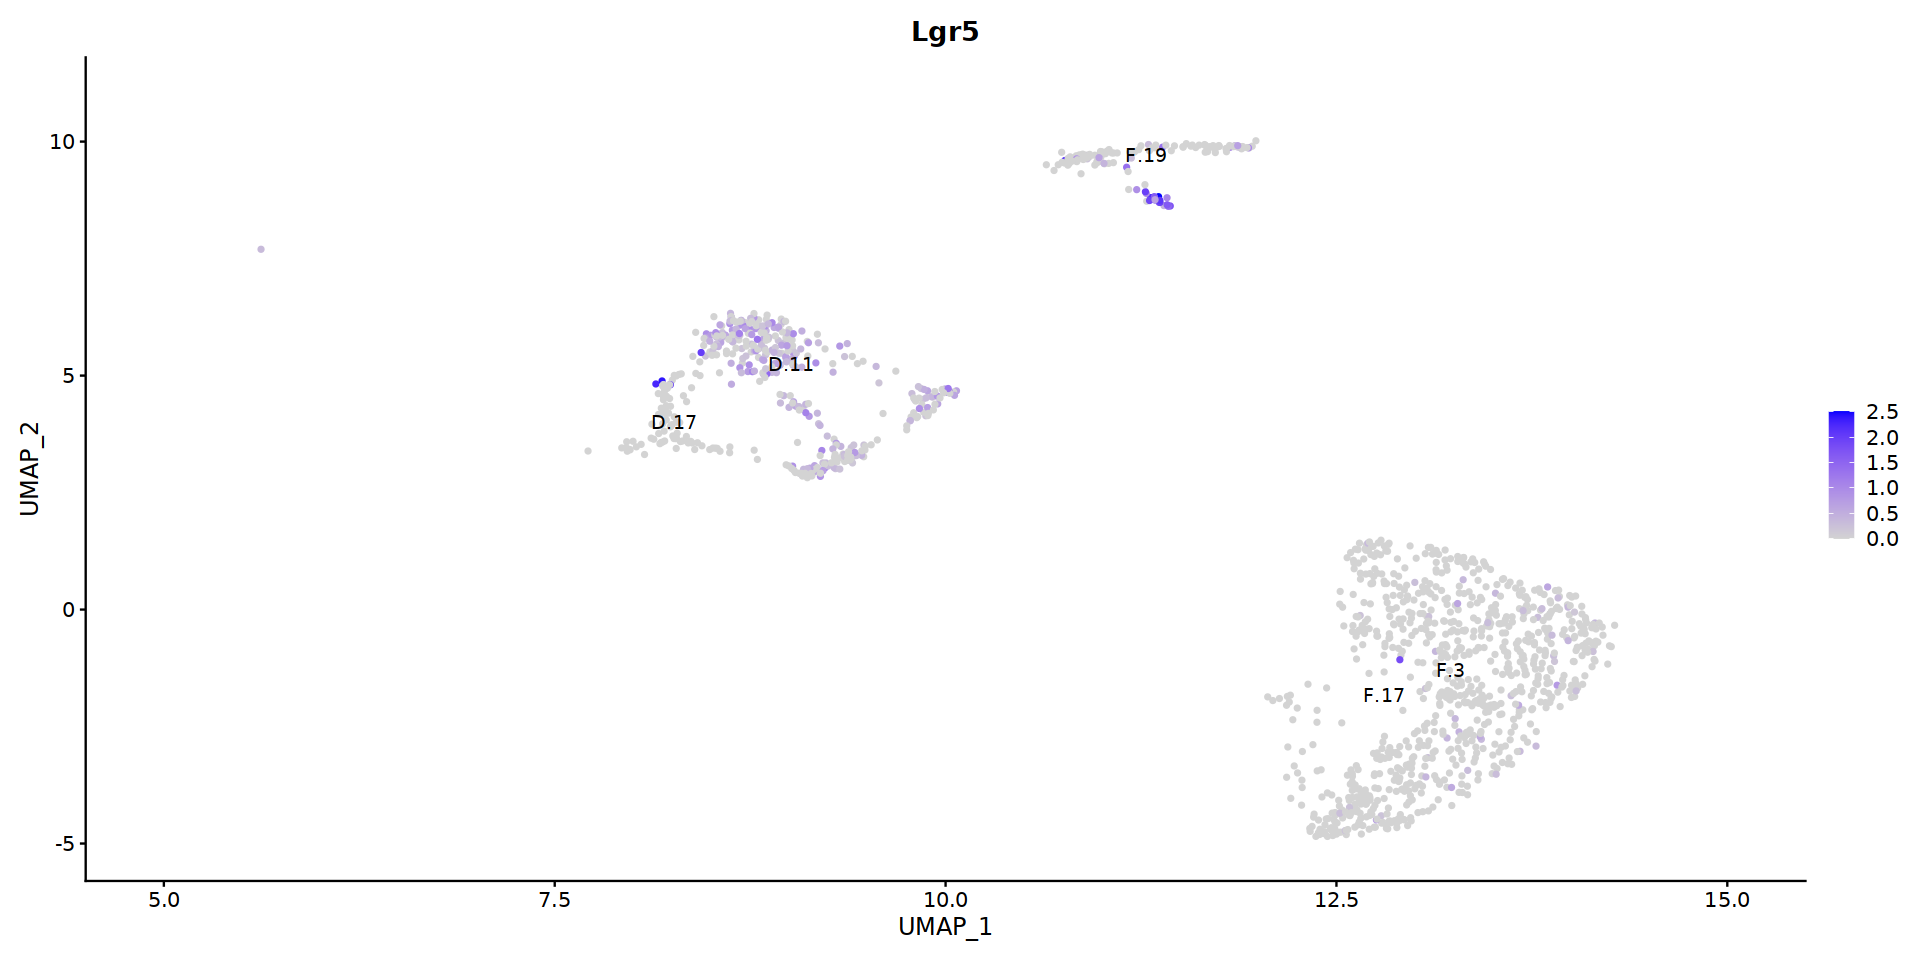

In [861]:
# Plot epithelial clusters and save the plot for KO conditions.

pts_clusters_epi_plt <- FeaturePlot(subset(trim28, singler_lineage == "Epithelial"), features = "Lgr5", label = TRUE)
pts_clusters_epi_plt

In [862]:
pdf("Figures/Lgr5SingleCellPlots.pdf", width = 16, height = 8)
pts_clusters_epi_plt
dev.off()

png 
  2

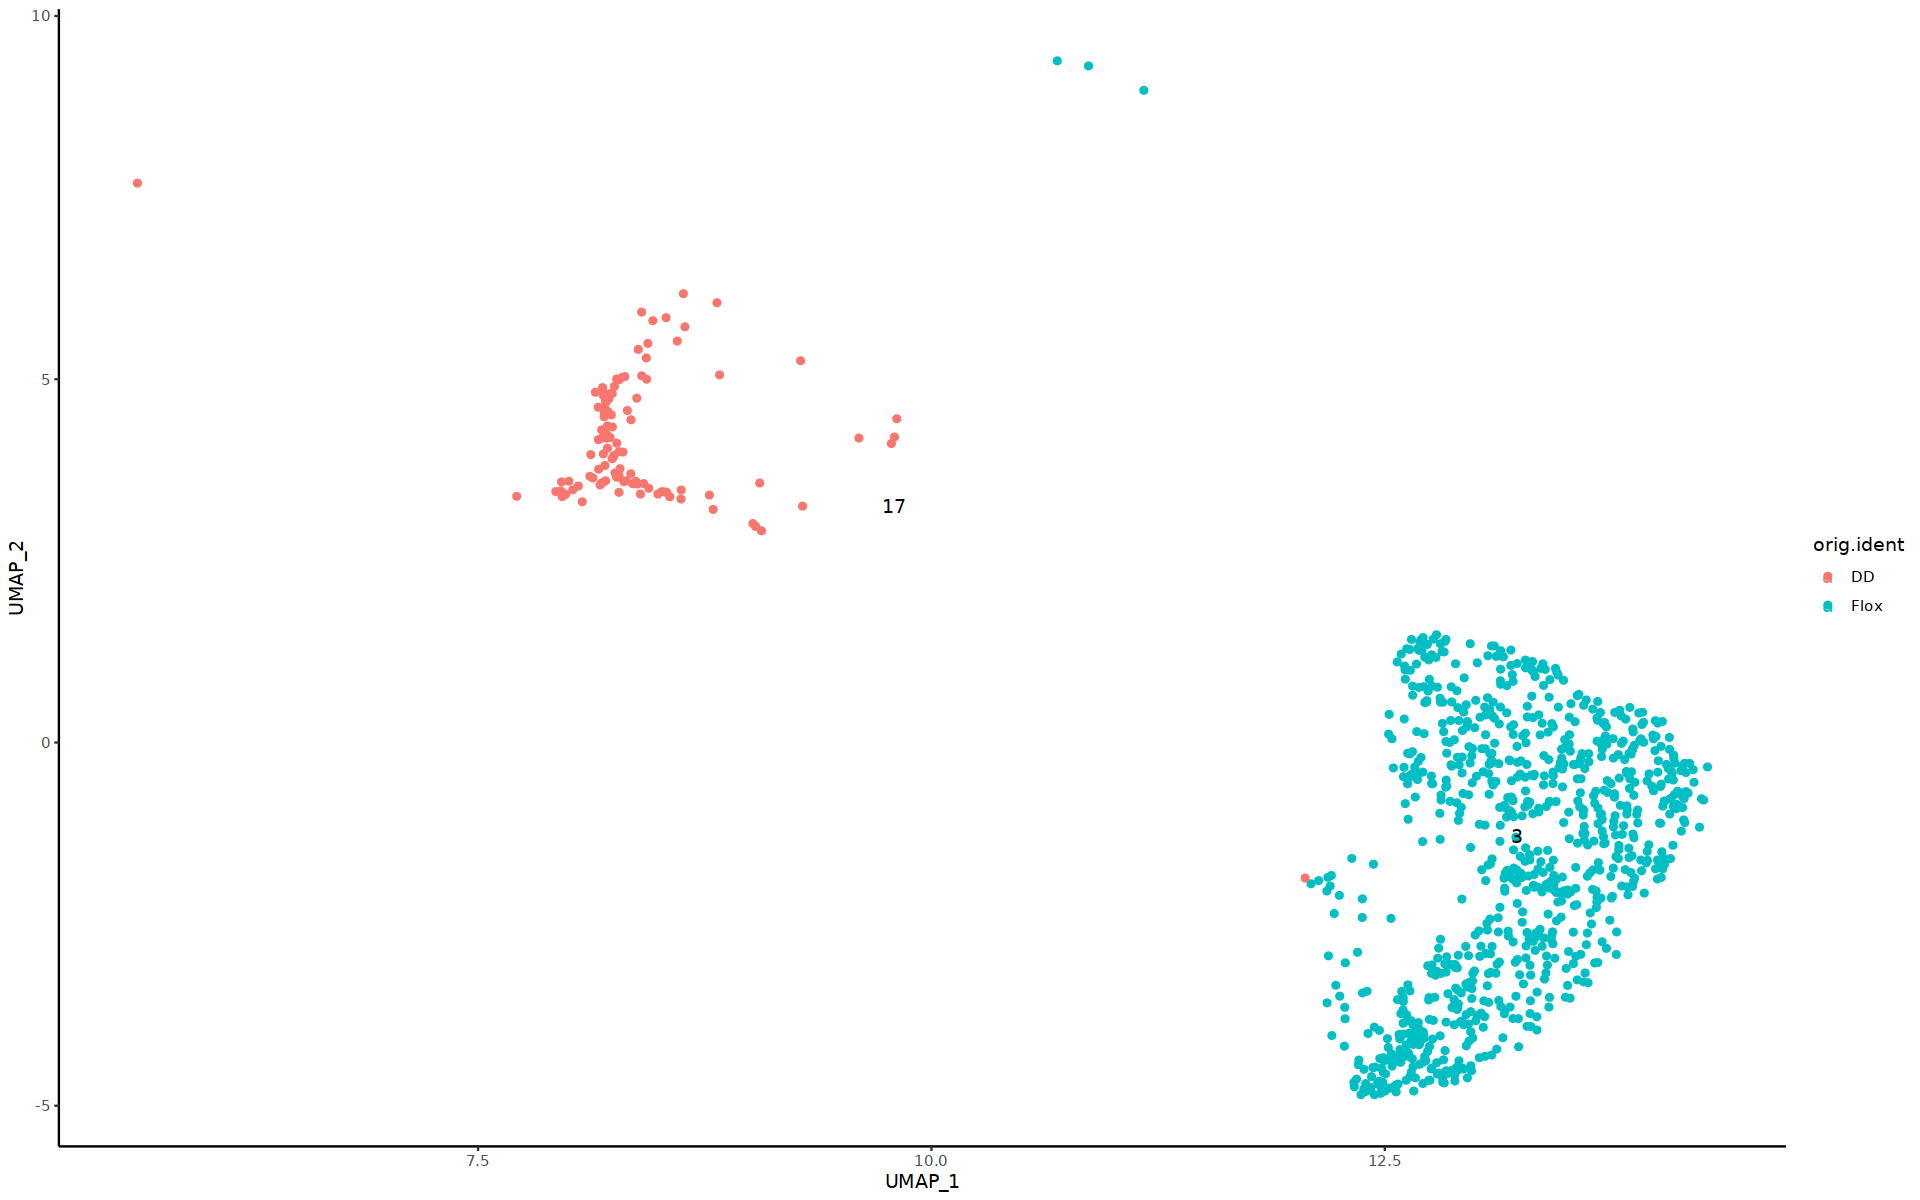

In [731]:
# Plot how the granular epithelial clusters change between flox and knockout conditions.

trim28_tmp <- trim28
pts_all <- as.data.frame(Embeddings(trim28_tmp, reduction = "umap"))
pts_all$cluster <- trim28_tmp$seurat_clusters
pts_all$orig.ident <- factor(trim28_tmp$orig.ident, levels = c("DD", "Flox"))
pts_all$lineage <- trim28_tmp$singler_lineage
pts_opaque <- pts_all %>% filter(cluster %in% c(3, 17))
cluster_expr_agg_opaque <- pts_opaque %>% group_by(cluster) %>% summarize(UMAP_1 = median(UMAP_1), UMAP_2 = median(UMAP_2))
point_plt_opaque_e1 <- ggplot(data = pts_opaque, aes(x = UMAP_1, y = UMAP_2, color = orig.ident)) + geom_point() + theme_classic() + 
                     geom_text(data = cluster_expr_agg_opaque, aes(label = cluster, color = NULL))

point_plt_opaque_e1

In [739]:
# Find the GE markers and save them to a table.

trim28_tmp <- trim28
Idents(trim28_tmp) <- trim28_tmp$orig.ident
epi_markers_e1 <- FindMarkers(subset(trim28_tmp, seurat_clusters %in% c(3,17)), ident.1 = "DD", ident.2 = "Flox")
epi_markers_e1 <- epi_markers_e1 %>% arrange(desc(avg_log2FC)) %>% filter(p_val_adj < 0.05 & abs(avg_log2FC) > log2(1.5))
fwrite(epi_markers_e1, "Data/MarkerGenes/TRIM28-GE-Markers.csv", row.names = TRUE, col.names = TRUE)

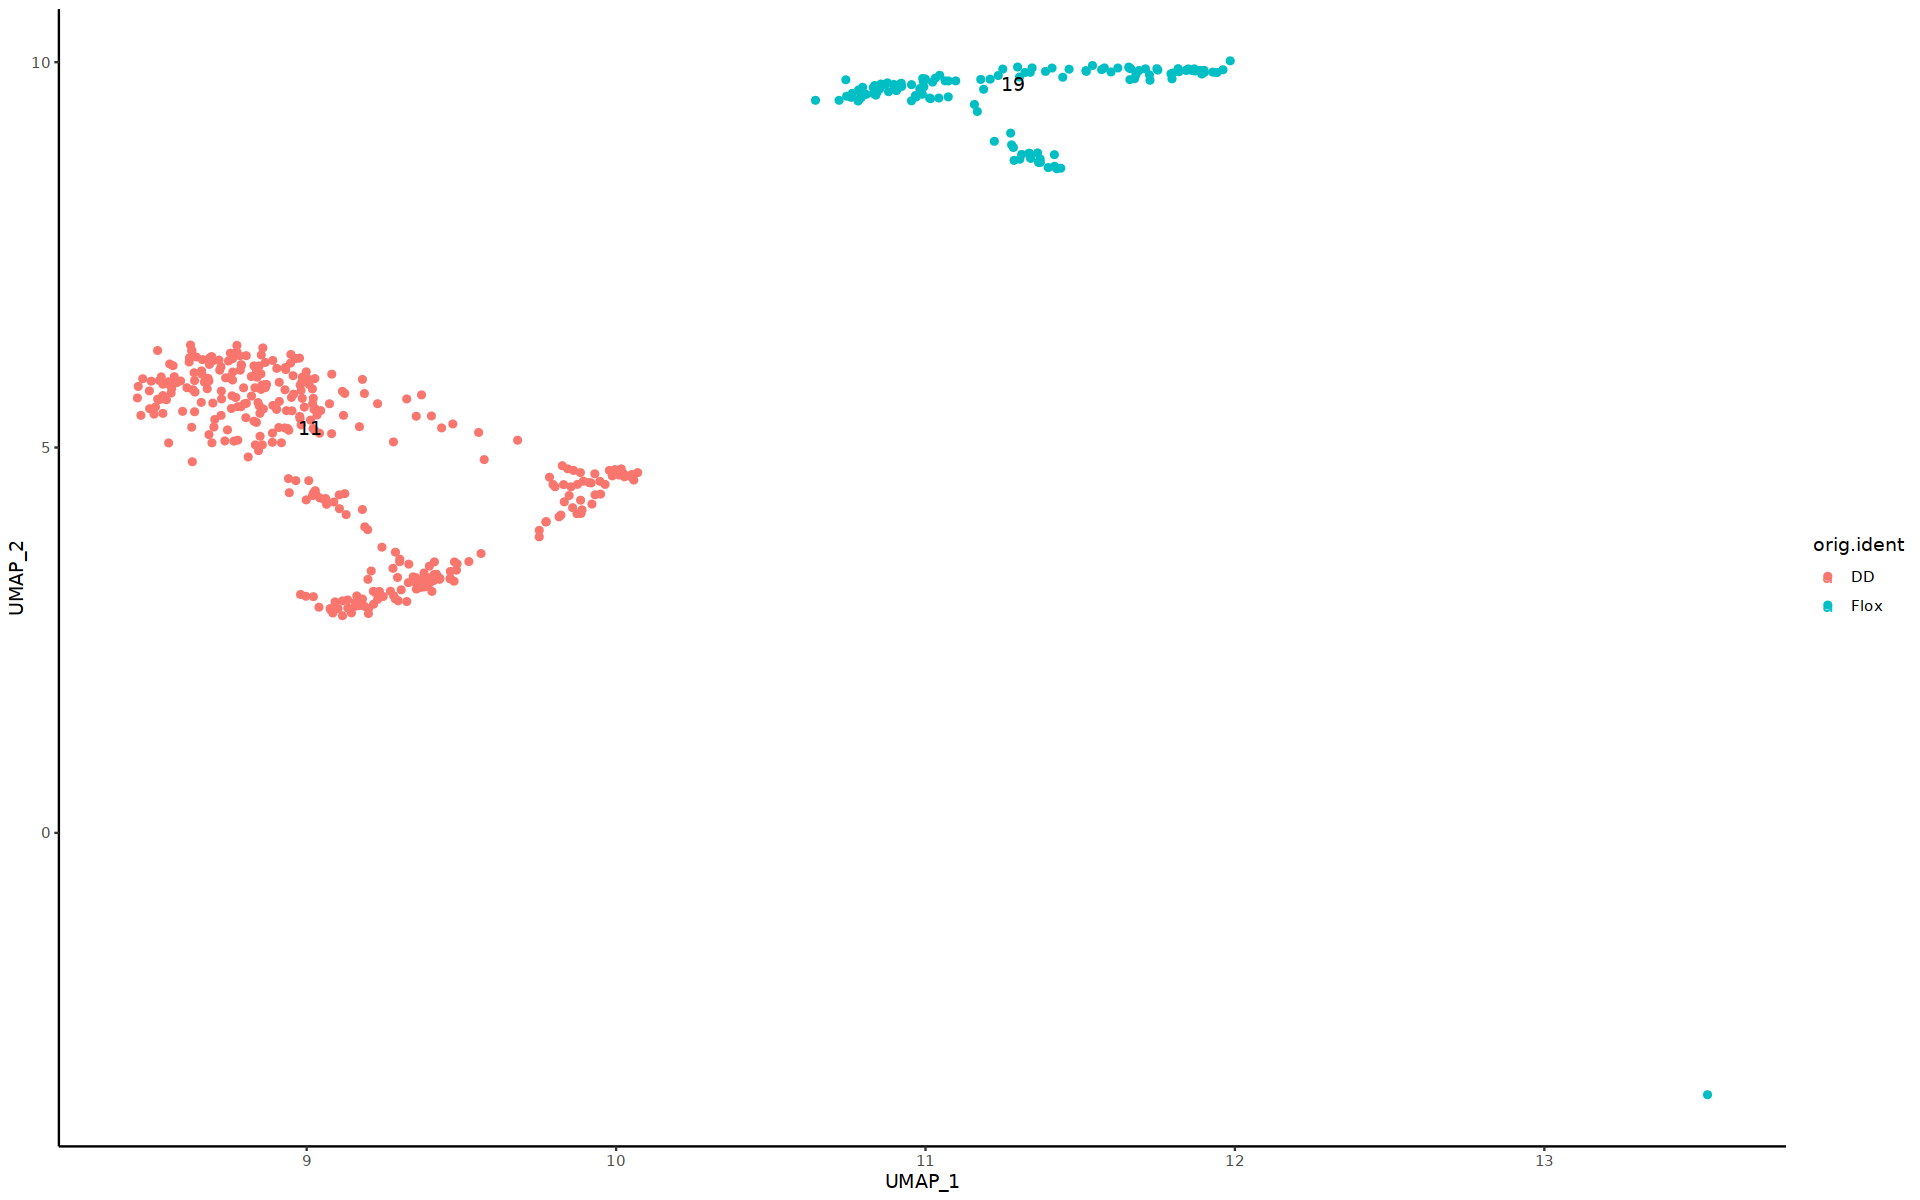

In [732]:
# Plot how the luminal epithelial clusters change between flox and knockout conditions.

trim28_tmp <- trim28
pts_all <- as.data.frame(Embeddings(trim28_tmp, reduction = "umap"))
pts_all$cluster <- trim28_tmp$seurat_clusters
pts_all$orig.ident <- factor(trim28_tmp$orig.ident, levels = c("DD", "Flox"))
pts_all$lineage <- trim28_tmp$singler_lineage
pts_opaque <- pts_all %>% filter(cluster %in% c(11, 19))
cluster_expr_agg_opaque <- pts_opaque %>% group_by(cluster) %>% summarize(UMAP_1 = median(UMAP_1), UMAP_2 = median(UMAP_2))
point_plt_opaque_e2 <- ggplot(data = pts_opaque, aes(x = UMAP_1, y = UMAP_2, color = orig.ident)) + geom_point() + theme_classic() + 
                     geom_text(data = cluster_expr_agg_opaque, aes(label = cluster, color = NULL))

point_plt_opaque_e2

In [738]:
# Find the LE markers and save them to a table.

trim28_tmp <- trim28
Idents(trim28_tmp) <- trim28_tmp$orig.ident
epi_markers_e2 <- FindMarkers(subset(trim28_tmp, seurat_clusters %in% c(11,19)), ident.1 = "DD", ident.2 = "Flox")
epi_markers_e2 <- epi_markers_e1 %>% arrange(desc(avg_log2FC)) %>% filter(p_val_adj < 0.05 & abs(avg_log2FC) > log2(1.5))
fwrite(epi_markers_e2, "Data/MarkerGenes/TRIM28-LE-Markers.csv", row.names = TRUE, col.names = TRUE)

In [733]:
# Save the above two plots.

pdf("Figures/GE+LE_FloxvsKO_Viz_2.pdf", width = 5, height = 7)
point_plt_opaque_e1
point_plt_opaque_e2
dev.off()

png 
  2

In [668]:
# Show markers for each individual epithelial cluster.

ep_markers_c3 <- FindMarkers(trim28_tmp_clusters, ident.1 = 3) %>% arrange(desc(avg_log2FC)) %>% filter(p_val_adj < 0.05)
ep_markers_c11 <- FindMarkers(trim28_tmp_clusters, ident.1 = 11) %>% arrange(desc(avg_log2FC)) %>% filter(p_val_adj < 0.05)
ep_markers_c17 <- FindMarkers(trim28_tmp_clusters, ident.1 = 17) %>% arrange(desc(avg_log2FC)) %>% filter(p_val_adj < 0.05)
ep_markers_c19 <- FindMarkers(trim28_tmp_clusters, ident.1 = 19) %>% arrange(desc(avg_log2FC)) %>% filter(p_val_adj < 0.05)

ep_markers_c3
ep_markers_c11
ep_markers_c17
ep_markers_c19

In [853]:
fwrite(ep_markers_c3, "Data/MarkerGenes/TRIM28-EpithelialCluster3-MarkerGenes-WT+DD.csv", row.names = TRUE, col.names = TRUE)
fwrite(ep_markers_c11, "Data/MarkerGenes/TRIM28-EpithelialCluster11-MarkerGenes-WT+DD.csv", row.names = TRUE, col.names = TRUE)
fwrite(ep_markers_c17, "Data/MarkerGenes/TRIM28-EpithelialCluster17-MarkerGenes-WT+DD.csv", row.names = TRUE, col.names = TRUE)
fwrite(ep_markers_c19, "Data/MarkerGenes/TRIM28-EpithelialCluster19-MarkerGenes-WT+DD.csv", row.names = TRUE, col.names = TRUE)

Warning message in FetchData.Seurat(object = object, vars = features, slot = slot):
“The following requested variables were not found: Mt1e, Mmp26, Sult1e1”


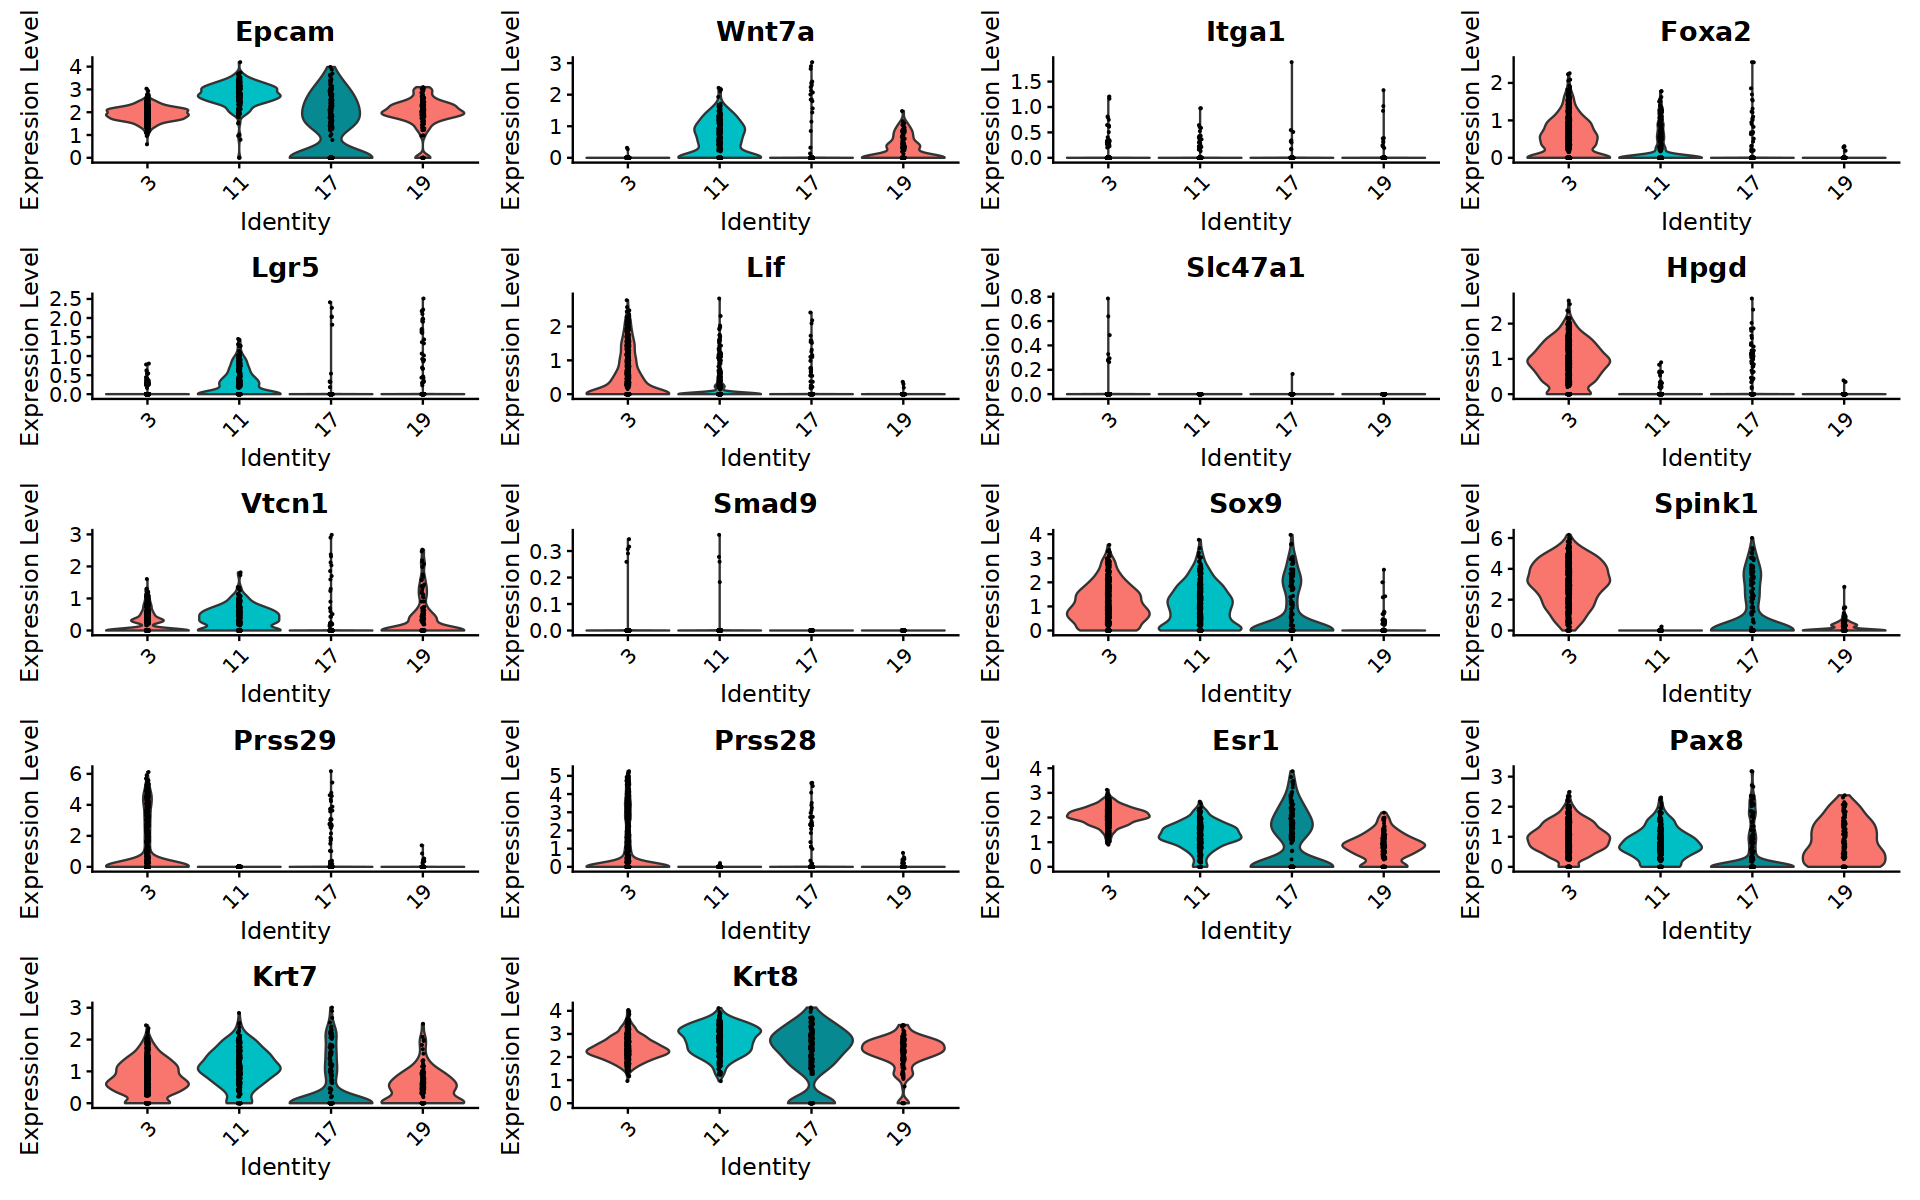

In [727]:
# Make violin plots showing distribution of possible marker gene expression for
# each epithelial cluster.

VlnPlot(subset(trim28_tmp, seurat_clusters %in% c(3, 11, 17, 19)), features = c("Epcam", "Wnt7a", "Itga1", "Foxa2", "Lgr5", "Lif", "Mt1e", "Mmp26", "Sult1e1", "Slc47a1", "Hpgd", "Vtcn1", "Smad9", "Sox9", "Spink1", "Prss29", "Prss28", "Esr1", "Pax8", "Krt7", "Krt8"), split.by = "seurat_clusters")

Warning message in FetchData.Seurat(object = object, vars = c(dims, "ident", features), :
“The following requested variables were not found: Mt1e, Mmp26, Sult1e1”
Warning message in FeaturePlot(subset(trim28_tmp, seurat_clusters %in% c(3, 11, :
“All cells have the same value (0) of Slc47a1.”
Warning message in FeaturePlot(subset(trim28_tmp, seurat_clusters %in% c(3, 11, :
“All cells have the same value (0) of Smad9.”
Warning message in FeaturePlot(subset(trim28_tmp, seurat_clusters %in% c(3, 11, :
“All cells have the same value (0) of Slc47a1.”
Warning message in FeaturePlot(subset(trim28_tmp, seurat_clusters %in% c(3, 11, :
“All cells have the same value (0) of Smad9.”


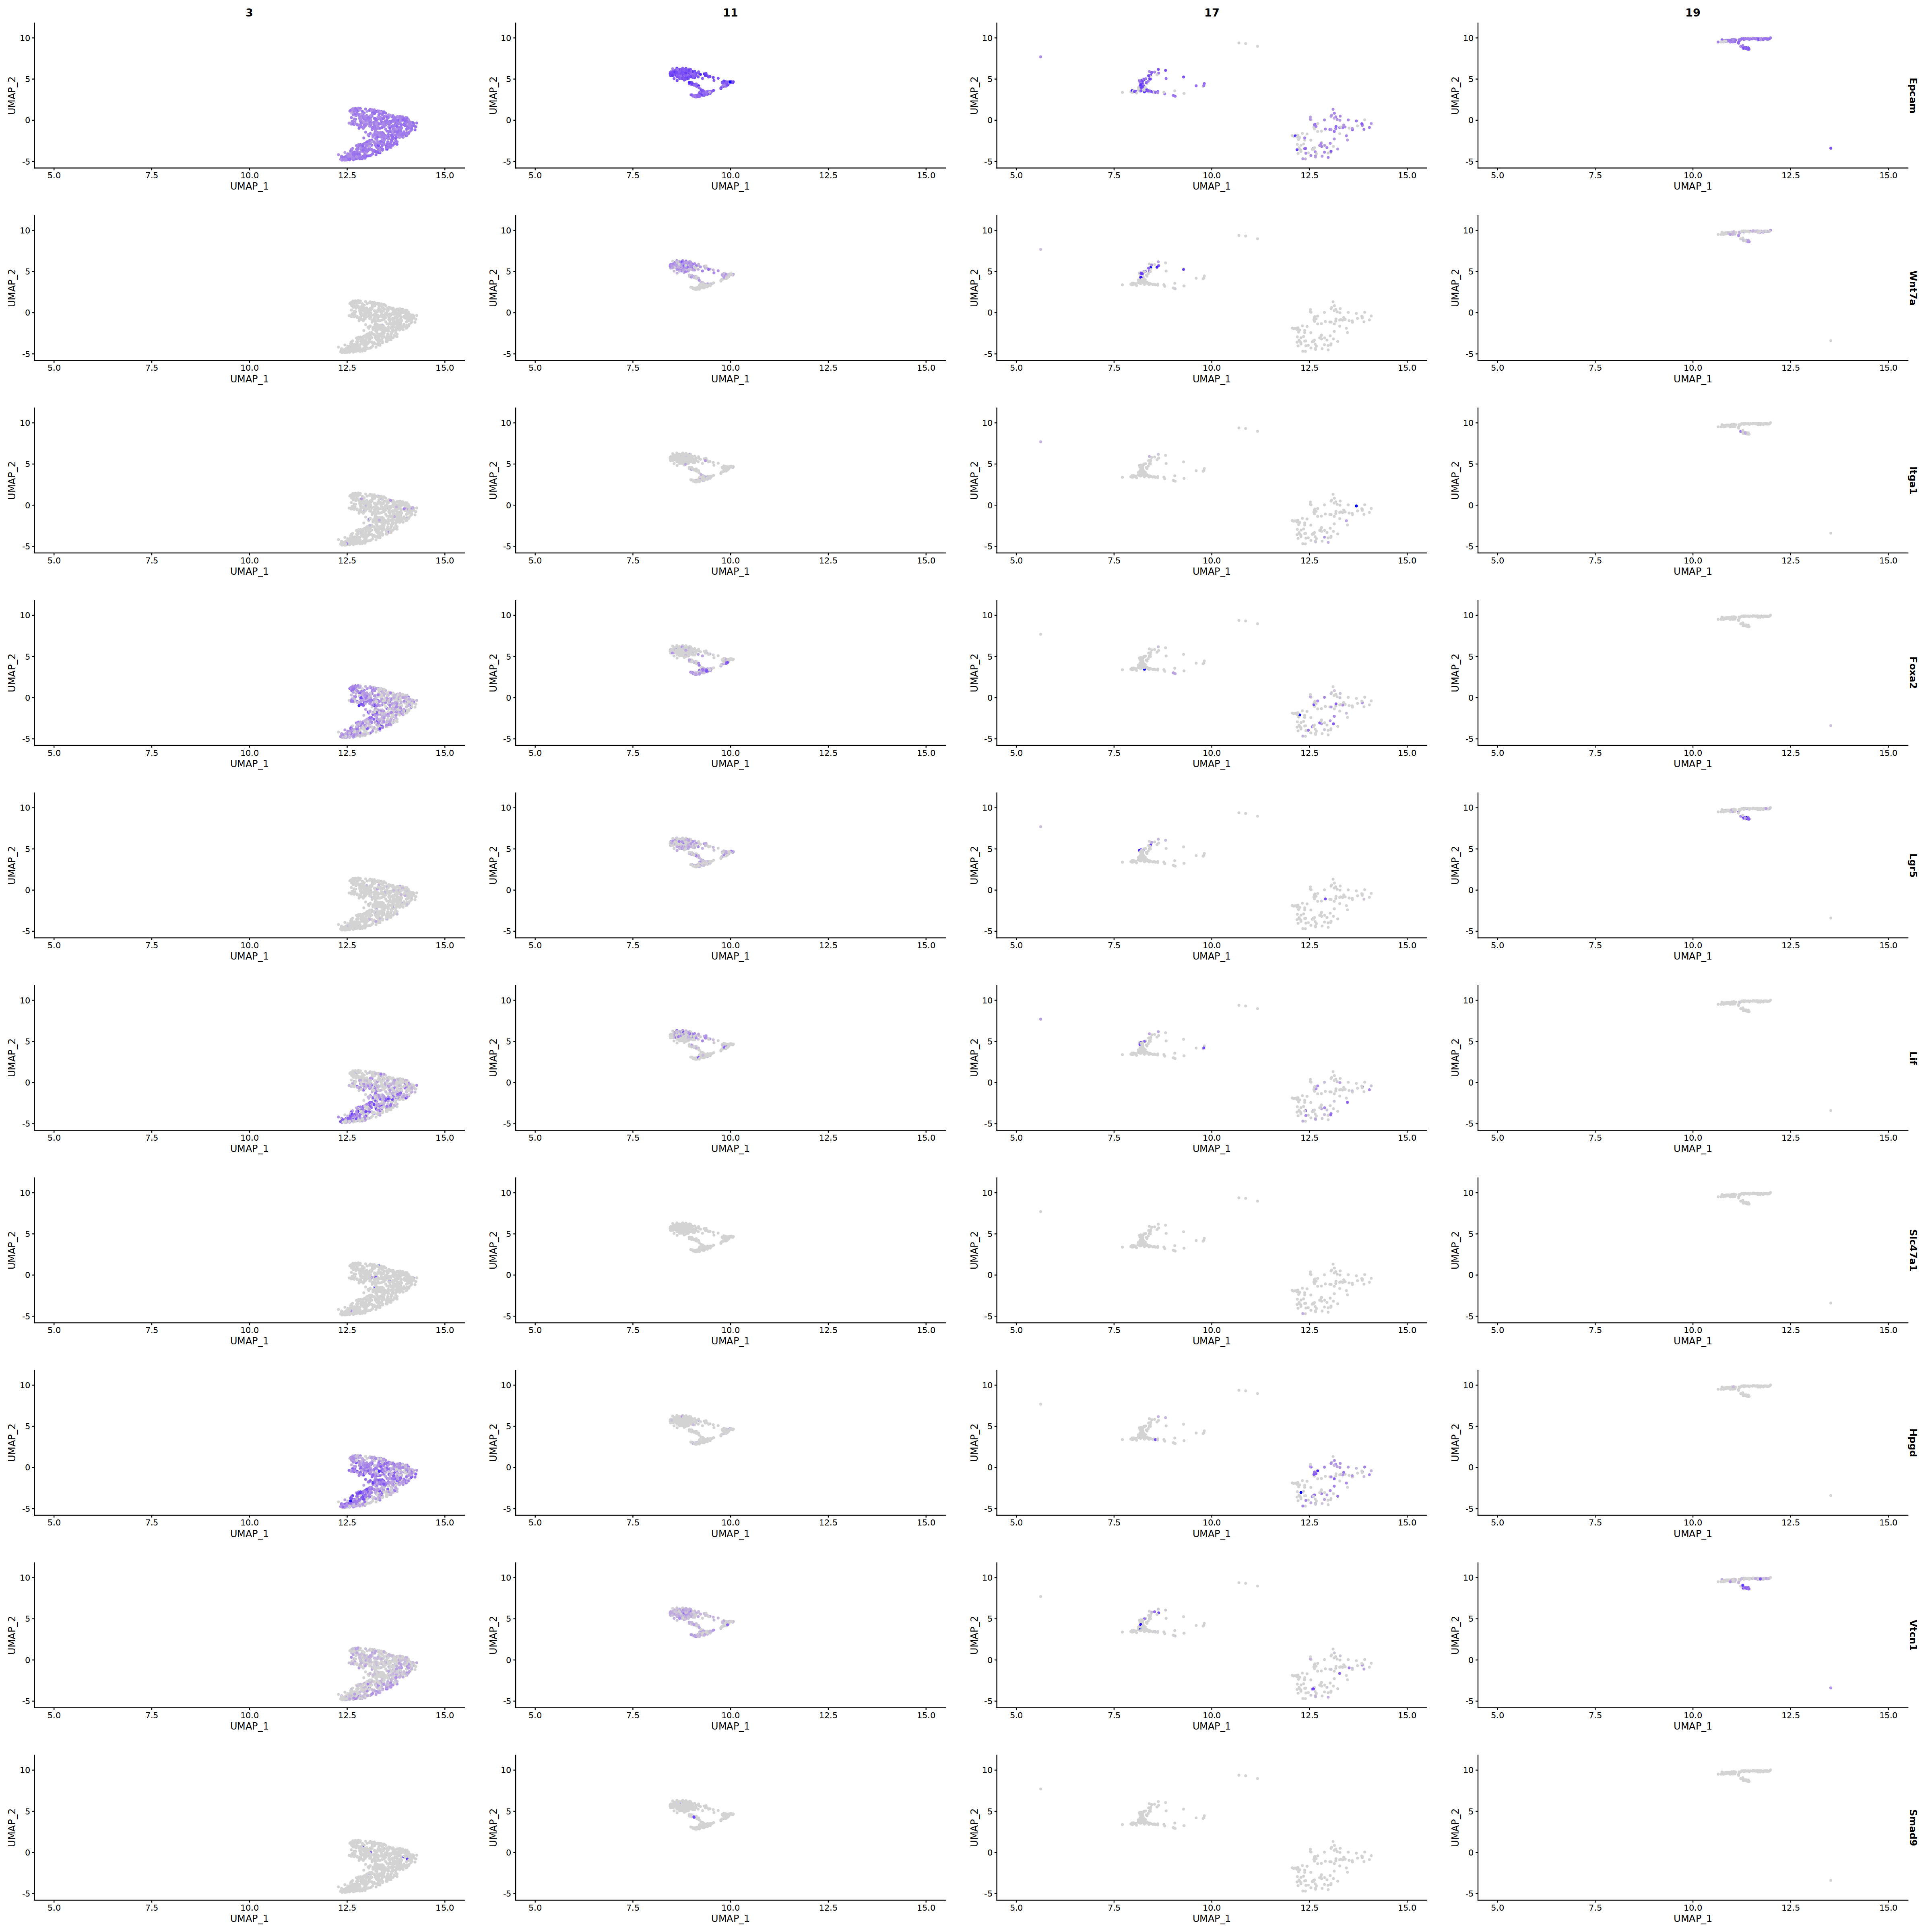

In [719]:
# Make violin plots showing distribution of possible marker gene expression for
# each epithelial cluster ACROSS INDIVIDUAL CELLS.

saved <- options(repr.plot.width = 40, repr.plot.height = 40)
FeaturePlot(subset(trim28_tmp, seurat_clusters %in% c(3, 11, 17, 19)), features = c("Epcam", "Wnt7a", "Itga1", "Foxa2", "Lgr5", "Lif", "Mt1e", "Mmp26", "Sult1e1", "Slc47a1", "Hpgd", "Vtcn1", "Smad9"), split.by = "seurat_clusters")
options(saved)

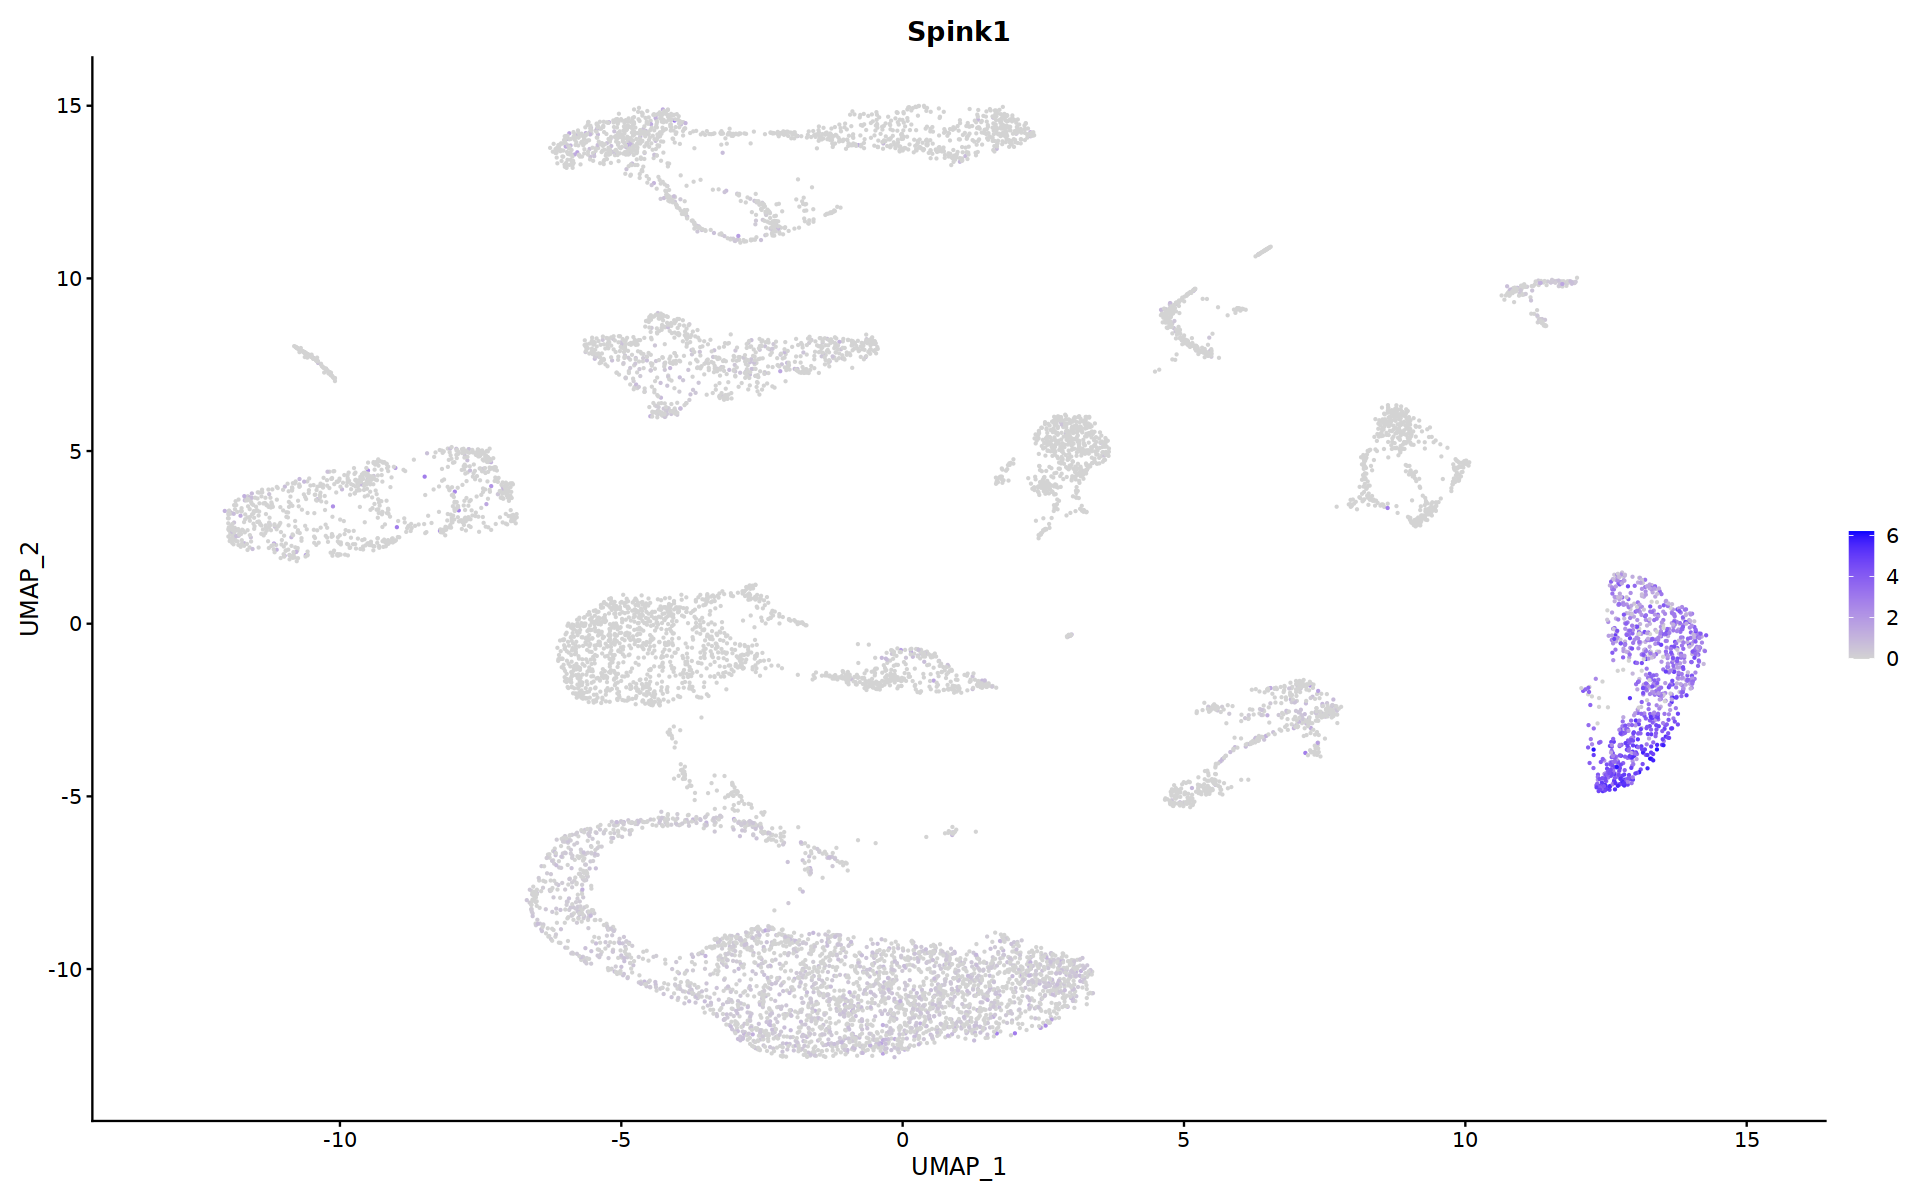

In [723]:
# Add a Spink1 plot to the above.

FeaturePlot(trim28, features = "Spink1")

Warning message in FetchData.Seurat(object = object, vars = features, slot = slot):
“The following requested variables were not found: Mt1e, Mmp26, Sult1e1”


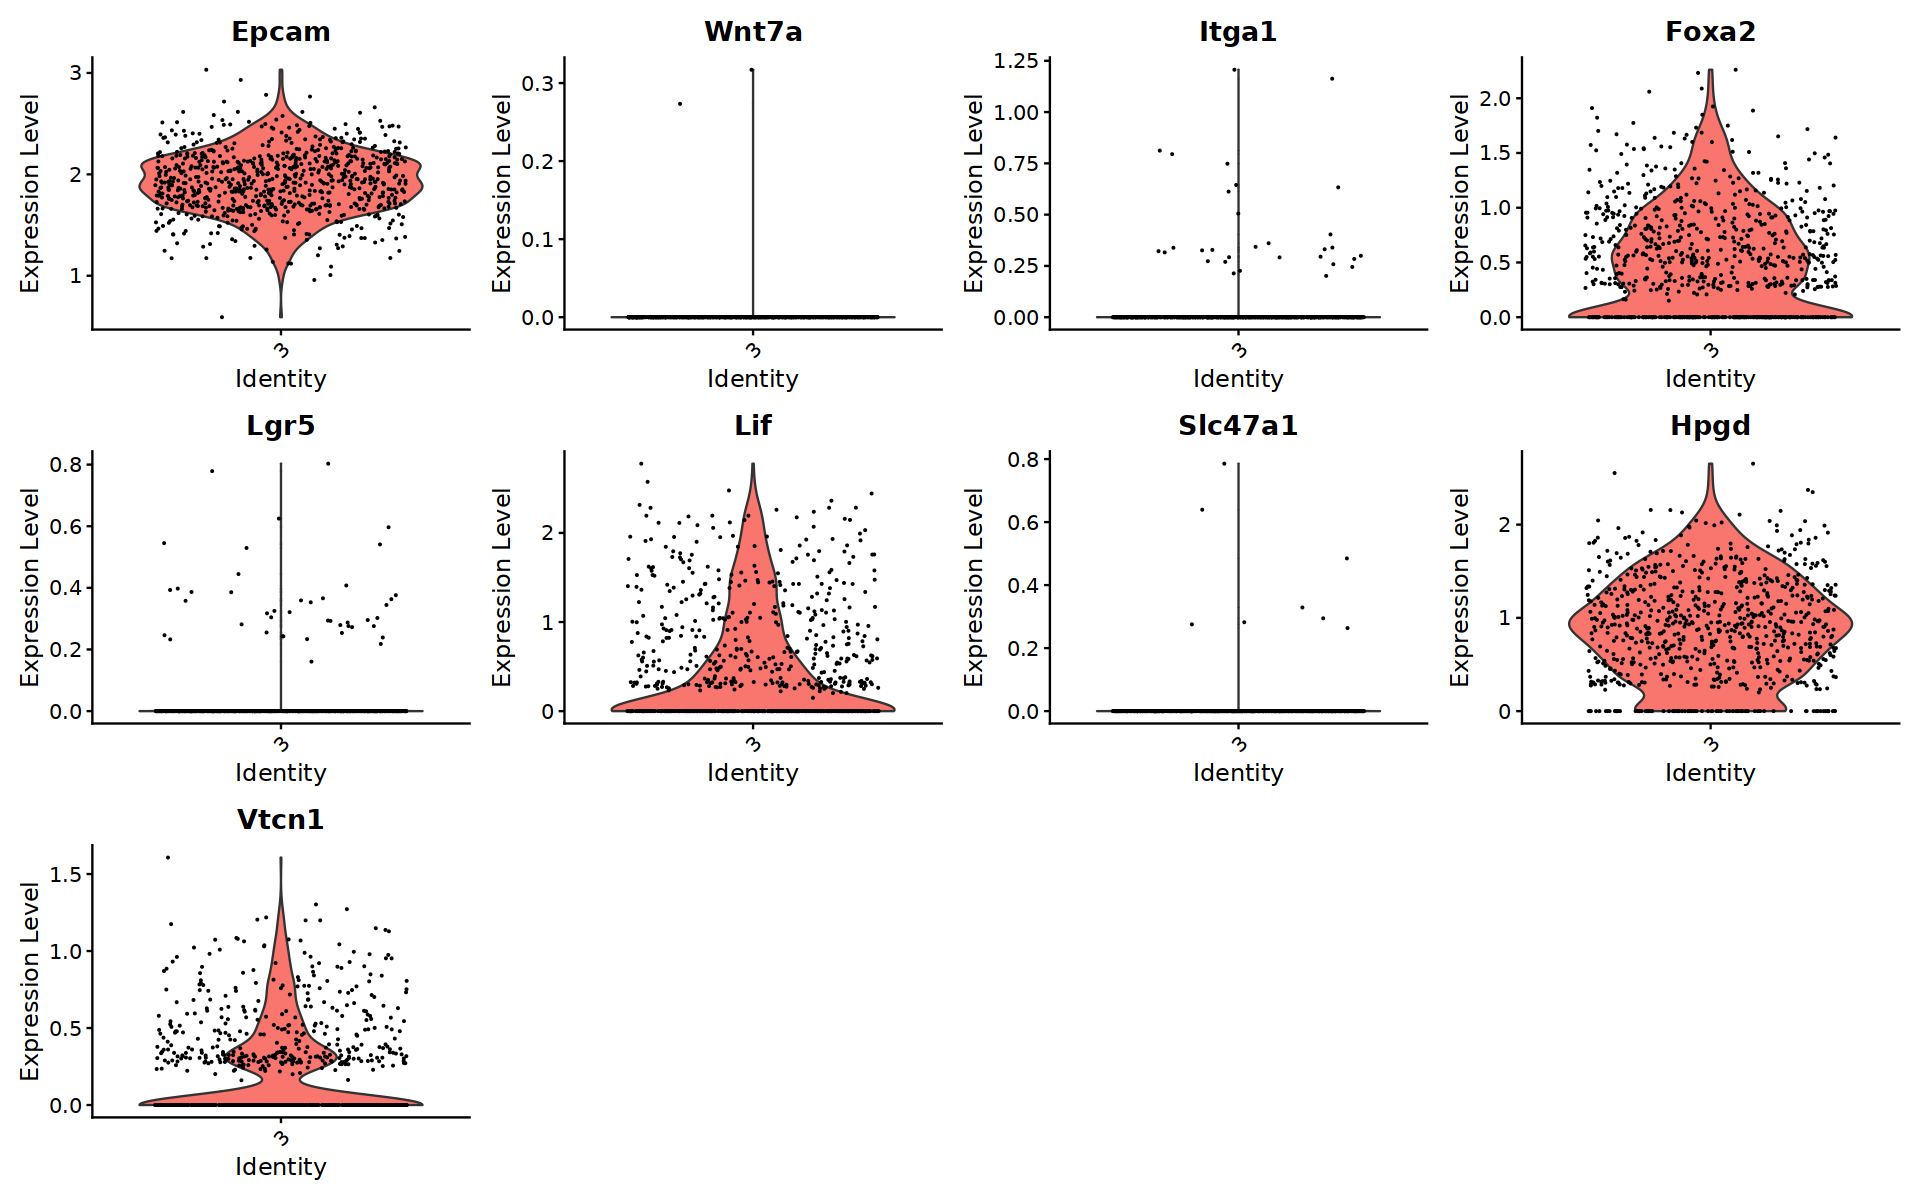

In [703]:
# More violin plots aiming to accomplish the same idea as the above.

VlnPlot(subset(trim28_tmp, seurat_clusters == 3), features = c("Epcam", "Wnt7a", "Itga1", "Foxa2", "Lgr5", "Lif", "Mt1e", "Mmp26", "Sult1e1", "Slc47a1", "Hpgd", "Vtcn1"))
#VlnPlot(subset(trim28_tmp, seurat_clusters == 11), features = c("Epcam", "Wnt7a", "Itga1", "Foxa2", "Lgr5"))
#VlnPlot(subset(trim28_tmp, seurat_clusters == 17), features = c("Epcam", "Wnt7a", "Itga1", "Foxa2", "Lgr5"))
#VlnPlot(subset(trim28_tmp, seurat_clusters == 19), features = c("Epcam", "Wnt7a", "Itga1", "Foxa2", "Lgr5"))